In [6]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import argparse
import json
from logging.config import dictConfig
from logging import getLogger
import os
import time

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # [3, 32, 32] => [6, 28, 28]
        self.conv2 = nn.Conv2d(6, 16, 5) # [6, 28, 28] => [16, 24, 24]
        self.pool = nn.MaxPool2d(2, 2) # [N,C,H,W] => [N, C, H/2, W/2]
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
def train(model, device, train_loader, optimizer, criterion, logger):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            logger.debug("[train] batch : %s/%s (%.0f%%),\tloss : %.6f",
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
    return (None, loss.item())

In [4]:
def test(model, device, test_loader, criterion, logger):
    model.eval()
    test_loss = []
    correct = 0
    result = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss.append(criterion(output, target).item())  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            result += torch.eq(torch.max(output, 1).indices, target)
            
    logger.debug("[dump] %s", test_loss)
    test_loss = np.mean(np.array(test_loss))
    accuracy = 100. * correct / len(test_loader.dataset)
    
    logger.debug("[test] ave loss : %.4f,\taccu : %d/%d(%.0f%%)",
        test_loss, correct, len(test_loader.dataset), accuracy)
    
    return (torch.tensor(result).numpy(), (test_loss, accuracy))

In [13]:
def main():
    with open('logging.json') as f:
        dictConfig(json.load(f))
    logger = getLogger('env')
    logger.debug("<" * 40)
    logger.info("[system] start")
    logger.info("[meta] データを分割して交換するアルゴリズム")
    
    start_time = time.time()

    def fetch_args(args=[]):
        parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
        parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                            help='input batch size for training (default: 64)')
        parser.add_argument('--epochs', type=int, default=14, metavar='N',
                            help='number of epochs to train (default: 14)')
        parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                            help='learning rate (default: 0.001)')
        parser.add_argument('--b1', type=float, default=0.9, metavar='B',
                            help='learning rate beta (default: 0.9)')
        parser.add_argument('--b2', type=float, default=0.999, metavar='B',
                            help='learning rate beta (default: 0.999)')
        parser.add_argument('--dataset', default="cifar10", metavar='D')
        parser.add_argument('--model', default="cnn", metavar='M')
        parser.add_argument('--optimizer', default="adam", metavar='O')
        parser.add_argument('--criterion', default="cross_entropy_loss", metavar='C')
        parser.add_argument('--save-model', action='store_true', default=False,
                            help='For Saving the current Model')
        return parser.parse_args(args=args)
  
    args = fetch_args("--epochs 1 --batch-size 32".split(" "))
    for arg in vars(args):
        logger.info("[param] %s=%s", arg, vars(args)[arg])
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    logger.info("[device] %s", device)
    
    #画像の変形処理
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #CIFAR-10のtrain, testsetのロード
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    
    model_X = CNN().to(device)
    model_Y = CNN().to(device)
    optimizer_X = optim.Adam(model_X.parameters(), lr=args.lr, betas=(args.b1, args.b2))
    optimizer_Y = optim.Adam(model_Y.parameters(), lr=args.lr, betas=(args.b1, args.b2))
    criterion = nn.CrossEntropyLoss()
    
    # init
    N = int(len(trainset) / 2)
    indices = np.arange(2 * N)
    A, B = indices[:N], indices[N:]
    
    log = {"X_train":[], "X_test":[], "Y_train":[], "Y_test":[], "X_acc":[], "Y_acc":[],
          "atob": [], "btoa": []}

    for epoch in range(args.epochs):
        logger.debug("-" * 20)
        logger.info("[system] epoch %d", epoch)
        
        # Split
        A_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(trainset, A), batch_size=args.batch_size)
        B_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(trainset, B), batch_size=args.batch_size)
        
        # test B
        logger.info("[system] train_a -> test_b")
        (_, loss_XA) = train(model_X, device, A_loader, optimizer_X, criterion, logger)
        (testB, (loss_XB, acc_X)) = test(model_X, device, B_loader, criterion, logger)
        
        # test A
        logger.info("[system] train_b -> test_a")
        (_, loss_YB) = train(model_Y, device, B_loader, optimizer_Y, criterion, logger)
        (testA, (loss_YA, acc_Y)) = test(model_Y, device, A_loader, criterion, logger)
        
        # Swap
        A_o, A_x = A[testA], A[np.logical_not(testA)]
        B_o, B_x = B[testB], B[np.logical_not(testB)]
        s = min(len(A_x), len(B_o))
        A = np.concatenate([A_o, B_o[:s], A_x[s:]])
        B = np.concatenate([B_x, A_x[:s], B_o[s:]])
        
        # log
        logger.debug("[dump] test_b : %s...", testB[:10])
        logger.debug("[dump] test_a : %s...", testA[:10])
        logger.debug("[dump] swap : B -> A : %s...", B_o[:s][:10])
        logger.debug("[dump] swap : A -> B : %s...", A_x[:s][:10])
        logger.debug("[dump] X loss : %s / %s,\tacc : %s", loss_XA, loss_XB, acc_X)
        logger.debug("[dump] Y loss : %s / %s,\tacc : %s", loss_YB, loss_YA, acc_Y)
        log["X_train"].append(loss_XA)
        log["X_test"].append(loss_XB)
        log["Y_train"].append(loss_YB)
        log["Y_test"].append(loss_YA)
        log["X_acc"].append(acc_X)
        log["Y_acc"].append(acc_Y)
        log["atob"].append(np.copy(A_x[:s]).tolist())
        log["btoa"].append(np.copy(B_o[:s]).tolist())
    
    logger.debug("%s statistics %s", "-" * 10, "-" * 10)
    logger.info("[stat] X train loss : %s", log["X_train"])
    logger.info("[stat] X test loss : %s", log["X_test"])
    logger.info("[stat] Y train loss : %s", log["Y_train"])
    logger.info("[stat] Y test loss : %s", log["Y_test"])
    logger.info("[stat] X accuracy : %s", log["X_acc"])
    logger.info("[stat] Y accuracy : %s", log["Y_acc"])
    logger.info("[stat] swap log A to B : %s", log["atob"])
    logger.info("[stat] swap log B to A : %s", log["btoa"])
    logger.info("[stat] elapsed time : %s[s]", time.time() - start_time)
    
    if args.save_model:
        logger.info("[system] saving...")
        torch.save(model.state_dict(), "swap.pt")
    
    logger.info("[system] finish")

if __name__ == '__main__':
    main()

[system] start
[meta] データを分割して交換するアルゴリズム
[param] batch_size=32
[param] epochs=1
[param] lr=0.001
[param] b1=0.9
[param] b2=0.999
[param] dataset=cifar10
[param] model=cnn
[param] optimizer=adam
[param] criterion=cross_entropy_loss
[param] save_model=False
[device] cpu


Files already downloaded and verified


[system] epoch 0
[system] train_a -> test_b
[system] train_b -> test_a
[stat] X train loss : [1.6304831504821777]
[stat] X test loss : [1.5762452150854613]
[stat] Y train loss : [2.2388675212860107]
[stat] Y test loss : [1.5296754913256907]
[stat] X accuracy : [43.3]
[stat] Y accuracy : [44.216]
[stat] swap log A to B : [[1, 3, 4, 6, 9, 12, 13, 15, 17, 18, 20, 21, 23, 24, 25, 27, 28, 29, 30, 35, 38, 39, 40, 41, 42, 45, 47, 49, 50, 51, 53, 54, 55, 56, 57, 59, 63, 66, 69, 70, 72, 74, 76, 77, 78, 80, 81, 82, 83, 84, 86, 89, 90, 91, 92, 93, 94, 98, 107, 108, 109, 110, 111, 113, 115, 116, 120, 121, 123, 125, 126, 127, 128, 138, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 166, 167, 169, 170, 171, 173, 174, 175, 179, 183, 184, 185, 189, 191, 192, 193, 195, 196, 198, 199, 200, 203, 207, 210, 211, 215, 218, 220, 221, 223, 225, 229, 230, 231, 235, 237, 241, 242, 247, 248, 249, 250, 251, 253, 258, 259, 262, 263, 266, 271, 272, 273, 274,

[stat] swap log B to A : [[25001, 25002, 25004, 25009, 25011, 25013, 25018, 25021, 25024, 25026, 25027, 25031, 25032, 25033, 25034, 25035, 25038, 25040, 25042, 25043, 25045, 25046, 25047, 25051, 25052, 25053, 25054, 25057, 25059, 25063, 25065, 25067, 25069, 25070, 25072, 25073, 25074, 25076, 25080, 25081, 25085, 25088, 25090, 25092, 25094, 25097, 25102, 25105, 25107, 25110, 25112, 25114, 25115, 25116, 25117, 25121, 25122, 25124, 25128, 25129, 25132, 25133, 25134, 25135, 25136, 25139, 25141, 25144, 25146, 25149, 25152, 25154, 25155, 25156, 25157, 25162, 25163, 25165, 25167, 25168, 25169, 25170, 25173, 25178, 25179, 25180, 25186, 25187, 25188, 25190, 25191, 25193, 25196, 25198, 25199, 25202, 25203, 25204, 25209, 25211, 25212, 25213, 25219, 25220, 25222, 25223, 25228, 25233, 25236, 25237, 25241, 25242, 25244, 25247, 25250, 25260, 25261, 25262, 25266, 25267, 25268, 25270, 25271, 25276, 25280, 25283, 25284, 25285, 25286, 25287, 25288, 25290, 25292, 25293, 25294, 25297, 25303, 25304, 25306, 

[stat] elapsed time : 65.93671536445618[s]
[system] finish


In [ ]:
#画像の変形処理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#CIFAR-10のtrain, testsetのロード
#変形はtransformを適用
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#DataLoaderの適用->これによりバッチの割り当て・シャッフルをまとめて行うことができる
#batch_sizeでバッチサイズを指定
#num_workersでいくつのコアでデータをロードするか指定(デフォルトはメインのみ)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

In [79]:
r = [torch.tensor(False), torch.tensor(True)]
torch.tensor(r).numpy()


array([False,  True])

In [85]:
import csv

log = {"A_acc":["a", "bb"], "B_acc":[1, 2]}

with open("stock.csv", "w", encoding="utf-8") as f:
    writer = csv.writer(f, lineterminator="\n")
    writer.writerows(log)

In [102]:
from logging import getLogger, StreamHandler, DEBUG
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)
logger.propagate = False

print("a")

a


In [121]:
# from logging import getLogger
logger = getLogger(__name__)

from logging import StreamHandler, basicConfig, DEBUG, getLogger, Formatter

def setup_logger(log_filename):
    format_str = '%(asctime)s@%(name)s %(levelname)s # %(message)s'
    basicConfig(filename=log_filename, level=DEBUG, format=format_str)
    stream_handler = StreamHandler()
    stream_handler.setFormatter(Formatter(format_str))
    getLogger().addHandler(stream_handler)
    

logger.info("messagea")

logger.info("mess")


messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
mess
mess
mess
mess
mess
mess
mess
mess
mess
mess


In [9]:
np.empty(0)

array([], dtype=float64)

In [124]:
from logging import StreamHandler, basicConfig, INFO, getLogger, Formatter, shutdown

def setup_logger(log_filename):
    format_str = '%(asctime)s@%(name)s %(levelname)s # %(message)s'
    basicConfig(filename=log_filename, level=INFO, format=format_str)
    stream_handler = StreamHandler()
    stream_handler.setFormatter(Formatter(format_str))
    getLogger().addHandler(stream_handler)

def kill_logger():
    # for l in getLogger(__name__):
    # logger = loggers.get(l)
    for h in logger.handlers:
        logger.removeHandler(h)
    # getLogger().removeHandler()
    shutdown()
    return

logger = getLogger(__name__)
setup_logger("log.txt")

logger.info("aa")
print(logger)
# kill_logger()

aa
aa
aa
aa
aa
aa
aa
aa
aa
aa


<Logger __main__ (DEBUG)>


In [144]:
import json
from logging.config import dictConfig

with open('logging.json') as f:
    dictConfig(json.load(f))


# 動作確認
from logging import getLogger

# RootLogger: error のみが標準エラーに
root_logger = getLogger()
root_logger.debug('RootLogger: debug')
root_logger.error('RootLogger: error')

# myapp: debug は指定したファイルに
# myapp: error は指定したファイルと標準エラーに
myapp_logger = getLogger('env')
myapp_logger.debug('myapp: debug')
myapp_logger.error('myapp: error')
myapp_logger = getLogger('env.model')
myapp_logger.error('env: error')

# これはすべて無視される
hoge_logger = getLogger('hoge.fuga.piyo')
hoge_logger.debug('hoge: debug')
hoge_logger.error('hoge: error')

2020-04-29 19:33:53,564: RootLogger: error
2020-04-29 19:33:53,566: myapp: error
2020-04-29 19:33:53,568: env: error


In [160]:
parser = argparse.ArgumentParser()
parser.add_argument('--foo')
args = parser.parse_args(['--foo', 'BAR'])
for a in vars(args):
    print(a, vars(args)[a])
print(vars(args))


foo BAR
{'foo': 'BAR'}


In [21]:
# exp main
m_x_train_loss = [2.288025379180908, 1.854137897491455, 1.7273635864257812, 1.45737886428833, 1.3322714567184448, 1.3078572750091553, 1.3629910945892334, 1.3265225887298584, 1.2427623271942139, 1.178240180015564, 1.094214677810669, 1.1634907722473145, 1.0996596813201904, 1.1158974170684814, 1.0118272304534912, 1.0208563804626465, 1.0107688903808594, 0.8501958847045898, 0.8958674073219299, 0.774604320526123, 0.7631874084472656, 0.7437644004821777, 0.8369741439819336, 0.798240065574646, 1.2795028686523438]
m_x_test_loss = [2.240487919506627, 2.0081781863556105, 1.9855095264778944, 2.1642124908365505, 2.3438860632560226, 2.3660928456736006, 2.4317822350345204, 2.620276643233809, 2.7199758346921272, 2.8730840539215317, 2.9618033839965276, 3.00621501852592, 3.158214510707465, 3.1677522714215827, 3.189254136819223, 3.188377470788632, 3.2310182273349772, 3.2078502377446307, 3.2170157574417493, 3.281280594000203, 3.420853141859717, 3.5144480876028728, 3.615827125230815, 3.701036387235784, 3.7283214680750403]
m_y_train_loss = [2.4142141342163086, 1.5543699264526367, 0.19778665900230408, 0.23293083906173706, 0.13564211130142212, 0.19824475049972534, 0.8459981679916382, 0.01066499948501587, 0.07485067844390869, 0.5425605177879333, 0.7458614110946655, 0.21733249723911285, 1.2879126071929932, 0.04729515314102173, 0.07440656423568726, 0.6998357772827148, 0.0025858283042907715, 0.15520411729812622, 0.01651930809020996, 0.1700097918510437, 0.00644761323928833, 0.11731904745101929, 0.2039785385131836, 0.018861770629882812, 0.9370211958885193]
m_y_test_loss = [2.0330521650064166, 1.7720401763000782, 6.50136181217352, 3.333354907583443, 8.564231173386196, 2.7435420698850335, 4.255091821296964, 3.8134682301243603, 3.5727248711896418, 2.9867952860896585, 2.8871546805057475, 3.9461203044994244, 2.6464209466772206, 4.867463631101396, 3.2882710109612, 5.5193515073886985, 3.2386772191951616, 3.6259085398050583, 4.360217468499641, 4.265082189795381, 4.6662463931103435, 4.5525197658451875, 4.234833705038194, 4.781921831703842, 4.3116312874046105]
m_x_acc = [15.468, 24.508, 20.668, 13.52, 7.556, 7.096, 6.864, 4.98, 3.176, 3.724, 2.948, 3.096, 2.468, 1.672, 2.444, 1.996, 1.92, 2.776, 1.904, 1.66, 1.004, 0.896, 0.704, 0.88, 0.992]
m_y_acc = [26.676, 31.244, 16.52, 32.64, 10.116, 31.72, 5.884, 28.516, 12.96, 25.568, 25.124, 23.568, 32.108, 23.204, 34.372, 26.544, 34.028, 33.38, 33.416, 33.964, 32.972, 34.04, 36.92, 38.436, 38.348]


In [22]:
# exp baseline
b_x_train_loss = [1.8339635133743286, 1.6075594425201416, 1.5646916627883911, 1.4751136302947998, 1.361932396888733, 1.2491068840026855, 1.138421654701233, 1.0759618282318115, 1.0412476062774658, 0.9572204351425171, 0.9483405351638794, 0.9316418766975403, 0.8921067118644714, 0.8888096809387207, 0.8420193791389465, 0.7329766750335693, 0.6785648465156555, 0.6508007645606995, 0.5793047547340393, 0.5481230616569519, 0.48123276233673096, 0.44880324602127075, 0.42180633544921875, 0.30240172147750854, 0.31743207573890686]
b_x_test_loss = [2.1110229269480447, 1.6705207288532171, 1.5288082731509927, 1.4491184713820655, 1.3900613765722654, 1.3508085648523869, 1.3145048611452392, 1.292858632573392, 1.2760242365982315, 1.2652753282264495, 1.252878129215326, 1.2460683285427339, 1.251505480942174, 1.258464446681017, 1.2671315856683125, 1.2606168866958363, 1.2823017077879195, 1.3184130398874776, 1.355862097563228, 1.38871339186597, 1.4275211941639125, 1.4860073058596042, 1.5128921037176368, 1.5769022961343167, 1.6559533543374703]
b_x_acc = [24.172, 37.656, 43.86, 47.3, 49.644, 51.416, 53.224, 54.244, 55.052, 55.84, 56.492, 56.984, 57.256, 57.324, 57.352, 57.912, 57.696, 57.424, 57.16, 56.988, 56.94, 56.74, 56.644, 56.36, 55.98]


In [23]:
# exp notrain
n_x_test_loss = [2.30429244346521, 2.314543409829558, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603]
n_y_test_loss = [2.304065739277152, 2.30612972632327, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546]
n_x_acc = [10.252, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148]
n_y_acc = [9.868, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872]


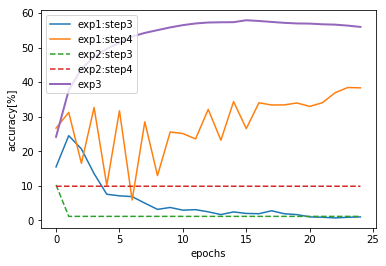

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(25), m_x_acc, label="exp1:step3")
plt.plot(np.arange(25), m_y_acc, label="exp1:step4")
plt.plot(np.arange(25), n_x_acc, label="exp2:step3", linestyle="--")
plt.plot(np.arange(25), n_y_acc, label="exp2:step4", linestyle="--")
plt.plot(np.arange(25), b_x_acc, label="exp3", linewidth = 2)
plt.xlabel("epochs")
plt.ylabel("accuracy[%]")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("accuracy.png")

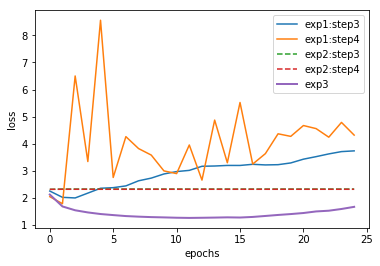

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(25), m_x_test_loss, label="exp1:step3")
plt.plot(np.arange(25), m_y_test_loss, label="exp1:step4")
plt.plot(np.arange(25), n_x_test_loss, label="exp2:step3", linestyle="--")
plt.plot(np.arange(25), n_y_test_loss, label="exp2:step4", linestyle="--")
plt.plot(np.arange(25), b_x_test_loss, label="exp3", linewidth = 2)
plt.xlabel("epochs")
plt.ylabel("loss")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("loss.png")

In [4]:
atob = [[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 62, 63, 66, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 127, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 158, 159, 160, 161, 162, 163, 164, 165, 169, 170, 171, 172, 174, 175, 178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 202, 203, 204, 205, 207, 208, 209, 210, 211, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255, 256, 258, 259, 261, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 276, 277, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 296, 298, 299, 300, 301, 303, 306, 307, 308, 309, 310, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 326, 327, 328, 329, 331, 332, 333, 334, 335, 336, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 355, 356, 358, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 376, 377, 378, 379, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 394, 395, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 427, 428, 429, 430, 433, 434, 435, 436, 437, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 487, 488, 489, 490, 492, 494, 495, 496, 497, 499, 500, 501, 502, 503, 504, 505, 507, 509, 510, 512, 513, 514, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 535, 536, 537, 538, 539, 540, 541, 543, 544, 545, 546, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 562, 563, 564, 566, 567, 568, 570, 571, 572, 573, 574, 575, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 591, 592, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 625, 626, 627, 628, 629, 630, 631, 632, 633, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 667, 669, 671, 672, 673, 674, 677, 678, 679, 680, 681, 682, 683, 684, 685, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 698, 700, 701, 702, 703, 704, 705, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 733, 735, 736, 737, 738, 739, 740, 741, 742, 744, 745, 746, 747, 748, 749, 752, 754, 755, 756, 757, 758, 759, 760, 763, 764, 765, 766, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 814, 815, 816, 818, 819, 820, 821, 822, 824, 825, 826, 827, 829, 830, 831, 832, 836, 837, 838, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 875, 876, 877, 878, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 891, 892, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 909, 910, 911, 912, 913, 914, 916, 920, 921, 922, 923, 924, 925, 926, 927, 929, 930, 931, 933, 934, 935, 937, 938, 939, 940, 941, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 979, 982, 983, 984, 985, 986, 987, 989, 990, 991, 992, 994, 995, 998, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1030, 1031, 1032, 1034, 1035, 1036, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1063, 1064, 1065, 1066, 1067, 1069, 1070, 1071, 1073, 1074, 1075, 1076, 1077, 1078, 1080, 1083, 1084, 1085, 1086, 1087, 1089, 1092, 1094, 1095, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1112, 1113, 1114, 1116, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1130, 1131, 1132, 1133, 1135, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1153, 1154, 1155, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1171, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1187, 1188, 1189, 1190, 1191, 1192, 1194, 1195, 1196, 1197, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1241, 1243, 1244, 1245, 1246, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1378, 1379, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1412, 1413, 1414, 1415, 1416, 1417, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1449, 1450, 1451, 1452, 1453, 1454, 1456, 1457, 1458, 1459, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1475, 1477, 1478, 1479, 1480, 1481, 1483, 1484, 1485, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1522, 1523, 1524, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1539, 1540, 1542, 1543, 1544, 1546, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1560, 1561, 1562, 1563, 1564, 1566, 1568, 1569, 1572, 1573, 1575, 1576, 1577, 1579, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1589, 1590, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1601, 1602, 1603, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1692, 1693, 1695, 1696, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1718, 1720, 1721, 1722, 1723, 1724, 1725, 1727, 1728, 1729, 1730, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1748, 1749, 1751, 1752, 1753, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1821, 1822, 1823, 1824, 1825, 1826, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1861, 1862, 1863, 1864, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1874, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1902, 1903, 1904, 1905, 1907, 1908, 1909, 1910, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1923, 1924, 1925, 1926, 1927, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1944, 1945, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1984, 1985, 1987, 1988, 1989, 1990, 1992, 1994, 1995, 1996, 1997, 1999, 2000, 2001, 2002, 2003, 2004, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018, 2019, 2021, 2022, 2024, 2025, 2026, 2027, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2053, 2055, 2056, 2057, 2058, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2072, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2090, 2091, 2092, 2093, 2095, 2096, 2097, 2098, 2099, 2100, 2102, 2103, 2105, 2106, 2107, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2119, 2120, 2121, 2122, 2123, 2124, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2144, 2145, 2146, 2150, 2151, 2152, 2154, 2155, 2156, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2168, 2169, 2171, 2172, 2174, 2175, 2176, 2177, 2178, 2179, 2181, 2186, 2187, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2205, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2247, 2248, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2262, 2263, 2264, 2265, 2267, 2268, 2269, 2270, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2281, 2282, 2284, 2285, 2286, 2287, 2288, 2290, 2291, 2292, 2293, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2315, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2372, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2391, 2392, 2393, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2411, 2412, 2413, 2414, 2415, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2497, 2498, 2499, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2510, 2511, 2512, 2513, 2514, 2515, 2517, 2518, 2519, 2520, 2521, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2550, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2585, 2586, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2598, 2599, 2600, 2601, 2602, 2603, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2622, 2623, 2624, 2625, 2626, 2627, 2629, 2631, 2633, 2634, 2635, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2657, 2658, 2659, 2660, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2687, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2707, 2708, 2710, 2712, 2713, 2714, 2715, 2716, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2728, 2729, 2731, 2732, 2734, 2735, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2746, 2747, 2749, 2750, 2751, 2752, 2753, 2754, 2756, 2757, 2758, 2759, 2760, 2761, 2763, 2764, 2766, 2767, 2768, 2770, 2772, 2773, 2774, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2789, 2790, 2791, 2792, 2793, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2842, 2843, 2845, 2846, 2847, 2848, 2849, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2863, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2878, 2879, 2880, 2881, 2882, 2883, 2885, 2887, 2888, 2889, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2902, 2903, 2904, 2905, 2907, 2908, 2909, 2911, 2912, 2913, 2914, 2915, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2957, 2958, 2959, 2960, 2961, 2962, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3010, 3011, 3012, 3013, 3014, 3016, 3018, 3020, 3023, 3024, 3026, 3027, 3029, 3030, 3032, 3033, 3035, 3036, 3037, 3038, 3039, 3041, 3042, 3043, 3044, 3045, 3046, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3056, 3057, 3058, 3061, 3063, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3081, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3098, 3099, 3100, 3101, 3102, 3104, 3105, 3106, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3132, 3133, 3134, 3135, 3136, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3154, 3155, 3157, 3158, 3159, 3160, 3161, 3162, 3164, 3165, 3166, 3168, 3169, 3170, 3171, 3172, 3174, 3175, 3176, 3177, 3178, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3196, 3197, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3230, 3231, 3232, 3234, 3235, 3236, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3258, 3259, 3260, 3261, 3262, 3263, 3266, 3268, 3269, 3272, 3274, 3275, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3313, 3314, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3380, 3382, 3383, 3384, 3385, 3386, 3387, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3397, 3398, 3400, 3401, 3402, 3403, 3405, 3406, 3407, 3408, 3409, 3411, 3412, 3413, 3415, 3416, 3417, 3418, 3419, 3422, 3423, 3424, 3425, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3449, 3450, 3454, 3455, 3457, 3458, 3459, 3460, 3461, 3462, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3493, 3494, 3497, 3499, 3500, 3501, 3502, 3503, 3504, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3532, 3533, 3534, 3535, 3536, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3573, 3574, 3575, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3617, 3618, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3629, 3630, 3631, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3642, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3654, 3655, 3656, 3657, 3658, 3659, 3661, 3662, 3663, 3664, 3665, 3668, 3669, 3670, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3738, 3739, 3740, 3741, 3742, 3745, 3746, 3747, 3749, 3750, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3761, 3762, 3763, 3764, 3765, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3779, 3780, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3791, 3792, 3793, 3795, 3796, 3797, 3798, 3800, 3801, 3802, 3804, 3805, 3806, 3807, 3809, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3823, 3824, 3825, 3826, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3852, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3868, 3869, 3870, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3895, 3897, 3898, 3900, 3901, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3918, 3919, 3920, 3921, 3922, 3923, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3935, 3936, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3950, 3951, 3952, 3953, 3955, 3956, 3957, 3958, 3961, 3962, 3963, 3964, 3967, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3991, 3994, 3996, 3997, 3998, 3999, 4001, 4003, 4005, 4006, 4007, 4008, 4010, 4012, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4042, 4043, 4044, 4045, 4046, 4048, 4049, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4068, 4069, 4070, 4071, 4072, 4073, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4100, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4126, 4128, 4129, 4130, 4131, 4133, 4134, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4170, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4201, 4202, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4257, 4258, 4259, 4261, 4262, 4263, 4264, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4317, 4318, 4320, 4322, 4323, 4324, 4325, 4327, 4328, 4329, 4331, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4348, 4349, 4350, 4351, 4353, 4354, 4356, 4357, 4358, 4359, 4360, 4361, 4364, 4365, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4420, 4421, 4422, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4449, 4450, 4452, 4453, 4454, 4455, 4456, 4460, 4461, 4462, 4464, 4465, 4466, 4468, 4469, 4470, 4471, 4472, 4474, 4475, 4476, 4477, 4478, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4488, 4489, 4490, 4491, 4493, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4506, 4507, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4518, 4519, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4530, 4531, 4533, 4534, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4549, 4550, 4551, 4552, 4554, 4555, 4556, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4566, 4567, 4568, 4569, 4570, 4571, 4573, 4574, 4575, 4576, 4577, 4578, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4592, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4601, 4602, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4628, 4629, 4630, 4632, 4633, 4634, 4637, 4638, 4640, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4693, 4695, 4697, 4700, 4701, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4729, 4730, 4731, 4732, 4734, 4735, 4736, 4737, 4738, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4763, 4765, 4766, 4767, 4768, 4770, 4771, 4772, 4773, 4774, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4798, 4799, 4800, 4801, 4804, 4805, 4806, 4807, 4809, 4810, 4811, 4812, 4813, 4815, 4816, 4818, 4819, 4820, 4821, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4839, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4850, 4851, 4852, 4853, 4854, 4855, 4857, 4858, 4859, 4860, 4861, 4863, 4864, 4865, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4885, 4886, 4887, 4888, 4889, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4914, 4915, 4916, 4918, 4919, 4921, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4943, 4946, 4947, 4948, 4950, 4951, 4952, 4954, 4955, 4957, 4958, 4959, 4962, 4963, 4964, 4965, 4966, 4967, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4984, 4985, 4986, 4987, 4988, 4989, 4991, 4992, 4994, 4995, 4996, 4998, 4999, 5000, 5001, 5003, 5005, 5006, 5007, 5008, 5010, 5012, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5037, 5038], [1, 4, 32, 40, 46, 56, 61, 64, 65, 67, 75, 81, 96, 102, 107, 112, 119, 126, 128, 134, 148, 156, 157, 166, 167, 168, 173, 176, 177, 182, 183, 195, 201, 206, 212, 217, 227, 236, 250, 257, 260, 262, 275, 278, 295, 297, 302, 304, 305, 311, 312, 323, 330, 337, 354, 357, 359, 360, 375, 380, 393, 396, 426, 431, 432, 438, 454, 471, 486, 491, 493, 498, 506, 508, 511, 515, 534, 542, 547, 561, 565, 569, 576, 577, 590, 593, 606, 607, 624, 634, 666, 668, 670, 675, 676, 686, 697, 699, 706, 732, 734, 743, 750, 751, 753, 761, 762, 767, 784, 813, 817, 823, 828, 833, 834, 835, 839, 840, 841, 852, 873, 874, 879, 890, 893, 894, 908, 915, 917, 918, 919, 928, 932, 936, 942, 953, 978, 980, 981, 988, 993, 996, 997, 999, 1000, 1020, 1029, 1033, 1037, 1045, 1062, 1068, 1072, 1079, 1081, 1082, 1088, 1090, 1091, 1093, 1096, 1111, 1115, 1117, 1129, 1134, 1136, 1152, 1156, 1170, 1172, 1186, 1193, 1198, 1199, 1217, 1232, 1240, 1242, 1247, 1272, 1305, 1330, 1344, 1355, 1356, 1377, 1380, 1390, 1401, 1410, 1411, 1418, 1419, 1448, 1455, 1460, 1474, 1476, 1482, 1486, 1494, 1502, 1503, 1520, 1521, 1525, 1538, 1541, 1545, 1547, 1548, 1559, 1565, 1567, 1570, 1571, 1574, 1578, 1580, 1588, 1591, 1599, 1600, 1604, 1618, 1634, 1651, 1652, 1682, 1691, 1694, 1697, 1717, 1719, 1726, 1731, 1747, 1750, 1754, 1779, 1780, 1790, 1799, 1810, 1820, 1827, 1847, 1848, 1849, 1860, 1865, 1873, 1875, 1886, 1901, 1906, 1911, 1922, 1928, 1942, 1943, 1946, 1973, 1983, 1986, 1991, 1993, 1998, 2005, 2009, 2017, 2020, 2023, 2028, 2038, 2052, 2054, 2059, 2071, 2073, 2081, 2089, 2094, 2101, 2104, 2108, 2118, 2125, 2143, 2147, 2148, 2149, 2153, 2157, 2167, 2170, 2173, 2180, 2182, 2183, 2184, 2185, 2188, 2204, 2206, 2227, 2246, 2249, 2250, 2251, 2259, 2260, 2261, 2266, 2271, 2280, 2283, 2289, 2294, 2305, 2314, 2316, 2334, 2335, 2351, 2361, 2371, 2373, 2374, 2389, 2390, 2394, 2410, 2416, 2428, 2445, 2455, 2456, 2457, 2469, 2477, 2482, 2496, 2500, 2509, 2516, 2522, 2531, 2549, 2551, 2570, 2582, 2584, 2587, 2597, 2604, 2621, 2628, 2630, 2632, 2636, 2644, 2656, 2661, 2685, 2686, 2688, 2706, 2709, 2711, 2717, 2727, 2730, 2733, 2736, 2745, 2748, 2755, 2762, 2765, 2769, 2771, 2775, 2788, 2794, 2802, 2827, 2828, 2829, 2841, 2844, 2850, 2851, 2862, 2864, 2877, 2884, 2886, 2890, 2901, 2906, 2910, 2916, 2928, 2940, 2956, 2963, 2983, 2984, 2985, 2994, 3009, 3015, 3017, 3019, 3021, 3022, 3025, 3028, 3031, 3034, 3040, 3047, 3055, 3059, 3060, 3062, 3064, 3079, 3080, 3082, 3097, 3103, 3107, 3131, 3137, 3152, 3153, 3156, 3163, 3167, 3173, 3179, 3187, 3195, 3198, 3212, 3221, 3229, 3233, 3237, 3238, 3249, 3257, 3264, 3265, 3267, 3270, 3271, 3273, 3276, 3285, 3293, 3312, 3315, 3345, 3346, 3356, 3370, 3378, 3379, 3381, 3388, 3396, 3399, 3404, 3410, 3414, 3420, 3421, 3426, 3448, 3451, 3452, 3453, 3456, 3463, 3471, 3479, 3491, 3492, 3495, 3496, 3498, 3505, 3523, 3531, 3537, 3547, 3562, 3572, 3576, 3595, 3596, 3605, 3616, 3619, 3628, 3632, 3633, 3641, 3643, 3653, 3660, 3666, 3667, 3671, 3704, 3705, 3737, 3743, 3744, 3748, 3751, 3752, 3760, 3766, 3767, 3778, 3781, 3790, 3794, 3799, 3803, 3808, 3810, 3811, 3822, 3827, 3840, 3851, 3853, 3867, 3871, 3886, 3894, 3896, 3899, 3902, 3916, 3917, 3924, 3934, 3937, 3949, 3954, 3959, 3960, 3965, 3966, 3968, 3990, 3992, 3993, 3995, 4000, 4002, 4004, 4009, 4011, 4013, 4021, 4039, 4040, 4041, 4047, 4050, 4067, 4074, 4099, 4101, 4125, 4127, 4132, 4135, 4145, 4153, 4161, 4169, 4171, 4188, 4200, 4203, 4244, 4255, 4256, 4260, 4265, 4275, 4289, 4316, 4319, 4321, 4326, 4330, 4332, 4347, 4352, 4355, 4362, 4363, 4366, 4374, 4385, 4406, 4407, 4419, 4423, 4424, 4436, 4448, 4451, 4457, 4458, 4459, 4463, 4467, 4473, 4479, 4487, 4492, 4494, 4495, 4496, 4505, 4508, 4517, 4520, 4529, 4532, 4535, 4536, 4547, 4548, 4553, 4557, 4565, 4572, 4579, 4591, 4600, 4603, 4615, 4625, 4626, 4627, 4631, 4635, 4636, 4639, 4641, 4667, 4692, 4694, 4696, 4698, 4699, 4702, 4716, 4728, 4733, 4739, 4740, 4762, 4764, 4769, 4775, 4797, 4802, 4803, 4808, 4814, 4817, 4822, 4838, 4840, 4849, 4856, 4862, 4866, 4874, 4884, 4890, 4913, 4917, 4920, 4922, 4932, 4942, 4944, 4945, 4949, 4953, 4956, 4960, 4961, 4968, 4983, 4990, 4993, 4997, 5002, 5004, 5009, 5011, 5013, 5036, 5039, 5043, 5052, 5057, 5068, 5070, 5079, 5083, 5090, 5100, 5102, 5108, 5125, 5135, 5136, 5137, 5144, 5149, 5152, 5157, 5164, 5170, 5171, 5175, 5186, 5191, 5195, 5196, 5201, 5202, 5205, 5211, 5232, 5247, 5261, 5267, 5270, 5275, 5301, 5303, 5305, 5320, 5335, 5367, 5372, 5392, 5393, 5397, 5399, 5411, 5413, 5420, 5422, 5431, 5433, 5437, 5438, 5439, 5448, 5459, 5460, 5467, 5500, 5503, 5505, 5509, 5511, 5515, 5517, 5524, 5544, 5547, 5552, 5555, 5559, 5561, 5568, 5569, 5590, 5593, 5605, 5613, 5616, 5626, 5627, 5629, 5635, 5637, 5646, 5655, 5666, 5668, 5670, 5671, 5688, 5690, 5695, 5709, 5722, 5729, 5734, 5747, 5749, 5755, 5759, 5760, 5769, 5780, 5791, 5805, 5816, 5822, 5830, 5832, 5834, 5837, 5840, 5860, 5861, 5881, 5886, 5895, 5897, 5899, 5905, 5917, 5947, 5951, 5960, 5961, 5962, 5970, 5971, 5981, 5983, 5993, 6017, 6020, 6024, 6031, 6033, 6034, 6037, 6042, 6047, 6048, 6053, 6058, 6064, 6065, 6068, 6074, 6082, 6083, 6088, 6091, 6092, 6094, 6100, 6102, 6104, 6105, 6109, 6120, 6131, 6140, 6155, 6161, 6183, 6184, 6191, 6196, 6202, 6215, 6226, 6231, 6232, 6241, 6245, 6248, 6253, 6259, 6269, 6272, 6275, 6279, 6285, 6288, 6295, 6318, 6333, 6345, 6349, 6352, 6353, 6355, 6357, 6358, 6364, 6366, 6371, 6375, 6383, 6419, 6420, 6436, 6443, 6444, 6453, 6455, 6457, 6476, 6483, 6494, 6495, 6515, 6516, 6525, 6530, 6534, 6544, 6546, 6550, 6559, 6575, 6577, 6579, 6580, 6589, 6604, 6615, 6622, 6623, 6630, 6639, 6642, 6644, 6659, 6666, 6668, 6670, 6675, 6678, 6683, 6694, 6698, 6707, 6709, 6723, 6730, 6731, 6733, 6736, 6737, 6760, 6769, 6778, 6779, 6781, 6784, 6797, 6807, 6813, 6814, 6815, 6819, 6831, 6851, 6853, 6856, 6869, 6871, 6873, 6878, 6896, 6899, 6915, 6928, 6931, 6933, 6955, 6957, 6958, 6965, 6967, 6969, 6978, 6982, 6991, 7000, 7005, 7010, 7017, 7021, 7031, 7032, 7057, 7069, 7071, 7077, 7082, 7087, 7090, 7094, 7102, 7103, 7105, 7111, 7113, 7115, 7139, 7158, 7160, 7162, 7164, 7167, 7181, 7192, 7195, 7199, 7208, 7221, 7227, 7236, 7240, 7246, 7270, 7271, 7276, 7280, 7284, 7288, 7289, 7293, 7297, 7300, 7305, 7312, 7319, 7324, 7338, 7342, 7349, 7351, 7354, 7357, 7358, 7364, 7371, 7373, 7374, 7378, 7379, 7381, 7390, 7391, 7401, 7406, 7408, 7414, 7417, 7429, 7430, 7438, 7441, 7442, 7446, 7454, 7472, 7476, 7495, 7513, 7515, 7518, 7540, 7545, 7560, 7562, 7578, 7579, 7587, 7590, 7601, 7620, 7640, 7645, 7649, 7659, 7673, 7677, 7679, 7685, 7691, 7692, 7704, 7707, 7709, 7718, 7721, 7723, 7724, 7729, 7735, 7738, 7750, 7755, 7769, 7773, 7774, 7777, 7778, 7779, 7785, 7796, 7821, 7861, 7864, 7870, 7873, 7879, 7887, 7901, 7908, 7912, 7913, 7915, 7921, 7926, 7935, 7936, 7938, 7944, 7960, 7978, 7980, 7981, 7983, 8001, 8020, 8035, 8039, 8040, 8050, 8058, 8059, 8085, 8090, 8093, 8094, 8095, 8124, 8127, 8130, 8135, 8141, 8149, 8156, 8167, 8174, 8175, 8188, 8189, 8196, 8197, 8198, 8201, 8204, 8205, 8213, 8216, 8223, 8227, 8230, 8232, 8239, 8240, 8243, 8244, 8252, 8261, 8269, 8274, 8282, 8287, 8290, 8291, 8294, 8298, 8300, 8307, 8318, 8320, 8323, 8325, 8332, 8334, 8350, 8353, 8373, 8374, 8389, 8394, 8398, 8407, 8412, 8427, 8432, 8441, 8449, 8450, 8457, 8463, 8464, 8475, 8476, 8480, 8486, 8496, 8497, 8500, 8501, 8502, 8511, 8517, 8529, 8532, 8540, 8548, 8559, 8563, 8570, 8571, 8575, 8576, 8584, 8586, 8587, 8590, 8591, 8600, 8601, 8607, 8621, 8628, 8644, 8662, 8675, 8684, 8691, 8693, 8696, 8725, 8729, 8731, 8735, 8742, 8747, 8754, 8756, 8757, 8768, 8771, 8791, 8793, 8794, 8795, 8796, 8799, 8805, 8807, 8809, 8824, 8825, 8836, 8848, 8851, 8855, 8869, 8878, 8893, 8896, 8900, 8902, 8920, 8923, 8929, 8932, 8938, 8944, 8945, 8948, 8960, 8964, 8965, 8975, 8985, 8989, 8993, 8995, 9007, 9012, 9017, 9028, 9030, 9042, 9043, 9054, 9070, 9080, 9088, 9099, 9104, 9113, 9118, 9127, 9132, 9138, 9148, 9174, 9178, 9189, 9190, 9196, 9209, 9212, 9216, 9218, 9232, 9235, 9247, 9251, 9252, 9263, 9264, 9267, 9284, 9288, 9295, 9301, 9317, 9322, 9335, 9355, 9358, 9365, 9372, 9377, 9380, 9383, 9388, 9391, 9402, 9411, 9419, 9432, 9433, 9445, 9450, 9458, 9459, 9470, 9478, 9480, 9494, 9508, 9509, 9513, 9524, 9534, 9535, 9538, 9539, 9547, 9561, 9563, 9576, 9578, 9582, 9584, 9586, 9595, 9602, 9605, 9622, 9634, 9641, 9642, 9649, 9652, 9665, 9703, 9707, 9717, 9721, 9745, 9746, 9754, 9766, 9772, 9781, 9787, 9804, 9811, 9812, 9822, 9832, 9835, 9837, 9854, 9857, 9867, 9869, 9870, 9879, 9894, 9899, 9929, 9938, 9946, 9948, 9965, 9987, 9988, 9993, 9997, 9998, 9999, 10014, 10022, 10030, 10033, 10049, 10071, 10072, 10074, 10082, 10090, 10091, 10104, 10110, 10112, 10118, 10122, 10133, 10153, 10155, 10168, 10175, 10181, 10194, 10198, 10201, 10206, 10221, 10223, 10230, 10236, 10242, 10246, 10248, 10249, 10251, 10270, 10292, 10294, 10314, 10315, 10316, 10318, 10324, 10325, 10352, 10362, 10363, 10366, 10370, 10373, 10375, 10377, 10380, 10382, 10397, 10407, 10413, 10420, 10423, 10424, 10429, 10450, 10471, 10476, 10482, 10484, 10491, 10503, 10509, 10514, 10515, 10521, 10522, 10523, 10541, 10544, 10549, 10555, 10556, 10564, 10568, 10569, 10571, 10576, 10603, 10614, 10622, 10627, 10630, 10632, 10642, 10644, 10648, 10655, 10657, 10659, 10669, 10670, 10678, 10691, 10692, 10696, 10698, 10703, 10709, 10710, 10711, 10714, 10715, 10717, 10726, 10737, 10739, 10740, 10743, 10744, 10747, 10755, 10758, 10768, 10771, 10780, 10791, 10793, 10797, 10800, 10803, 10826, 10831, 10835, 10839, 10844, 10853, 10868, 10878, 10882, 10895, 10910, 10912, 10915, 10921, 10930, 10935, 10945, 10953, 10964, 10969, 10977, 10978, 10995, 11000, 11004, 11007, 11016, 11032, 11034, 11043, 11061, 11072, 11075, 11082, 11094, 11112, 11121, 11133, 11140, 11142, 11143, 11145, 11155, 11160, 11164, 11165, 11166, 11170, 11172, 11174, 11179, 11186, 11189, 11196, 11198, 11210, 11217, 11245, 11247, 11262, 11264, 11267, 11269, 11274, 11298, 11301, 11314, 11317, 11328, 11347, 11365, 11367, 11376, 11388, 11396, 11405, 11407, 11418, 11421, 11427, 11430, 11441, 11442, 11444, 11450, 11462, 11463, 11465, 11473, 11491, 11494, 11495, 11496, 11497, 11515, 11517, 11525, 11530, 11532, 11536, 11543, 11546, 11558, 11571, 11575, 11579, 11580, 11585, 11599, 11614, 11622, 11624, 11631, 11636, 11637, 11640, 11659, 11662, 11677, 11686, 11688, 11692, 11694, 11695, 11696, 11698, 11700, 11702, 11703, 11707, 11722, 11725, 11735, 11737, 11740, 11750, 11753, 11755, 11770, 11782, 11790, 11795, 11817, 11818, 11819, 11822, 11824, 11826, 11829, 11847, 11852, 11857, 11861, 11889, 11890, 11893, 11895, 11899, 11905, 11910, 11916, 11922, 11924, 11928, 11933, 11940, 11947, 11949, 11953, 11955, 11966, 11971, 11972, 11980, 11988, 11995, 12005, 12012, 12015, 12025, 12027, 12035, 12038, 12047, 12051, 12053, 12054, 12064, 12068, 12069, 12071, 12080, 12082, 12085, 12088, 12089, 12098, 12114, 12116, 12123, 12127, 12135, 12144, 12150, 12164, 12169, 12170, 12177, 12183, 12185, 12198, 12205, 12210, 12223, 12232, 12235, 12242, 12246, 12256, 12264, 12276, 12283, 12290, 12291, 12299, 12300, 12303, 12306, 12308, 12311, 12322, 12326, 12330, 12335, 12336, 12341, 12348, 12349, 12352, 12371, 12384, 12388, 12389, 12390, 12412, 12424, 12451, 12468, 12470, 12480, 12483, 12485, 12488, 12494, 12514, 12515, 12523, 12531, 12532, 12537, 12538, 12551, 12555, 12556, 12560, 12562, 12569, 12570, 12571, 12573, 12575, 12578, 12581, 12586, 12593, 12594, 12621, 12622, 12628, 12630, 12637, 12643, 12648, 12649, 12652, 12653, 12655, 12661, 12670, 12682, 12685, 12686, 12687, 12696, 12700, 12701, 12716, 12719, 12726, 12728, 12732, 12734, 12741, 12755, 12766, 12769, 12773, 12791, 12800, 12814, 12832, 12833, 12841, 12849, 12856, 12865, 12881, 12884, 12890, 12893, 12894, 12902, 12903, 12908, 12912, 12913, 12919, 12923, 12927, 12929, 12931, 12937, 12946, 12947, 12948, 12963, 12964, 12970, 12974, 12977, 12982, 12987, 12999, 13002, 13032, 13037, 13045, 13050, 13063, 13065, 13067, 13070, 13073, 13078, 13087, 13088, 13098, 13099, 13100, 13103, 13104, 13108, 13111, 13112, 13114, 13118, 13121, 13122, 13128, 13129, 13133, 13142, 13144, 13149, 13150, 13151, 13152, 13156, 13158, 13159, 13161, 13173, 13187, 13190, 13203, 13207, 13208, 13218, 13236, 13239, 13240, 13244, 13245, 13246, 13249, 13251, 13252, 13256, 13257, 13262, 13277, 13283, 13285, 13296, 13311, 13316, 13317, 13323, 13332, 13345, 13346, 13356, 13359, 13360, 13361, 13366, 13384, 13387, 13392, 13405, 13417, 13421, 13444, 13456, 13461, 13468, 13470, 13488, 13499, 13508, 13509, 13517, 13527, 13528, 13529, 13532, 13534, 13538, 13542, 13543, 13548, 13551, 13555, 13558, 13571, 13586, 13598, 13604, 13608, 13609, 13610, 13618, 13624, 13644, 13647, 13651, 13657, 13658, 13665, 13667, 13670, 13673, 13676, 13679, 13680, 13689, 13713, 13717, 13721, 13722, 13740, 13766, 13774, 13784, 13792, 13805, 13821, 13839, 13842, 13845, 13849, 13852, 13858, 13865, 13872, 13877, 13884, 13895, 13899, 13901, 13908, 13910, 13911, 13924, 13926, 13944, 13948, 13952, 13955, 13960, 13968, 13973, 13980, 13983, 13990, 13996, 13997, 13999, 14001, 14004, 14006, 14026, 14033, 14035, 14048, 14055, 14061, 14067, 14068, 14074, 14076, 14093, 14096, 14103, 14110, 14117, 14119, 14121, 14145, 14160, 14165, 14167, 14168, 14182, 14184, 14198, 14204, 14221, 14223, 14227, 14238, 14247, 14249, 14259, 14273, 14276, 14288, 14298, 14300, 14302, 14311, 14320, 14322, 14331, 14336, 14337, 14346, 14355, 14366, 14367, 14376, 14379, 14384, 14391, 14405, 14408, 14409, 14417, 14424, 14425, 14432, 14448, 14451, 14461, 14462, 14467, 14470, 14477, 14481, 14495, 14498, 14501, 14502, 14519, 14522, 14524, 14530, 14533, 14538, 14546, 14552, 14570, 14579, 14593, 14598, 14627, 14632, 14643, 14659, 14661, 14662, 14668, 14669, 14673, 14676, 14677, 14681, 14682, 14683, 14691, 14695, 14700, 14713, 14717, 14724, 14734, 14748, 14750, 14759, 14760, 14763, 14764, 14776, 14783, 14791, 14792, 14795, 14797, 14802, 14803, 14805, 14851, 14855, 14859, 14871, 14878, 14881, 14890, 14896, 14900, 14904, 14908, 14912, 14917, 14927, 14929, 14932, 14952, 14954, 14961, 14963, 14967, 14975, 14992, 15006, 15027, 15029, 15033, 15042, 15051, 15061, 15069, 15074, 15088, 15089, 15100, 15103, 15114, 15119, 15130, 15133, 15151, 15162, 15166, 15171, 15183, 15186, 15205, 15207, 15209, 15213, 15219, 15229, 15233, 15242, 15248, 15261, 15275, 15286, 15293, 15295, 15301, 15306, 15315, 15319, 15340, 15347, 15354, 15362, 15365, 15371, 15373, 15378, 15386, 15393, 15401, 15403, 15408, 15423, 15425, 15431, 15432, 15447, 15449, 15450, 15456, 15460, 15462, 15463, 15469, 15475, 15476, 15480, 15496, 15499, 15506, 15507, 15510, 15512, 15518, 15527, 15535, 15549, 15559, 15574, 15575, 15583, 15591, 15601, 15602, 15610, 15632, 15633, 15646, 15653, 15655, 15662, 15669, 15670, 15672, 15685, 15692, 15694, 15708, 15709, 15710, 15724, 15728, 15733, 15736, 15738, 15742, 15747, 15756, 15761, 15764, 15770, 15774, 15775, 15776, 15779, 15783, 15785, 15797, 15808, 15814, 15815, 15832, 15841, 15845, 15855, 15861, 15862, 15868, 15874, 15883, 15891, 15894, 15897, 15898, 15903, 15908, 15915, 15934, 15943, 15950, 15952, 15966, 15975, 15984, 15985, 15988, 16009, 16019, 16029, 16043, 16046, 16047, 16063, 16077, 16079, 16081, 16083, 16087, 16089, 16094, 16107, 16110, 16128, 16134, 16150, 16166, 16168, 16172, 16180, 16185, 16188, 16199, 16204, 16211, 16212, 16234, 16236, 16247, 16252, 16258, 16268, 16269, 16270, 16272, 16275, 16276, 16277, 16278, 16280, 16282, 16286, 16299, 16309, 16310, 16311, 16321, 16325, 16332, 16338, 16347, 16351, 16358, 16359, 16361, 16365, 16368, 16369, 16374, 16377, 16378, 16400, 16403, 16408, 16412, 16428, 16431, 16436, 16453, 16454, 16459, 16469, 16471, 16490, 16494, 16496, 16510, 16534, 16540, 16543, 16556, 16560, 16563, 16575, 16576, 16588, 16591, 16594, 16598, 16599, 16601, 16610, 16613, 16617, 16623, 16626, 16638, 16641, 16643, 16653, 16658, 16673, 16679, 16688, 16698, 16699, 16701, 16710, 16718, 16723, 16735, 16736, 16741, 16745, 16748, 16753, 16755, 16766, 16769, 16770, 16771, 16774, 16777, 16781, 16797, 16798, 16799, 16800, 16810, 16812, 16813, 16821, 16823, 16834, 16835, 16848, 16850, 16852, 16853, 16855, 16873, 16882, 16884, 16899, 16923, 16925, 16929, 16931, 16933, 16935, 16937, 16943, 16949, 16953, 16955, 16956, 16957, 16958, 16962, 16964, 16969, 16973, 16975, 16976, 16985, 16989, 16990, 16997, 17002, 17006, 17008, 17009, 17016, 17032, 17055, 17061, 17065, 17079, 17091, 17102, 17106, 17111, 17112, 17121, 17126, 17128, 17148, 17152, 17165, 17169, 17171, 17186, 17190], [5042, 5048, 5051, 5063, 5067, 5074, 5075, 5091, 5092, 5119, 5141, 5143, 5155, 5178, 5179, 5180, 5193, 5212, 5214, 5222, 5225, 5227, 5229, 5237, 5245, 5251, 5253, 5256, 5262, 5264, 5273, 5274, 5278, 5283, 5284, 5285, 5289, 5298, 5304, 5312, 5342, 5345, 5347, 5350, 5358, 5360, 5364, 5365, 5377, 5378, 5405, 5434, 5440, 5442, 5446, 5454, 5462, 5483, 5486, 5487, 5488, 5490, 5491, 5495, 5501, 5514, 5523, 5528, 5546, 5548, 5570, 5573, 5581, 5594, 5619, 5624, 5625, 5630, 5631, 5633, 5643, 5648, 5653, 5658, 5667, 5669, 5672, 5675, 5676, 5677, 5687, 5701, 5704, 5706, 5721, 5726, 5728, 5732, 5739, 5742, 5750, 5752, 5754, 5756, 5768, 5777, 5786, 5787, 5788, 5790, 5795, 5807, 5815, 5820, 5826, 5829, 5835, 5844, 5855, 5866, 5875, 5880, 5891, 5894, 5902, 5904, 5908, 5909, 5911, 5916, 5919, 5929, 5931, 5940, 5944, 5946, 5949, 5950, 5957, 5986, 5998, 5999, 6004, 6007, 6009, 6022, 6027, 6039, 6044, 6049, 6056, 6080, 6084, 6103, 6110, 6115, 6123, 6128, 6139, 6144, 6166, 6168, 6173, 6175, 6176, 6180, 6181, 6182, 6203, 6204, 6206, 6211, 6212, 6214, 6219, 6234, 6238, 6243, 6247, 6249, 6251, 6266, 6270, 6274, 6280, 6281, 6289, 6292, 6298, 6303, 6311, 6314, 6331, 6337, 6339, 6344, 6361, 6378, 6387, 6389, 6407, 6410, 6415, 6421, 6432, 6435, 6437, 6450, 6452, 6465, 6470, 6472, 6474, 6475, 6478, 6485, 6498, 6501, 6505, 6508, 6509, 6524, 6527, 6529, 6532, 6535, 6560, 6562, 6565, 6569, 6576, 6586, 6591, 6594, 6603, 6605, 6611, 6612, 6632, 6636, 6646, 6651, 6652, 6654, 6667, 6681, 6710, 6717, 6720, 6740, 6756, 6770, 6780, 6796, 6806, 6809, 6838, 6844, 6848, 6852, 6862, 6863, 6875, 6877, 6879, 6894, 6897, 6898, 6907, 6911, 6924, 6940, 6942, 6943, 6950, 6974, 6977, 6983, 6985, 6989, 6990, 6993, 6995, 7007, 7012, 7024, 7035, 7043, 7045, 7052, 7054, 7058, 7059, 7061, 7062, 7078, 7097, 7099, 7100, 7118, 7119, 7154, 7155, 7156, 7163, 7206, 7207, 7237, 7248, 7269, 7274, 7281, 7282, 7283, 7295, 7296, 7301, 7306, 7310, 7317, 7322, 7356, 7359, 7361, 7362, 7365, 7368, 7376, 7382, 7383, 7386, 7394, 7395, 7404, 7407, 7413, 7424, 7436, 7437, 7443, 7447, 7455, 7459, 7484, 7496, 7507, 7508, 7514, 7531, 7535, 7536, 7557, 7559, 7563, 7569, 7574, 7585, 7619, 7623, 7625, 7626, 7630, 7634, 7636, 7642, 7656, 7670, 7676, 7678, 7690, 7693, 7695, 7716, 7733, 7737, 7743, 7751, 7767, 7775, 7787, 7794, 7811, 7818, 7822, 7828, 7834, 7851, 7855, 7866, 7871, 7880, 7896, 7910, 7933, 7934, 7941, 7947, 7954, 7956, 7957, 7963, 7973, 7984, 7995, 8004, 8005, 8007, 8027, 8031, 8042, 8045, 8046, 8047, 8049, 8057, 8066, 8068, 8070, 8080, 8111, 8114, 8117, 8120, 8131, 8137, 8138, 8150, 8163, 8177, 8180, 8184, 8208, 8229, 8231, 8233, 8235, 8236, 8247, 8248, 8250, 8254, 8257, 8260, 8263, 8270, 8271, 8273, 8278, 8279, 8329, 8331, 8337, 8338, 8361, 8368, 8375, 8378, 8379, 8396, 8403, 8404, 8405, 8406, 8415, 8417, 8424, 8445, 8447, 8455, 8456, 8462, 8466, 8471, 8472, 8473, 8483, 8487, 8488, 8489, 8490, 8491, 8504, 8512, 8519, 8523, 8526, 8531, 8541, 8551, 8554, 8581, 8582, 8614, 8618, 8631, 8636, 8639, 8648, 8652, 8654, 8665, 8668, 8677, 8688, 8689, 8700, 8701, 8705, 8707, 8715, 8720, 8732, 8765, 8769, 8772, 8777, 8784, 8785, 8787, 8804, 8823, 8829, 8830, 8834, 8852, 8860, 8879, 8883, 8890, 8899, 8905, 8910, 8913, 8915, 8922, 8926, 8930, 8968, 8970, 8981, 8982, 8987, 8997, 9000, 9010, 9013, 9015, 9018, 9019, 9037, 9039, 9041, 9049, 9055, 9074, 9102, 9105, 9117, 9122, 9141, 9147, 9149, 9153, 9155, 9159, 9160, 9176, 9202, 9204, 9231, 9234, 9238, 9250, 9254, 9259, 9260, 9262, 9265, 9273, 9276, 9285, 9342, 9344, 9349, 9351, 9352, 9353, 9359, 9363, 9364, 9370, 9387, 9389, 9395, 9427, 9441, 9474, 9490, 9497, 9500, 9502, 9506, 9507, 9514, 9516, 9527, 9528, 9529, 9544, 9546, 9550, 9568, 9569, 9592, 9593, 9599, 9615, 9627, 9633, 9638, 9643, 9644, 9645, 9650, 9651, 9655, 9661, 9664, 9680, 9685, 9691, 9693, 9708, 9722, 9724, 9730, 9747, 9749, 9750, 9775, 9776, 9777, 9779, 9780, 9782, 9791, 9796, 9816, 9824, 9826, 9840, 9845, 9848, 9850, 9852, 9861, 9872, 9882, 9883, 9887, 9888, 9907, 9915, 9937, 9949, 9950, 9951, 9962, 9963, 9967, 9975, 10004, 10006, 10015, 10023, 10032, 10042, 10046, 10051, 10059, 10062, 10067, 10076, 10086, 10096, 10098, 10103, 10105, 10116, 10120, 10131, 10134, 10136, 10142, 10147, 10150, 10172, 10174, 10179, 10196, 10207, 10210, 10222, 10224, 10233, 10237, 10239, 10245, 10247, 10250, 10262, 10264, 10268, 10272, 10282, 10283, 10296, 10303, 10346, 10350, 10367, 10372, 10376, 10385, 10392, 10402, 10404, 10411, 10419, 10426, 10447, 10451, 10472, 10475, 10477, 10478, 10483, 10485, 10489, 10500, 10519, 10525, 10530, 10536, 10539, 10561, 10570, 10592, 10593, 10604, 10609, 10610, 10613, 10615, 10625, 10629, 10633, 10640, 10641, 10646, 10654, 10661, 10677, 10688, 10694, 10697, 10699, 10701, 10702, 10706, 10707, 10719, 10720, 10736, 10765, 10766, 10773, 10785, 10808, 10822, 10834, 10836, 10838, 10849, 10856, 10861, 10864, 10865, 10875, 10876, 10877, 10888, 10890, 10900, 10903, 10904, 10913, 10925, 10928, 10947, 10950, 10966, 10973, 10974, 10979, 10997, 11001, 11005, 11010, 11013, 11020, 11021], [17445, 17809, 17882, 18083, 18199, 18472, 18516, 18552, 18934, 19338, 19476, 19515, 19540, 19786, 19972, 20178, 20185, 20415, 20542, 20807, 21126, 21278, 21534, 21569, 21911, 22059, 22229, 22390, 22742, 22819, 23206, 23494, 23639, 23668, 5049, 5379, 5421, 5565, 5645, 5651, 5736, 5849, 5872, 5965, 6029, 6377, 6689, 6794, 6954, 7157, 7241, 7697, 7726, 8154, 8494, 8755, 8847, 8935, 9205, 9397, 9607, 9688, 9729, 9815, 9875, 10586, 10599, 10897, 10971, 11153, 11285, 11330, 11351, 11437, 11513, 11603, 12310, 12357, 12431, 12559, 12825, 13579, 13592, 13685, 13829, 13885, 13998, 14159, 14437, 14465, 14663, 14707, 14875, 14965, 15312, 15701, 15973, 15987, 16098, 16210, 16524, 16554, 17027, 17094, 17175, 17305, 17346, 17354, 17388, 17392, 17710, 17795, 17797, 17868, 18137, 18194, 18416, 18708, 18928, 18945, 19252, 19624, 20037, 20092, 20122, 20416, 20460, 20768, 20801, 20861, 20899, 20905, 20922, 21046, 21198, 21428, 21449, 21548, 21705, 22416, 22424, 22632, 22766, 22937, 23039, 23093, 23273, 23318, 23432, 23663, 24128, 24326, 24339, 24459, 24628, 24702, 24744, 24754, 24838, 24947, 24951, 25602, 25831, 28098, 28114, 28938, 29485, 29699, 30070, 30445, 30712, 30791, 31074, 31138, 31776, 31941, 32361, 32410, 33442, 33611, 33693, 33932, 34124, 34930, 35031, 35353, 35486, 35653, 35965, 35966, 36502, 37166, 37315, 39112, 40213, 40964, 40968, 41138, 41607, 41706, 42564, 43763, 44230, 45246, 45675, 46810, 47310, 48093, 48553, 48628, 49232, 49268, 49736, 49995, 5, 45, 60], [5217, 5373, 5764, 5869, 6791, 6912, 7233, 7561, 7702, 7876, 7949, 8348, 8401, 8414, 8544, 8562, 8723, 8972, 9068, 9269, 9366, 9378, 9545, 9922, 10290, 10572, 10606, 10682, 11117, 11277, 12128, 12153, 12351, 12599, 12762, 12867, 13305, 13545, 13720, 13816, 13923, 14176, 14710, 14982, 16090, 16121, 16898, 17335, 17560, 17625, 17628, 18132, 18848, 19129, 19132, 19342, 20221, 20596, 21377, 21434, 21762, 21842, 22177, 22374, 22635, 22774, 23267, 23312, 23838, 23962, 24095, 24185, 24509, 24554, 24689, 18230, 18568, 18685, 19271, 19612, 20001, 20201, 21421, 21678, 21920, 22779, 22870, 22912, 23510], [9346, 9540, 10443, 13079, 13574, 14438, 17012, 18171, 18288, 18743, 19999, 24822, 5458, 5698, 6424, 10566, 11259, 11551, 13781, 21770, 22737, 23907, 11244, 11248, 11261, 11352, 11368, 11593, 11693, 12126, 12251, 12401, 12457, 12487, 12606, 12935, 13233, 13266, 13476, 13535, 13606, 13620, 13693, 13874, 13883, 13981, 13982, 14245, 14823, 15046, 15223, 15260, 15374, 15455, 15615, 15635, 15727, 15811, 15843, 16076, 16315, 16479, 16572, 16620, 16650, 16816, 16830, 16847, 17048, 17066, 17162, 17168, 17281, 17330, 17345, 17592, 17654, 17758, 17820, 17853, 17899, 17962, 18122, 18307, 18379, 18530, 18797, 18812, 18822, 19035, 19131, 19253, 19530, 19547, 19648], [8594, 18220, 20101, 20952, 13758, 11503, 12438, 14542, 17423, 18501, 19186, 19720, 19948, 20479, 20594, 20650, 22214, 23321, 24526, 24907, 16156, 17610, 17881, 19297, 8685, 9062, 10340, 10690, 11029, 15153, 16501, 16531, 8113, 8870, 11832, 13460, 11488, 12236, 13788, 14303, 15092, 15407, 16084, 16607, 18691, 19991, 20110, 21160, 21716, 21759, 22813, 22976, 23081, 23342, 24138, 24167, 24328, 24350, 24481, 24578, 5246, 5339, 5556, 6916, 7022, 7046, 9268, 9686, 10234, 10408, 11835, 12646, 13633, 14551, 14642, 14922, 15044, 15438, 15502, 17013, 17250, 18118, 18182, 18795, 18840, 19219, 20812, 21732, 21943, 22531, 22758, 23201, 23377, 23672, 24376, 24791, 11081, 11116, 12282, 15170, 15582, 16218, 16659, 16888, 18110, 18794, 20342, 21078, 21176, 21747, 23276, 23896, 5167, 5230, 5424, 5469, 5803, 6008, 6193, 6300, 6447, 6566, 6722, 6972, 7327, 7387, 8053, 8073, 8293, 8425, 8815, 8849, 9084, 9281, 9373, 9438, 9464, 9510, 9853, 9890, 10010, 10061, 10097, 10130, 10273, 10563, 10578, 10776, 11114, 11304, 11633, 11690, 11756, 11875, 11999, 12359, 12375, 12407, 12409, 12635, 12640, 12767, 12852, 13055, 13578, 13719, 13864], [19182, 20126, 21233, 23238, 5510, 5751, 6340, 9594, 9677, 10258, 10724, 11097, 13773, 13840, 14034, 14140, 14841, 14960, 15968, 16566, 17141, 18059, 18762, 19437, 19933, 20043, 20512, 20747, 21265, 22225, 23782, 11613, 14637, 16476, 18933, 19788, 21361, 21755, 23871, 24821, 6761, 12201, 12325, 15304, 19858, 21202, 10764, 12181, 14782, 16056, 16497, 18935, 20454, 20539, 21639, 22040, 22383, 17806, 22992, 5657, 5738, 6242, 9292, 9859, 10212, 10455, 11253, 13260, 13810, 15671], [17343, 17358, 17375, 17493, 17518, 17591, 17612, 17659, 17711, 17780, 17825, 17833, 18016, 18128, 18151, 18189, 18229, 18243, 18267, 18277, 18281, 18317, 18459, 18574, 18634, 18714, 18830, 18856, 18873, 18913, 18939, 18962, 18981, 18983, 19007, 19042, 19096, 19176, 19201, 19209, 19240, 19320, 19397, 19404, 19506, 19524, 19595, 19735, 19892, 19900, 20020, 20053, 20084, 20140, 20171, 20207, 20277, 20292, 20315, 20394, 20647, 20669, 20684, 20688, 20733, 20794, 20809, 20837, 21128, 21179, 21214, 21235, 21352, 21494, 21595, 21780, 21792, 21855, 21961, 22047, 22073, 22131, 22224, 22232, 22289, 22342, 22407, 22427, 22469, 22473, 22487, 22547, 22681, 22722, 22771, 22895, 23092, 23207, 23249, 23268, 23448, 23457, 23482, 23544, 23557, 23619, 23741, 23800, 23902, 23916, 23949, 23967, 23976, 24023, 24126, 24244, 24314, 24353, 24357, 24546, 24553, 24687, 24714, 24813, 24840, 24877, 24937, 24953, 24998, 5098, 5288, 5700, 5808, 5853, 6001, 6154, 6220, 6222, 6874, 7345, 7398, 7776, 7846, 8326, 8400, 8579, 8671, 8730, 8894, 9134, 9274, 9280, 9316, 9748, 10597, 10924, 11375, 11507, 11610, 11723, 12119, 12184, 12239, 12496, 12518, 12545, 12839, 13375, 13930, 14185, 14453, 14504, 14850, 14987, 15019, 15177, 15370, 15544, 15606, 15713, 16470, 16767, 17189, 17495, 17599, 17638, 17898, 18038, 18074, 18096, 18170, 18278, 18511, 18729, 18815, 18883, 19071, 19169, 19483, 19809, 20075, 20090, 20156, 20478, 20495, 20627, 20672, 20940, 21776, 21804, 21858, 21916, 22099, 22357, 22715, 22941, 23121, 23150, 23721, 23906, 23947, 23981, 24323, 24495, 24516, 24532, 24650, 24662, 24831, 11148, 22576, 15951, 19254, 10516, 7348, 12265, 13043, 13988, 14479, 17424, 19804, 20816, 21774, 22557, 11529, 6382, 8072, 11554, 12121, 17653, 16651, 11276, 13833, 19094, 9985, 11054, 12363, 12507, 12597, 13668, 15946, 18024, 19644, 20751, 21217, 23384, 23043, 19836, 10499, 20863, 22096, 12542, 14329, 15735, 21541, 7499, 10470, 15206, 20000, 20233, 12723, 13726, 14377, 15777, 16615, 16905, 16924, 19045, 22619, 23792, 23954, 24123, 5130, 5468, 5954, 8630, 8939, 9057, 9418, 9435, 9881, 10812, 12821, 13004, 13334, 14693, 14848, 14877, 17056, 17511, 18231, 19315, 20349, 20611, 20834, 21243, 21274, 21983, 22498, 22692, 22772, 22773, 23113, 23449, 23848, 24101, 24600, 24720, 27601, 30750, 31285, 32305, 32983, 33615, 33939, 38075, 38682, 41869, 43804, 43853, 44423, 47955, 48746, 282, 599, 1304, 1611, 2039, 2511, 4299, 893, 1068, 2765, 2775, 3954, 5616, 7718, 7879, 8149, 9380, 9745, 9993, 11007, 11614, 11696, 11782, 12538, 12628, 13784, 13999, 14451, 14805, 14859, 15261, 15425, 15797, 16083, 41607, 18133, 18767, 19294, 22299, 23099, 23581, 13938, 22964, 5066, 5292, 5331, 5489, 5522, 5558, 5718, 5740, 5952, 6665, 7848, 7883, 8207, 8442, 9596, 9862, 11060, 11400, 11827, 11987, 12641, 12939, 12996, 13106, 13162, 13213, 13306, 13367, 13401, 13467, 13949, 14231, 14678, 14806, 14999, 15075, 15078, 15185, 15541, 15726, 15879, 16553, 17000, 17238, 17810, 17908, 17917, 18047, 19390, 19730, 19859, 19870, 20275, 20686, 20800, 20824, 21305, 21806, 22080, 22354, 22847, 23077, 23406, 23419, 24180, 24266, 24365, 24592, 24735, 5208, 6015, 6099, 10729, 10990, 12095, 14023, 18215, 20014, 5988, 9493, 10008, 12030, 14307, 14341, 14509, 16113, 16235, 16801, 16939, 18704, 18905, 24387, 5266, 5457, 5614, 5642, 5719, 5883, 5969, 6112, 6396, 6962, 7226, 7272, 7528, 7654, 7660, 7663, 7971, 8091, 8355, 8535, 8655, 9050, 9257, 10108, 10151, 10238, 10911, 11356, 11445, 11475, 11588, 11661, 12028, 12149, 12165, 12461, 12469, 12477, 12604, 12735, 12824, 13030, 13229, 13507, 13841, 14193, 14654, 14694, 14940, 14945, 14958, 15028, 15452, 15592, 16409, 16912, 16965, 17082, 17858, 18106, 18306, 18505, 19216, 19282, 19438, 19630, 19715, 19966, 20015, 20169, 20658, 20755, 21158, 21200, 21248, 21259, 21539, 21803, 22084, 22350, 22645, 23171, 23470, 23606, 23610, 23899, 23964, 24072, 24543, 24587, 24743, 24884, 24887, 25181, 25224, 25621, 25750, 26741, 29809, 31665, 32647, 33392, 33754, 34068, 34554, 37666, 38719, 39474, 41257, 41291, 44266, 45988, 46140, 48000, 48962, 49080, 44, 301, 466, 747, 1293, 1660, 1907, 2837, 3072, 4185, 4444, 4977, 168, 176, 212, 506, 590, 593, 840, 997, 1356, 1578, 1604, 1946, 2023, 2249, 2250, 2259, 2390, 2428, 2455, 2570, 3025, 3064, 3103, 3378, 3414, 3523, 3781, 3899, 4039, 4047, 4099, 4496, 4517, 4553, 4631, 4769, 4945, 5070, 5420, 5460, 5590, 5816, 5895, 6191, 6318, 6349, 6366, 6375, 6494, 6559, 6670, 6678, 6731, 6813, 7221, 7300, 7312, 7378, 7381, 7401, 7513, 7913, 8058, 8093, 8135, 8174, 8201, 8307, 8427, 8540, 8771, 9017, 9070, 9080, 9148, 9494, 9509, 9595, 9602, 9965, 9998, 10168, 10352, 10642, 11000, 11497, 11824, 11895, 12038, 12123, 12164, 12283, 12388, 12389, 12575, 12594, 13118, 13144, 13156, 13470, 13558, 13908, 13944, 14067, 14110, 14238, 14300, 14448, 14764, 14890, 14967, 15051, 15162, 15295, 15423, 15583, 15633, 15738, 15770, 15779, 15984, 16063, 16087, 16278, 16299, 16613, 16850, 16929, 17112, 17126, 31776, 35965, 14203, 14325, 14334, 14457, 14553, 14629, 15063, 15113, 15158, 15288, 15402, 15500, 15900, 15983, 16219, 16245, 16429, 16542, 16677, 17272, 17723, 17738, 17743, 18029, 18224, 18272, 18299, 18426, 19066, 20236, 20324, 20878, 21605, 21798, 21937, 22408, 22488, 22610, 22674, 22796, 22878, 23130, 23143, 23175, 23596, 24094, 24186, 24312, 24519, 24552, 24642, 24649], [5185, 5794, 6627, 7066, 7067, 7131, 7646, 7790, 8241, 8384, 9063, 10917, 10962, 12093, 12403, 12772, 12861, 13695, 14369, 14606, 15237, 16257, 16532, 17028, 17180, 17290, 17736, 17789, 18036, 18367, 19768, 20358, 20949, 21140, 22504, 22661, 23214, 23820, 24608, 24759, 17642, 21279, 7112, 11490, 13115, 16729, 18112, 19398, 21545, 21638, 23568, 11049, 11086, 11866, 12418, 12503, 12520, 12830, 12951, 13227, 13587, 13672, 14665, 15011, 15250, 15630, 16738, 17516, 17730, 17894, 18274, 18558, 18675, 19171, 19336, 19603, 19817, 19979, 20370, 20841, 20889, 21880, 21953, 22010, 23434, 23535, 23669, 23872, 24216, 24455, 24766, 6631, 10065, 11149, 16071, 17891, 21169, 22784, 6192, 9743, 10102, 11069, 13169, 14183, 18266, 20081, 21165, 23205, 23560, 11652, 11674, 11977, 12196, 12197, 12372, 12813, 13404, 13504, 14045, 14389, 14854, 15135, 17022, 17386, 17874, 18177, 18421, 18492, 18623, 18645, 18917, 19238, 19567, 20728, 21134, 21241, 21295, 22409, 22714, 22849, 23110, 23215, 23294, 24062, 24716, 6138, 6160, 6881, 7329, 7440, 7744, 8399, 8672, 8906, 8998, 9326, 9844, 10228, 10369, 10442, 10543, 10763, 11180, 12277, 13743, 15405, 16178, 16246, 17271, 17348, 17601, 19175, 19379, 20500, 22583, 24183, 6463, 18370, 20459, 19910, 22340, 22920, 24471, 10095, 10537, 10620, 17073, 20668, 12880, 15743, 16942, 20219, 21884, 23153, 23731, 11863, 12258, 13992, 15015, 17923, 24825, 16483, 8171, 15163, 23734, 18190, 19147, 23625, 20395, 21856, 23681, 24386, 11986, 12725, 13425, 15367, 16161, 18397, 22471, 24150, 6379, 11378, 12954, 13015, 13293, 14354, 14613, 14832, 15198, 15618, 16259, 16466, 16856, 17004, 18104, 19123, 20128, 20405, 20662, 21505, 22300, 22492, 22518, 23199, 23573, 5280, 5644, 6143, 6397, 6468, 6846, 6880, 6964, 7029, 7108, 7468, 7627, 8283, 8721, 8766, 8903, 9076, 9136, 9483, 10069, 10336, 10434, 10585, 11842, 12175, 12932, 13027, 13315, 13546, 13729, 14054, 14149, 14166, 14891, 14969, 15416, 15418, 15746, 15757, 15948, 16086, 16608, 16991, 17824, 18125, 19152, 19618, 19622, 19851, 20082, 20227, 20909, 20913, 21175, 21611, 22056, 22616, 22776, 24692, 24860, 24894, 18607, 5255, 6086, 6153, 6225, 6909, 6975, 7996, 8802, 9188, 10445, 10848, 10970, 11965, 13565, 14287, 15920, 17007, 18378, 18395, 18892, 19887, 20288, 20598, 20875, 21972, 22000, 23080, 23149, 23301, 23497, 26898, 27886, 33055, 38800, 40691, 7937, 9180, 13825, 15410, 18256, 19087, 23036, 24145, 16430, 5582, 6107, 8222, 8633, 10733, 11290, 12214, 18595, 19275, 19586, 19608, 20064, 23319, 8861, 8940, 15422, 20026, 7149, 22705, 11306, 13553, 13591, 13614, 13744, 15605, 16832, 19309, 19557, 22948, 24281, 5250, 5463, 5806, 5906, 5977, 7966, 8717, 9536, 9567, 9699, 9920, 9935, 10645, 12393, 13139, 13641, 13929, 14790, 15128, 16147, 16730, 16775, 18546, 21013, 21036, 21443, 21665, 21919, 22712, 11384, 11401, 11521, 13005, 13145, 13196, 15409, 16181, 16220, 16433, 16481, 17632, 18264, 19215, 20137, 21304, 21323, 21364, 21788, 21946, 24040, 24080, 5239, 5272, 5317, 5381, 5401, 5427, 5493, 5542, 5597, 5620, 5641, 5716, 5991, 6134, 6218, 6273, 6299, 6398, 6513, 6598, 6624, 6696, 6726, 6776, 6823, 6882, 6981, 7083, 7201, 7273, 7564, 7580, 7613, 7617, 7638, 7648, 7725, 8064, 8351, 8357, 8360, 8484, 8542, 8637, 8647, 8873, 8885, 8963, 8980, 9071, 9197, 9279, 9306, 9310, 9323, 9414, 9443, 9465, 9486, 9560, 9684, 10003, 10256, 10281, 10288, 10295, 10307, 10328, 10562, 10672, 10810, 10840, 11346, 11460, 11656, 11711, 11775, 11823, 12097, 12227, 12273, 12439, 12527, 12534, 12722, 12838, 12857, 13092, 13221, 13258, 13410, 13450, 13514, 13605, 13632, 13696, 13836, 13967, 14011, 14024, 14057, 14130, 14290, 14306, 14333, 14416, 14615, 14641, 14780, 14862, 14928, 14981, 15003, 15008, 15060, 15136, 15226, 15327, 15343, 15358, 15391, 15933, 16095, 16153, 16171, 16183, 16198, 16334, 16464, 16539, 16668, 16713, 16854, 16881, 17095, 17170, 17191, 17225, 17459, 17655, 17678, 17753, 17911, 17957, 18051, 18124, 18144, 18158, 18270, 18302, 18352, 18490, 18590, 19149, 19198, 19214, 19403, 19560, 19816, 19830, 19921, 19987, 20109, 20191, 20357, 20360, 20384, 20786, 20903, 20999, 21146, 21302, 21362, 21535, 21568, 21589, 21634, 21691, 21718, 21827, 21862, 21963, 22027, 22081, 22255, 22353, 22458, 22501, 22625, 22653, 22725, 22854, 23105, 23282, 23330, 23479, 23484, 23501, 23502, 23506, 23593, 23595, 23600, 23710, 23764, 23797, 23844, 23845, 23993, 24083, 24271, 24439, 24572, 24599, 24621, 24632, 24841, 24881, 24916, 25009, 25021, 25091, 25393, 25404, 25506, 25548, 25558, 25631, 25654, 25888, 25902, 25945, 25951, 25960, 25963, 25973, 26012, 26050, 26061, 26069, 26150, 26262, 26384, 26435, 26439, 26506, 26531, 26585, 26600, 26691, 26774, 26802, 26822, 26908, 26945, 27005, 27018, 27085, 27153, 27168, 27171, 27271, 27360, 27566, 27616, 27617, 27695, 27707, 27719, 27733, 27736, 27815, 27842, 27975, 28123, 28229, 28235, 28304, 28318, 28329, 28358, 28431, 28448, 28483, 28511, 28537, 28624, 28713, 28781, 28846, 28863, 28888, 28907, 29002, 29054, 29169, 29334, 29362, 29384, 29472, 29514, 29519, 29530, 29721, 29825, 29850, 30073, 30118, 30179, 30263, 30276, 30388, 30392, 30503, 30558, 30619, 30702, 30729, 30733, 30901, 30934, 30948, 30955, 31039, 31296, 31387, 31630, 31722, 31771, 31811, 31911, 31938, 32111, 32221, 32249, 32273, 32550, 32564, 32589, 32595, 32618, 32810, 32819, 32902, 32952, 33088, 33089, 33110, 33119, 33143, 33200, 33588, 33637, 33639, 33665, 33672, 33739, 33778, 33896, 33937, 34034, 34073, 34110, 34271, 34366, 34402, 34423, 34427, 34435, 34546, 34633, 34726, 34730, 34800, 34842, 34867, 34872, 34878, 35073, 35116, 35159, 35197, 35206, 35233, 35384, 35476, 35699, 35702, 35749, 35795, 35961, 36010, 36042, 36076, 36118, 36179, 36198, 36210, 36266, 36413, 36432, 36434, 36504, 36577, 36649, 36678, 36695, 36739, 36807, 36834, 36846, 36887, 36892, 37014, 37031, 37050, 37139, 37170, 37197, 37365, 37384, 37477, 37483, 37490, 37547, 37580, 37597, 37722, 37793, 38005, 38082, 38116, 38267, 38331, 38332, 38363, 38379, 38380, 38393, 38460, 38483, 38602, 38651, 38768, 38820, 38827, 38863, 38868, 39063, 39137, 39199, 39319, 39427, 39440, 39453, 39510, 39534, 39545, 39564, 39611, 39635, 39721, 39831, 39859, 39884, 39930, 39990, 40063, 40168, 40315, 40414, 40508, 40698, 40699, 40729, 40801, 40902, 40903, 40919, 40931, 41161, 41166, 41276, 41329, 41348, 41436, 41468, 41485, 41494, 41503, 41560, 41630, 41633, 41698, 41885, 41904, 41906, 41976, 41977, 42042, 42055, 42139, 42208, 42213, 42263, 42278, 42349, 42407, 42599, 42703, 42767, 42885, 42911, 42917, 42994, 43016, 43062, 43081, 43131, 43159, 43165, 43200, 43281, 43310, 43332, 43341, 43354, 43406, 43614, 43662, 43679, 43913, 43943, 44043, 44072, 44201, 44264, 44277, 44280, 44460, 44475, 44515, 44554, 44646, 44669, 44716, 44786, 44793, 44901, 44902, 44928, 44964, 44983, 44984, 45090, 45107, 45177, 45261, 45435, 45520, 45614, 45626, 45696, 45797, 45848, 45860, 45865, 45871, 45920, 46090, 46189, 46227, 46335, 46345, 46363, 46444, 46559, 46599, 46654, 46723, 46748, 46768, 46861, 46878, 46937, 46985, 47247, 47296, 47340, 47435, 47501, 47709, 47875, 47879, 47944, 48017, 48044, 48051, 48106, 48210, 48332, 48393, 48408, 48435, 48445, 48583, 48606, 48623, 48626, 48864, 48921, 49012, 49112, 49124, 49228, 49369, 49417, 49601, 49637, 49878, 49945, 2, 214, 219, 259, 340, 385, 397, 459, 485, 519, 679, 683, 723, 736, 756, 769, 791, 881, 1073, 1099, 1140, 1201, 1279, 1332, 1353, 1384, 1397, 1456, 1465, 1505, 1612, 1706, 1797, 1914, 1924, 2024, 2055, 2058, 2160, 2199, 2208, 2219, 2417, 2437, 2506, 2548, 2572, 2585, 2664, 2778, 2793, 2935, 3045, 3175, 3202, 3363, 3405, 3419, 3542, 3657, 3719, 3819, 3820, 3898, 3929, 4051, 4069, 4115, 4343, 4344, 4364, 4545, 4584, 4587, 4618, 4675, 4684, 4735, 4865, 4889, 4964, 511, 666, 915, 1082, 1115, 1697, 2157, 3237, 3345, 3737, 4169, 4520, 5002, 5013, 5186, 5191, 5569, 5605, 7199, 8001, 8141, 8318, 8807, 8945, 9218, 9419, 9652, 9787, 10236, 10316, 10373, 10523, 10743, 10793, 10915, 11210, 11430, 11688, 11940, 12085, 12555, 12700, 13078, 13717, 14467, 14661, 15480, 15874, 16234, 16369, 16591, 16688, 16718, 17171, 5667, 6238, 6529, 6651, 7695, 10411, 10773, 12153, 12762, 23267, 13535, 16572, 17423], [23360, 11272, 12513, 12249, 13072, 19028, 23515, 9226, 18159, 12443, 17617, 6679, 6459, 13728, 15935, 19843, 6825, 10775, 20677, 19592, 11461, 18535, 19374, 19725, 20946, 12092, 12266, 18718, 21312, 24045, 24629, 12688, 17685, 8892, 12452, 20719, 17935, 18617, 9648, 22477, 23890, 8657, 12792, 17531, 21042, 12859, 17405, 18054, 12699, 14901, 16395, 18693, 23440, 31872, 35352, 49976, 11832, 24700, 5093, 5428, 8242, 8387, 8868, 9611, 11255, 12922, 15548, 16010, 17947, 17965, 18979, 20132, 21997, 22118, 24285, 24404, 10064, 11612, 13060, 14260, 16634, 23746, 11567, 11590, 11626, 11765, 11810, 11860, 12672, 12797, 12898, 12921, 13464, 13498, 13708, 13946, 13987, 14073, 14827, 15024, 15587, 15663, 15864, 15919, 15947, 16135, 16328, 16356, 16465, 16518, 16587, 16674, 16926, 17510, 17570, 17584, 17870, 18052, 18065, 18161, 18398, 18403, 18637, 19032, 19118, 19145, 19378, 19407, 19627, 19643, 19711, 19721, 20011, 20321, 20778, 20904, 20923, 21229, 21391, 21659, 21733, 21868, 22173, 22284, 22288, 22743, 22857, 22971, 23013, 23252, 23309, 23421, 23654, 23655, 24222, 24485, 24525, 24548, 24737, 24810, 5050, 5089, 5115, 5210, 5341, 5362, 5414, 5470, 5481, 5516, 5521, 5529, 5530, 5533, 5566, 5580, 5589, 5659, 5703, 5743, 5757, 5843, 5852, 5864, 5955, 5972, 5973, 5984, 6054, 6067, 6098, 6165, 6187, 6188, 6308, 6370, 6425, 6428, 6543, 6597, 6617, 6629, 6702, 6858, 6860, 6904, 6920, 6923, 7002, 7053, 7095, 7168, 7174, 7187, 7225, 7263, 7320, 7344, 7347, 7360, 7377, 7423, 7434, 7490, 7502, 7504, 7505, 7550, 7631, 7655, 7700, 7757, 7792, 7801, 7826, 7842, 7847, 7907, 7914, 7970, 8023, 8102, 8118, 8185, 8190, 8209, 8289, 8365, 8382, 8383, 8437, 8443, 8451, 8638, 8661, 8663, 8741, 8753, 8797, 8833, 8889, 8898, 8969, 8994, 9058, 9069, 9077, 9094, 9121, 9193, 9221, 9230, 9312, 9314, 9325, 9362, 9375, 9390, 9413, 9449, 9471, 9499, 9522, 9614, 9666, 9695, 9696, 9718, 9751, 9759, 9799, 9800, 9860, 9868, 9874, 9925, 9945, 10024, 10031, 10050, 10115, 10141, 10197, 10243, 10265, 10326, 10394, 10401, 10425, 10513, 10553, 10577, 10605, 10650, 10716, 10732, 10782, 10787, 10811, 10896, 10987, 10989, 11014, 11023, 11074], [16336, 17306, 17400, 17425, 17508, 17645, 17921, 18003, 18004, 18064, 18131, 18174, 18280, 18294, 18319, 18475, 18478, 18575, 18576, 18613, 18731, 18758, 18919, 18985, 19003, 19156, 19160, 19222, 19293, 19319, 19350, 19423, 19434, 19491, 19537, 19663, 19690, 19819, 19965, 20164, 20279, 20322, 20361, 20365, 20387, 20414, 20421, 20644, 20715, 20732, 20776, 20860, 21006, 21009, 21011, 21029, 21035, 21124, 21130, 21261, 21320, 21325, 21356, 21502, 21543, 21586, 21689, 21709, 21737, 21767, 21986, 22003, 22021, 22174, 22301, 22321, 22483, 22630, 22650, 22757, 22830, 22879, 22908, 23046, 23059, 23090, 23174, 23234, 23316, 23369, 23385, 23392, 23503, 23523, 23554, 23623, 23801, 23810, 23898, 23914, 23941, 23971, 24037, 24120, 24130, 24196, 24309, 24482, 24487, 24741, 24796, 24890, 24899, 5681, 7266, 10119, 10862, 10914, 11560, 11880, 13411, 16580, 18632, 22188, 22848, 23774, 24015, 24433, 24585, 24637, 23874, 22600, 7222, 14497, 24251, 21246, 21484, 18853, 21499, 6817, 22597, 8397, 15573, 5948, 6688, 16004, 9895, 14210, 15191, 18951, 21721, 21903, 22769, 12319, 5699, 9910, 12178, 12668, 13964, 15077, 17866, 21119, 11914, 17967, 5249, 5426, 5472, 5604, 5765, 6062, 6190, 6221, 7183, 7328, 7527, 7547, 7985, 7991, 8160, 8199, 8200, 8217, 8569, 8623, 8660, 8733, 8912, 9014, 9123, 9379, 9533, 9984, 10159, 10330, 10343, 11325, 11762, 11812, 11963, 12420, 12754, 12883, 12944, 13206, 13420, 13489, 13650, 13710, 13716, 14138, 14393, 14708, 14732, 14949, 15494, 15542, 15572, 15622, 15707, 15755, 15887, 16160, 16214, 16721, 17084, 17226, 17247, 17994, 18406, 18578, 18624, 18697, 19444, 19662, 19753, 19761, 19828, 19878, 19974, 20045, 20105, 20127, 20355, 20396, 20852, 20973, 21195, 21404, 21573, 21930, 22308, 22858, 24374, 24447, 24476, 24695, 24750, 27490, 34979, 602, 4658, 13028, 18436, 18894, 8292, 8971, 13714, 12408, 14749, 23739, 5432, 6711, 6867, 7033, 7311, 7647, 7865, 7972, 8882, 9385, 9521, 9671, 9934, 10357, 10804, 10872, 11151, 11224, 11371, 11887, 11979, 12056, 12062, 12133, 13069, 13230, 13613, 13902, 13945, 14131, 16069, 16625, 16733, 16932, 17631, 18050, 18090, 19106, 19641, 20256, 20555, 20884, 21037, 21228, 21965, 22339, 22449, 22933, 23157, 23469, 24420, 25438, 25488, 25852, 27371, 27794, 28441, 28623, 30047, 30120, 30135, 30560, 30716, 31522, 31634, 32458, 33228, 33974, 34420, 34595, 34845, 35674, 35803, 36005, 36868, 37570, 38261, 38878, 39953, 40138, 40449, 40554, 40972, 41262, 42113, 42935, 43602, 43789, 44109, 44225, 44281, 44411, 44757, 45157, 46213, 47370, 48528, 49022, 49313, 389, 690, 2186, 2568, 2752, 2753, 2756, 3120, 3415, 3444, 3620, 4172, 4528, 4533, 4654, 4909, 227, 874, 1377, 2143, 4265, 4332, 5195, 5722, 5947, 6383, 6453, 6589, 6736, 7390, 7408, 9576, 9578, 10112, 10380, 10711, 10755, 10895, 11580, 11750, 12306, 12308, 12586, 12927, 13158, 13713, 15891, 15950, 16252, 16563, 16576, 16813, 35966, 27601, 30750, 32305, 32983, 33615, 33939, 38075, 38682, 41869, 43804, 43853, 44423, 47955, 48746, 282, 599, 1304, 1611, 2039, 2511, 4299, 893, 1068, 2765, 2775, 3954, 5616, 7718, 7879, 8149, 9380, 9745, 9993, 11007, 11614, 11696, 11782, 12538, 12628, 13784, 13999, 14451, 14805, 14859, 15261, 15425, 15797, 16083, 41607, 25181, 25224, 25621, 25750, 26741, 29809, 31665, 32647, 33392, 33754, 34068, 34554, 37666, 38719, 39474, 41257, 41291, 44266, 45988, 46140, 48000, 48962, 49080, 44, 301, 466, 747, 1293, 1660, 1907, 2837, 3072, 4185, 4444, 4977, 168, 176, 212, 506, 590, 593, 840, 997, 1356, 1578, 1604, 1946, 2023, 2249, 2250, 2259, 2390, 2428, 2455, 2570, 3025, 3064, 3103, 3378, 3414, 3523, 3781, 3899, 4039, 4047, 4099, 4496, 4517, 4553, 4631, 4769, 4945, 5070, 5420, 5460, 5590, 5816, 5895, 6191, 6318, 6349, 6366, 6375, 6494, 6559, 6670, 6678, 6731, 6813, 7221, 7300, 7312, 7378, 7381, 7401], [5416, 8525, 8678, 10164, 10638, 13131, 22440, 17665, 17740, 17916, 17971, 18082, 18167, 18202, 18212, 18521, 18626, 18748, 18852, 19561, 19602, 19757, 19835, 19856, 19908, 20348, 20483, 21075, 21077, 21089, 21598, 21610, 21677, 21707, 21928, 22079, 22305, 22336, 22430, 22493, 23044, 23067, 23404, 23459, 23587, 23756, 24056, 24190, 24238, 24302, 24826, 24832, 5233, 5265, 5850, 7384, 7780, 8276, 9444, 11024, 11519, 12567, 13057, 15698, 15980, 16444, 17528, 18156, 18318, 18441, 22083, 22436, 22876, 23173, 24663, 14565, 18295, 19937, 23172, 17277, 19975, 23436, 23953, 15268, 21764, 15429, 10956, 10986, 18312, 15525, 16136, 41078, 42692, 44364, 45462, 46704, 47827, 4001, 5251, 10997, 7409, 15620, 23629, 24113, 11967, 12324, 12665, 12737, 14418, 15307, 15441, 16126, 18738, 19059, 19161, 19980, 20890, 6090, 6891, 10955, 11022, 13282, 13575, 15203, 15473, 15590, 16624, 19332, 19445, 22257, 23004, 32281, 35562, 36341, 41256, 49102, 8594, 11488, 21759, 13269, 15596, 20340, 23790, 9246, 9294, 11431, 12029, 14116, 14528, 14652, 16048, 16513, 16647, 17357, 17932, 18999, 19210, 20180, 20411, 20473, 20871, 21308, 21863, 22194, 22951, 23163, 23644, 23836, 24644, 32165, 47947, 3753, 8578, 22736, 11092, 11125, 11129, 11138, 11161, 11250, 11282, 11398, 11423, 11510, 11526, 11542, 11582, 11586, 11649, 11769, 11820, 11859, 11862, 11869, 11872, 11892, 11927, 11945, 11952, 11957, 11982, 11983, 12006, 12022, 12026, 12075, 12084, 12108, 12110, 12143, 12154, 12204, 12208, 12253, 12313, 12334, 12453, 12484, 12530, 12577, 12580, 12590, 12636, 12717, 12727, 12803, 12810], [5600, 7169, 7294, 7857, 8267, 9324, 9674, 10087, 10395, 11566, 17220, 17624, 18609, 20898, 23799, 23893, 24270, 24586, 21436, 24378, 8666, 16979, 24564, 11576, 11665, 12610, 13731, 13854, 13912, 14037, 14766, 14846, 14971, 16049, 16727, 16978, 17416, 17729, 17783, 18777, 18980, 19656, 20530, 23827, 24093, 24132, 5910, 7051, 12194, 16140, 12918, 13694, 13958, 16141, 19090, 20727, 12600, 16127, 18741, 21844, 23509, 20375, 23480, 11200, 14028, 8495, 11898, 14141, 20209, 22465, 21565, 12731, 17799, 6050, 24131, 29476, 24286, 11141, 12268, 15865, 6322, 21342, 21667, 14624, 21936, 5482, 16724, 21741, 13760, 27783, 30444, 31480, 32823, 37643, 39098, 39232, 42275, 44285, 45243, 45659, 47186, 48299, 9644, 13982, 19547, 20740, 11975, 15730, 18409, 10675, 26004, 26131, 27615, 27854, 28103, 30076, 31497, 38111, 38374, 39298, 40389, 40402, 41753, 49924, 353, 5030, 5795, 17345, 24526, 21779, 6262, 7538, 7715, 8309, 8393, 8651, 8828, 9045, 10063, 10379, 10596, 10647, 10738, 10938, 11287, 11310, 11439, 11459, 11654, 12048, 12221, 12624, 13484, 14143, 14508, 14833, 15026, 15052, 15474, 15762, 16008, 16059, 16062, 16305, 16333, 16367, 17234, 17566, 18250, 19562, 19588, 20115, 22332, 22567, 23516, 23542, 23691, 24242, 24298, 24497, 24701, 11240, 12209, 17488, 18940, 19127, 23010, 24383, 11299, 11757, 12106, 12136, 12301, 12333, 12444, 12510, 12539, 12603, 12645], [13197, 16861, 19958, 20982, 21977, 22853, 24303, 7425, 8452, 15017, 15485, 15798, 19023, 21616, 24363, 24952, 15323, 24053, 21451, 16686, 48462, 6328, 6570, 6663, 16370, 17983, 18298, 18864, 17131, 22642, 5484, 5549, 6563, 6687, 6919, 7537, 7788, 8155, 8268, 8524, 9059, 9328, 13457, 14052, 14079, 14390, 14585, 14948, 15628, 16564, 17456, 17792, 18249, 18358, 18803, 18920, 19017, 19305, 19386, 19741, 19860, 19894, 19942, 21386, 21869, 22112, 22286, 23035, 23297, 23997, 24395, 24971, 6142, 9801, 10301, 11768, 12915, 12991, 15827, 17156, 17517, 19573, 21166, 21522, 22254, 23924, 11563, 11643, 11897, 12492, 12749, 12916, 14550, 15102, 15435, 16115, 16292, 16313, 16423, 16793, 16954, 17349, 17490, 17884, 17948, 18614, 18782, 18831, 18925, 19493, 19697, 19904, 19928, 20257, 20723, 20924, 21044, 21387, 21488, 21758, 21782, 22304, 22329, 22641, 22777, 22907, 22924, 23079, 23352, 23684, 23822, 24983, 24341, 13959, 15253, 16151, 18043, 22148, 24046, 24664, 5770, 5814, 5934, 6010, 6655, 6719, 7672, 8083, 8238, 8313, 9140, 9784, 10020, 10266, 10538, 10617, 11167, 11391, 11697, 12023, 12083, 12270, 13224, 13225, 13268, 13357, 13482, 14254, 14582, 15481, 16323, 16386, 16815, 17115, 17443, 17473, 17648, 17829, 18105, 18381, 18579, 18849, 19349, 19395, 19507, 20424, 21101, 21657, 21790, 21815, 22116, 22142, 22258, 22655, 23718, 24096, 24406, 24913, 11251, 12234, 12355, 12777, 12960, 14486, 15581, 15992, 16065, 16103, 16552, 17080, 18012, 18383, 18538, 19409, 19541, 20035, 20217, 20910, 21297, 21439, 21594, 22034, 22320, 22881, 23478, 23660, 23781, 23825, 24521, 24690, 24676, 15465, 18153, 10601, 11573, 13664, 24630, 5174, 5441, 5623, 5640, 5874, 6380, 6393, 6503, 6512, 7299, 7445, 7462, 7543, 7592, 7731, 7859, 7930, 8018, 8272, 8759, 8818, 9009, 9064, 9096, 9124, 9495, 10348, 10493, 10574, 11229, 11238, 11416, 11583, 11682, 12073, 12131, 12432, 12619, 12781, 12808, 12836, 12854, 13031, 13174, 13312, 13400, 13594, 13915, 14153, 14413, 14977, 14980, 15097, 15149, 15208, 15309, 15325, 15439, 15516, 15579, 15636, 15848, 15893, 15949, 16015, 16146, 16191, 16397, 16529, 16596, 16632, 16734, 16752, 16776, 17001, 17352, 17378, 17520, 17762, 17862, 18010, 18018, 18080, 18195, 18214, 18380, 18895, 19009, 19104], [8048, 9960, 15520, 17327, 17630, 18236, 19124, 20300, 20461, 22524, 23125, 23640, 24202, 17708, 17794, 19693, 19889, 20991, 21379, 21450, 21554, 21879, 22775, 23285, 6533, 8265, 10760, 11071, 12274, 13288, 19487, 19610, 20836, 14539, 15491, 16676, 18565, 20455, 21164, 21457, 22496, 23148, 24059, 8358, 24362, 11027, 12125, 14292, 15607, 18616, 19133, 22023, 24501, 5941, 6346, 9282, 13738, 14684, 18726, 22268, 23540, 21058, 23049, 23258, 5953, 26337, 16239, 18081, 23085, 23736, 15955, 23438, 12176, 12615, 27536, 30035, 31354, 36267, 38727, 41247, 567, 4539, 4807, 8648, 10545, 25128, 32092, 35885, 40883, 44180, 45771, 48874, 49090, 15223, 20594, 9686, 6966, 15552, 20386, 22428, 22709, 43489, 11033, 21260, 21626, 22838, 23445, 5160, 5563, 5617, 6395, 6892, 7193, 7316, 7450, 7829, 8461, 9719, 9731, 9773, 9877, 10114, 10666, 10909, 11484, 11520, 11846, 12609, 12889, 13261, 13566, 13866, 13947, 14349, 14939, 15270, 15296, 15626, 16565, 16675, 17616, 18022, 18420, 18481, 19288, 19691, 20179, 20741, 21660, 21902, 22115, 22444, 22624, 22647, 22927, 22942, 23331, 23909, 24282, 24671, 24675, 25013, 12725, 24333, 13788, 15434, 23255, 5449, 7400, 7612, 7961, 9208, 9847, 11469, 11742, 12081, 13390, 13423, 14540, 14608, 14897, 15140, 15359, 15539, 16104, 16300, 17088, 21941, 22344, 23193, 23676, 23927, 26580, 43713, 47733, 48281, 554, 584, 1665, 20479, 11253, 16738, 3419, 5748, 6147, 6287, 7085, 8115, 9505, 9711, 9957, 10028, 11410, 12864, 13353, 13378, 13631, 14233, 16032, 16324, 16654, 17157, 18339, 18791, 19600, 20392, 20436, 20998, 21086, 21410, 23246, 17013, 12553, 16225, 20795, 24622, 11839, 15339, 23447, 6198, 8044, 8646, 9964, 10727, 11841, 12617, 12794, 12848, 13333, 13749, 14403, 14941, 17763, 19117, 19321, 19431, 20639, 22267, 23281, 23988, 24645, 28279, 28284, 29030, 31157, 38694, 38899, 39598, 40062, 47376, 48794, 48964, 49625, 3579, 4303, 4867, 7871, 10677, 12867, 17820, 19768, 20459, 20219, 8222, 42917, 11272, 11488, 13663, 13772, 13882, 13927, 14000, 14134, 14226, 14787, 15487, 16445, 16922, 17039, 17193, 17260, 17338, 19400, 19848, 20629, 20948, 21417, 21607, 24430, 5044, 5055, 5564, 5579, 5846, 6401, 6578, 6695, 6754, 6854, 6979, 7403, 7624, 7881, 8033, 8060, 8593, 8763, 8897, 9214, 9239, 9431, 9451, 9571, 9727, 9741, 9851, 9980, 9994, 10841, 10851, 11048, 11964, 12146, 12365, 12463, 12684, 12901, 13018, 13376, 13377, 13403, 13589, 14044, 14236, 14356, 14430, 14589, 14622, 14686, 15324, 15543, 15551, 15631, 15634, 15800, 15804, 15810, 15853, 15986, 16129, 16149, 16192, 16298, 16442, 16606, 16824, 16863, 17037, 17536, 17951, 17996, 18255, 18618, 18688, 18809, 18911, 19000, 19128, 20193, 20548, 20886, 22066, 23204, 23259, 23381, 23418, 23784, 24424, 24612, 24660, 24782, 24852, 24966, 36534, 12266, 15414, 11550, 11845, 14798, 17992, 22247, 22468, 22677, 23574, 24498, 24883, 5429, 5854, 5882, 6093, 6506, 6551, 6750, 6824, 6859, 6968, 7073, 7215, 7339, 7553, 7669, 8312, 8315, 8564, 8615, 8712, 8764, 9103, 9241, 9795, 10195, 10338, 10517, 10649, 10665, 10704, 11070, 11090, 11319, 11466, 11602, 11728, 11800, 11821, 12447, 12561, 12566, 13077, 13479, 13607, 13838, 13932, 14291, 14543, 14719, 14745, 14838, 14863, 15099, 15132, 15218, 15427, 15787, 16778, 16843, 16851, 17301, 17427, 17555, 17604, 17886, 18208, 18265, 18351, 18433, 18468, 18509, 18724, 18976, 19138, 19189, 19731, 19762, 19802, 19823, 20141, 20258, 20378, 20642, 20887, 21032, 21268, 21288, 21292, 21349, 21481, 21599, 21756, 21784, 21791, 21872, 22036, 22263, 22363, 23008, 23124, 23132, 23579, 23616, 23697, 24275, 24359, 24394, 24626, 24882, 24946, 24989, 25869, 29344, 29786, 32182, 36783, 42220, 44907, 46863, 47265, 1515, 4446, 5528, 10530, 12258, 8903, 22255, 28537, 31938, 3898, 12862, 14022, 14082, 15012, 15254, 15267, 15348, 15674, 16948, 17801, 19494, 19912, 20157, 20543, 20730, 20978, 21346, 22185, 23072, 23958, 24250, 24421, 24686, 24836, 24920, 24996, 5116, 5357, 5436, 5761, 5774, 5936, 6059, 6600, 6633, 6680, 6800, 7182, 7325, 7604, 7606, 8078, 8499, 8681, 8901, 8927, 9293, 9735, 9906, 9958, 10140, 10193, 10278, 10466, 10621, 10735, 10823, 10852, 10886, 11300, 11338, 11527, 11570, 11621, 11925, 12658, 12831, 12869, 13171, 13284, 13432, 14095, 14394, 14577, 14596, 14631, 14758, 15002, 15117, 15282, 15292, 15390, 15547, 15567, 16138, 16348, 16666, 16794, 17059, 17159, 17177, 17439, 17564, 17608, 17660, 17715, 18258, 18823, 19326, 19443, 19642, 19759, 19940, 20028, 20166, 20389, 21553, 21557, 21918, 21995, 22057, 22069, 22236, 22626, 22687, 22703, 22892, 22965, 23298, 23753, 23829, 24213, 24499, 24820, 24889, 24970, 32567, 11102, 19988, 24258, 27364, 47112, 11352, 12236, 11118, 11499, 11565, 11807, 11956, 12094, 12805, 12997, 13909, 13978, 14087, 14324, 14557, 14857, 14996, 15131, 15199, 15958, 16068, 16085, 16890, 17211, 17507, 17681, 18044, 18507, 18512], [17259, 17278, 17431, 17611, 17670, 17721, 17733, 17773, 18237, 18347, 18399, 18440, 18563, 18569, 18581, 18598, 18799, 18921, 19021, 19083, 19274, 19362, 19368, 19459, 19596, 19606, 19623, 19635, 19652, 19723, 19756, 19825, 19896, 20066, 20445, 20493, 20692, 21061, 21186, 21220, 21258, 21556, 21957, 22086, 22103, 22158, 22392, 22423, 22445, 22558, 22657, 22731, 23007, 23185, 23614, 23777, 23803, 24226, 24295, 24440, 24452, 24506, 24651, 24819, 5920, 6561, 6697, 6866, 7072, 7117, 7140, 7189, 7260, 7699, 7815, 8051, 8134, 8866, 8954, 9035, 9460, 9770, 9871, 10060, 10542, 10880, 10907, 11077, 11083, 12281, 12962, 13097, 13325, 14015, 14696, 15032, 15320, 15336, 15488, 15989, 16544, 16578, 16934, 17889, 18077, 18773, 18915, 19316, 19401, 19993, 20083, 20477, 21669, 21670, 21915, 22061, 22470, 22478, 22978, 23769, 24867, 24442, 23707, 18946, 13937, 7643, 12009, 19084, 19492, 24351], [18958, 19024, 20484, 21318, 22590, 22961, 5156, 12202, 12771, 24909, 12585, 23567, 21664, 15648, 23883, 15699, 24315, 17444, 11900, 43678, 1404, 2798, 4891, 20086, 14726, 19943, 6504, 20891], [5480, 5932, 9258, 9972, 10099, 10139, 10279, 10317, 10337, 10381, 11177, 11559, 12834, 14729, 14753, 16027, 16414, 16697, 16860, 17252, 17482, 17637, 18141, 18514, 18548, 18897, 19097, 19314, 20052, 20298, 20359, 20509, 21383, 21635, 22426, 22455, 22827, 23408, 23538, 23855, 24760, 24787, 24905, 17368, 17595, 17756, 18121, 18245, 18346, 18470, 18971, 18986, 19029, 19211, 19863, 19938, 20059, 20087, 21271, 21370, 21944, 21996, 22434, 22613, 22890, 22893, 23227, 23661, 24006, 24352, 24380, 24711, 24969, 6338, 6771, 7433, 7534, 10965, 11493, 14931, 16217, 16795, 24283, 24875, 11706, 15681, 16304, 20089, 21253, 21444, 21464, 22462, 10437, 14123, 21710, 24140, 14132, 14442, 16597, 18672, 20161, 22218, 24438, 12286, 14010, 18725, 19081, 19464, 20419, 21123, 24878, 5105, 7523, 9023, 9467], [7366, 18193, 24934, 10302, 11993, 12498, 13369, 14991, 15328, 17246, 18522, 20290, 21050, 22578, 7126, 10919, 14876, 20612, 20711, 20617, 20100, 15334, 15780, 24039, 5297, 8574, 9913, 13426, 20492, 23965, 24563, 46314, 9723, 16443, 24260, 8806, 10275, 14069, 36097, 39184, 47881, 49321, 291, 4743, 7413, 9037, 24376, 6973, 11732, 23851, 5649, 7808, 10215, 12730, 15137, 15483, 15677, 17015, 17154, 17764, 19318, 19884, 20566, 21272, 22200, 23194, 23481, 24104, 24349, 31032, 39578, 46199, 46624, 1245, 6916, 12646, 8086, 7784, 8062, 8925, 10855, 14365, 16637, 18737, 20902, 23952, 24021, 42574, 13279, 20450, 6992, 7568, 7641, 7940, 9689, 10041, 11216, 14796, 15870, 16096, 16468, 16504, 19909, 20819, 20980, 21967, 28204, 15871, 18713, 13860, 9657, 30406, 1970, 7022, 20500, 15519, 5930, 7582, 8316, 10040, 10712, 12787, 14775, 15878, 19247, 24915, 24954, 12257], [22064, 10867, 6240, 8858, 11671, 11939, 13068, 14499, 15225, 19634, 21440, 24507, 23398, 24755, 5828, 246, 16196, 20347, 11080, 17257, 17387, 13326, 13490, 16892, 18953, 23808, 24549, 21892, 22806, 37036, 48379, 20863, 21451, 8409, 15647, 23576, 11772, 20124, 20489, 19553, 8976, 14400, 17503, 5779, 6283, 9473, 5782, 6676, 6822, 7923, 8820, 9082, 9422, 12479, 14671, 15769, 19304, 20971, 24944, 36221, 36864, 6518, 18424, 19927, 21475, 8782, 14441, 16230, 9554, 5041, 7264, 8617, 9142, 12934, 13291, 20993, 20964, 13611, 11237, 11944, 12296, 16371, 18545, 18680, 19065, 23106, 24721, 24814, 20532, 24510, 23131, 6003, 6005, 7918, 7958, 8431, 9158, 9820, 10828, 12433, 16584], [7889, 23462, 6170, 6400, 8702, 11073, 11100, 11302, 13181, 14137, 14597, 17174, 18451, 18603, 21674, 22588, 23016, 24445, 24589, 20287, 23167, 8187, 11479, 14744, 9873, 15917, 16511, 17101, 19232, 19527, 21322, 21497, 11618, 11879, 13850, 15959, 16831, 17465, 19677, 20722, 22724, 20341, 11908, 12010, 12052, 13660, 13800, 14025, 14124, 15353, 15571, 15884, 16253, 16448, 17355, 17432, 21064, 22264, 14788, 14879, 12980, 23835, 6588, 19791, 10184, 12572, 17411, 15283, 19089, 22128, 18203, 6072, 6326, 8640, 9061, 11432, 12502, 14191, 17040, 19850, 20544, 14440, 18730, 19654, 24169, 24252, 20663, 16548, 9381, 14039, 14916, 16585, 17310, 17796, 11169, 12037, 17316, 6521, 14605, 17140, 10055, 5711, 5964, 7422, 9198, 11113, 11182, 11331, 12077, 15971, 16960, 18353, 19477, 21698, 21970, 21979, 22530, 22764, 22872, 23760, 24156, 24950, 12785, 21949, 5269, 7758, 8509, 9245, 9331, 9953, 10631, 11303, 11802, 13796, 13797, 18136, 12261, 14858, 24584, 15196, 19458, 16254, 20116, 24583, 18390, 13654, 13835, 18804, 7218, 11045, 15095, 18374, 19568, 19774], [24277, 6773, 8168, 12747, 9206, 22862, 23973, 19036, 29333, 31762, 34342, 29873, 36735, 2166, 9679, 16670, 32132, 37258, 37873, 6620, 12928, 5059, 13101, 46854, 36802, 38453, 48752, 23731, 15050, 26608, 28016, 28706, 29773, 33537, 35416, 35938, 42017, 43817, 45461, 456, 2534, 3874, 9664, 19648, 16140, 32461, 34462, 40435, 17742, 13184, 14950, 15107, 20981, 21177, 15599, 15902, 19978, 23413, 5682, 7986, 31814, 45619, 190, 10228, 25013, 14513, 20561, 9477, 10510, 10554, 11392, 11726, 12055, 19556, 23771, 6367, 6510, 6523, 7393, 7675, 7820, 10218, 12689, 18330, 20767, 6035, 9021, 10636, 15805, 17484, 20025, 21831, 6755, 8492, 10311, 11429, 11851, 12526, 12850, 13216, 17295, 19685, 20225], [8006, 14208, 16193, 18055, 18382, 22147, 22682, 8429, 15676, 21802, 13616, 14736, 17318, 20604, 21374, 21546, 21785, 9415, 13576, 14883, 14767, 15688, 16846, 12395, 14464, 9108, 12065, 13859, 20491, 5153, 20873, 7614, 11978, 15043, 15892, 28491, 29762, 35211, 43100, 49177, 1229, 1597, 4975, 7061, 8111, 13923, 22214, 13289, 27550, 35142, 35436, 1996, 4794, 11244, 3950, 32915, 36780, 1431, 15727, 33852, 34814, 47679, 3931, 7118, 8614, 17962, 15237, 34910, 36670, 10069, 11503, 20412, 29903, 40169, 43622, 7514, 25093, 25694, 25756, 26191, 26481, 27057, 31625, 32814, 33158, 34695, 35468, 36444, 38065, 38608, 39367, 39383, 40458, 42254, 45924, 47130, 49570, 656, 1732, 3357, 4300, 5675, 15615, 17654, 12438, 9268, 17653, 17271, 7294, 24564, 18741, 12268, 11393, 38904, 8519, 23872, 14045, 11986, 15268, 24659, 14476, 5148, 6581, 9636, 13080, 18085, 15909, 15165, 18597], [17265, 17315, 17399, 17778, 17931, 18587, 18600, 18770, 18845, 19022, 19105, 19754, 19800, 20200, 20422, 20451, 20562, 21148, 21190, 21726, 21734, 21810, 21834, 21889, 22184, 22387, 22412, 22834, 23042, 23119, 23233, 23335, 23437, 23488, 23724, 23802, 23831, 24160, 24344, 24558, 24575, 5369, 6519, 7150, 7229, 7510, 7742], [17236, 17293, 17297, 17332, 17619, 17855, 17871, 17880, 17934, 18001, 18176, 18262, 18643, 18966, 19150, 19335, 20603, 21465, 22119, 22338, 22840, 22999, 23055], [22235, 23556, 7435, 11853, 11305, 20379, 19339, 22844, 7251, 10847, 10893, 11509, 14128, 15000, 20622, 21012, 22189, 22693, 24834, 7243, 21310, 16879, 22435, 21345, 22980, 17203, 21109, 19997, 9640, 20175, 12733, 24293, 21227, 20227, 22713, 23866, 19261, 6441, 20278, 14452, 18695, 20072, 5328, 17023, 15236, 10459, 8596, 20710, 23002, 6812, 17224, 18667, 15859, 19814, 10623, 7602, 15332, 21000, 8367, 14561, 12925, 15999, 14407, 16025, 23786, 9079, 19639, 24491, 20434, 19931, 23356, 20690, 22852, 19281, 8474, 16883, 18268, 17589, 9891, 12995, 6864, 8390, 15364, 9329, 11950, 24092, 14644, 16968, 22484, 23200, 22345, 10598, 20701, 22513, 13105, 17929, 5863, 5943, 17989, 24004, 24469, 13974, 7989, 22136, 24892, 15720, 20550, 10156, 17807, 15055, 14944, 20476, 24988, 22098, 16763, 12818, 19633, 6735, 21821, 5187, 22609, 6841, 22850, 16177, 10374, 16582, 7803, 20499, 10025, 22256, 20641, 17766, 13182, 18699, 5935, 10816, 24311, 22384, 23852, 21314, 18227, 19767, 13372, 10073, 23543, 15791, 24233, 5061, 11608, 23794, 11411, 11781, 22883, 24708, 5652, 22928, 7372, 12327, 15157, 19844, 20063, 22595, 24682, 24845, 7108, 22820, 5117, 7819, 7845, 8391, 10158, 10779, 13521, 15932, 17587, 18046, 18874, 18889, 21552, 23860, 24307, 21910, 18109, 16514, 5539, 16195, 15471, 7747, 6071, 13248, 24051, 15938, 21934, 19879, 16982, 8931, 22207, 17462, 23773, 9831, 19408, 22125, 7152, 12899, 22429, 5377, 41769, 9771, 6406, 16864, 41893, 8721, 20598, 14790, 21665, 8422, 507, 3313, 20708, 11564, 14111, 5879, 23729, 9931, 7812, 21693, 5430, 20136, 20815, 22491, 9970, 21207, 40789, 19512, 5095, 20775, 12059, 21768, 20470, 18155, 18523, 18341, 6826, 12122, 21254, 18973, 20773, 24005, 4825, 10434, 16259, 32171, 24239, 17045, 19704, 26098, 35678, 40408, 41109, 41808, 19178, 21582, 26172, 4815, 17823, 19346, 12309, 13787, 17323, 17728, 20575, 24942, 5541, 6290, 7235, 7257, 12417, 12952, 13113, 13349, 13463, 14030, 14986, 16663, 18903, 19080, 19381, 19936, 20050, 22695, 24301, 47112, 23146, 23176, 8917, 15849, 18061, 17453, 19027, 10548, 7179, 13194, 16450, 17395, 17438, 18599, 21413, 22800, 13442, 24026, 17509, 23999, 24159, 7223, 15344, 13561, 21317, 12099, 10465, 16618, 11935, 15317, 17913, 5798, 6164, 10998, 8478, 10259, 22480, 13351, 18751, 22739, 11414, 24856, 10547, 38034, 8922, 12998, 13193, 23675, 23811, 7333, 13818, 14242, 18601, 23627, 24853, 14218, 5254, 5276, 21482, 12714, 18350, 23182, 24751, 14032, 21117, 8036, 24227, 17364, 18147, 12440, 19278, 19555, 24768, 13493, 18537, 21876, 23928, 24416, 24559, 16704, 22123, 20474, 8642, 6373, 10490, 11704, 14520, 20791, 20399, 12770, 13147, 19632, 22238, 18972, 24488, 5069, 17081, 15969, 19082, 22665, 16839, 21269, 5188, 12437, 21904, 5812, 17254, 10347, 13119, 16175, 20678, 5804, 6986, 7482, 8537, 20251, 23599, 10713, 8098, 14680, 11929, 16456, 18941, 17627, 10540, 18745, 21613, 23566, 9512, 20790, 8624, 10507, 8533, 10121, 13539, 18491, 14126, 18152, 21113, 22198, 23472, 10034, 14488, 11271, 8296, 8595, 17686, 20206, 16145, 21344, 23386, 22146, 16100, 6528, 11514, 20299, 10106, 23446, 11642, 21708, 20443, 22799, 7830, 7488, 15245, 11417, 12243, 22121, 24713, 8258, 18918, 23603, 22684, 5994, 18013, 12598, 10687, 22904, 20417, 16297, 15839, 11946, 12674, 8116, 13473, 16665, 21054, 21071, 10589, 13583, 14190, 17692, 20190, 21324, 15824, 18079, 24422, 11321, 16876, 19629, 22894, 12807, 13368, 19103, 9157, 12192, 19273, 17383, 17525, 18906, 24079, 14898, 18102, 24943, 21564, 14456, 20817, 24020, 20039, 11451, 9966, 22812, 24745, 20328, 21467, 24144, 24360, 12540, 15318, 17253, 18659, 21144, 6032, 19461, 16391, 18100, 19664, 22276, 14350, 15020, 18315, 21105, 24229, 23547, 19317, 6479, 18549, 26777, 6999, 8202, 13430, 12429, 22309, 7027, 11355, 14066, 15058, 17985, 22574, 7558, 14738, 17398, 20247, 20979, 21343, 22076, 22222, 23490, 24054, 19716, 15466, 16894, 18847, 13219, 11218, 6833, 23485, 12466, 20969, 8096, 10358, 12079, 17537, 22526, 8921, 13570, 8453, 9714, 14591, 21092, 14856, 21875, 17233, 7088, 15472, 16420, 22789, 24235, 23224, 10607, 14460, 20319, 10146, 17633, 12660, 14548, 9031, 14136, 14666, 15147, 19212, 8249, 14482, 22993, 15222, 17997, 5047, 6260, 7402, 7674, 7770, 8410, 10267, 11783, 11840, 17200, 10036, 13439, 23539, 24785, 23778, 7885, 19875, 17993, 15604, 12941, 5447, 7686, 9184, 17782, 12659, 16750, 24172, 5366, 21825, 9618, 21773, 15081, 23279, 16467, 16384, 6458, 23885, 13718, 11283, 13540, 24596, 8572, 7197, 5336, 8430, 14611, 24995, 6573, 10081, 11611, 13942, 14537, 16039, 16914, 17464, 15037, 8752, 17377, 17472, 20748, 22741, 23296, 17242, 14692, 6939, 7831, 7863, 9165, 10435, 11848, 15148, 21742, 21990, 5557, 17549, 21787, 5326, 6278, 10216, 12988, 13110, 13336, 14050, 16322, 20121, 23620, 24824, 24862, 23424, 14735, 19183, 18997, 20813, 7772, 23056, 24795, 21771, 5665, 9687, 17333, 7998, 16559, 21095, 16434, 18450, 10994, 12911, 13601, 20452, 17652, 9453, 24327, 6374, 12493, 22159, 13801, 14920, 13310, 24111, 16022, 14216, 21275, 18605, 14867, 16011, 19812, 20023, 5279, 5368, 5696, 11268, 12139, 17467, 21338, 11794, 15997, 9243, 17459, 40389, 8054, 21969, 18676, 24221, 21425, 10185, 18739, 21222, 7689, 10329, 15138, 13451, 21197, 18289, 12508, 19813, 20085, 19465, 24513, 24236, 7964, 13806, 9726, 16541, 1480, 22323, 5139, 20364, 5735, 8608, 10602, 11446, 15979, 20249, 21396, 5121, 5200, 5802, 9436, 15564, 19968, 12989, 13004, 41047, 17405, 5295, 6271, 7781, 7833, 9834, 10037, 10932, 13597, 14493, 15217, 15355, 18636, 19393, 23892, 24508, 21874, 5323, 15448, 12328, 6312, 8553, 10047, 19742, 24859, 18008, 18032, 5403, 6552, 6763, 7120, 7186, 7577, 7898, 8106, 8161, 8277, 8359, 8664, 8694, 8859, 8895, 9492, 9836, 10226, 11059, 11390, 12272, 13132, 13192, 13703, 13799, 13975, 14449, 14794, 16021, 16449, 16550, 16788, 16877, 16996, 17469, 17840, 17910, 18324, 18400, 18442, 18956, 19085, 19422, 19638, 20423, 20738, 20757, 21017, 21082, 21761, 21927, 23925, 23966, 24025, 24060, 24257, 24568, 28461, 42963, 8328, 8683, 9286, 9537, 11185, 13048, 14650, 15257, 16896, 18629, 21839, 22666, 22671, 11926, 21739, 19585, 21492, 23362, 9421, 22203, 17777, 5927, 22866, 24118, 19746, 15243, 20655, 14412, 17770, 8099, 19452, 13472, 8503, 23879, 6307, 14733, 24088, 7309, 14340, 21174, 21980, 24529, 13231, 23867, 13339, 22049, 13769, 13210, 23354, 24846, 12843, 12943, 18519, 14316, 6790, 12370, 19471, 8183, 19327, 14312, 7946, 9034, 15753, 20522, 19244, 20626, 11581, 6194, 9590, 11120, 20097, 5313, 10686, 19396, 17303, 8521, 12751, 18922, 21820, 6449, 15079, 6216, 6713, 13280, 16000, 20170, 20808, 20900, 22704, 23522, 16316, 22327, 6596, 14976, 18348, 13522, 11426, 20883, 21852, 5518, 6715, 21966, 6742, 7049, 9846, 15397, 19383, 24050, 17107, 19543, 19631, 6574, 8714, 13198, 14685, 16295, 17463, 18233, 18335, 18869, 20032, 17161, 23674, 20882, 16971, 12663, 15732, 24318, 10916, 23247, 11481, 19752, 11758, 13590, 14269, 22274, 24405, 14923, 22519, 6363, 8792, 22593, 14656, 6291, 21851, 14256, 15526, 9485, 12255, 13630, 13953, 15083, 21952, 22809, 9287, 16920, 18861, 21723, 17532, 22109, 14698, 22604, 6113, 17486, 18900, 12910, 12936, 19237, 22326, 17183, 11263, 16182, 19945, 22129, 24639, 15352, 21458, 5673, 7487, 21472, 11572, 6952, 21366, 23507, 16903, 17422, 5277, 9856, 17221, 19115, 20458, 13445, 16392, 10667, 11031, 15956, 15554, 16828, 23621, 1843, 9823, 10789, 17944, 21994, 23310, 7141, 19535, 6821, 15712, 20576, 5538, 5628, 6752, 7895, 16251, 39362, 19015, 6929, 9905, 9983, 13712, 17353, 19329, 19682, 23984, 7489, 10048, 11474, 12639, 19249, 24753, 24844, 15454, 21912, 16840, 13568, 9044, 14573, 9401, 24308, 16238, 23667, 6883, 8813, 9100, 15470, 20007, 20759, 23245, 24356, 31417, 22569, 24490, 10449, 20681, 22750, 6070, 7123, 10502, 10529, 10873, 12759, 16224, 16355, 16495, 16600, 16780, 17524, 19162, 20425, 20992, 21441, 23974, 14535, 19098, 9819, 21023, 10205, 20682, 14754, 22622, 5194, 5371, 6640, 8558, 10777, 12078, 12499, 19286, 19370, 21043, 21087, 8746, 11294, 11639, 20568, 10177, 24538, 23942, 8133, 9072, 6301, 7924, 8381, 8522, 9129, 10070, 10870, 12647, 12802, 13396, 13751, 16346, 17311, 17565, 18462, 18780, 18857, 20002, 21524, 21898, 22905, 23465, 23649, 24991, 19852, 22110, 23920, 16209, 9613, 18006, 22025, 12756, 7055, 13146, 17848, 6119, 15679, 18712, 24974, 5942, 6729, 18802, 20565, 19913, 24148, 15937, 8469, 6051, 7665, 7682, 10560, 14487, 23098, 13560, 20243, 20521, 14144, 5598, 16661, 16722, 14816, 14516, 18279, 5479, 14064, 19426, 18633, 9429, 17413, 21702, 15342, 20610, 7050, 22761, 21845, 14584, 18099, 22417, 10749, 22673, 23638, 5209, 7680, 7909, 9973, 12007, 15996, 19414, 19455, 20932, 22273, 23584, 3490, 11122, 8810, 12072, 21143, 15931, 18291, 20976, 20334, 23254, 15737, 7756, 18828, 21400, 24181, 17230, 17643, 22566, 24547, 17737, 5809, 10730, 13178, 14261, 15290, 21695, 22405, 23037, 23236, 21924, 22410, 5586, 9133, 9417, 10798, 19008, 19187, 19478, 20846, 21103, 22169, 22562, 22648, 20383, 6496, 7816, 11190, 23776, 7817, 14244, 7016, 7736, 11334, 11749, 12278, 13126, 16344, 17946, 19179, 19961, 19986, 22180, 22871, 24179, 20524, 20602, 7749, 11691, 16060, 19728, 24668, 13502, 21712, 11761, 10124, 11136, 17819, 18437, 6021, 9183, 16719, 23847, 24793, 17044, 24594, 5314, 5400, 5610, 5767, 5778, 5976, 6089, 6404, 6507, 6522, 7533, 7551, 7768, 7836, 7849, 8376, 9135, 9225, 9361, 10235, 10355, 10462, 10492, 10518, 10681, 11228, 12419, 12758, 12786, 12909, 13053, 14574, 14674, 15216, 15511, 15545, 15661, 16074, 16452, 16866, 17563, 17775, 18058, 18240, 18293, 18435, 18854, 19014, 19192, 19391, 19807, 20267, 20309, 21409, 22403, 23785, 24434, 24545, 24839, 26806, 13205, 8251, 9107, 18824, 22944, 6584, 20152, 20868, 20956, 10653, 15882, 15863, 16838, 21865, 16114, 5744, 8336, 11065, 11154, 22700, 16075, 23978, 18368, 46102, 5641, 30872, 40881, 13569, 22846, 23963, 5354, 17478, 20583, 24597, 5553, 12394, 10705, 5713, 7530, 7615, 8645, 10005, 17137, 18684, 19782, 20877, 22768, 23187, 21385, 20282, 24534, 13466, 11435, 13371, 15453, 17243, 20234, 5578, 14737, 16263, 16383, 16951, 15656, 18135, 19684, 21929, 22149, 11279, 16515, 14645, 16640, 17953, 23823, 22243, 15399, 23071, 23604, 15152, 20987, 21853, 14921, 15533, 14060, 11976, 24464, 16749, 13828, 6674, 24606, 6394, 7161, 15265, 6462, 19795, 7259, 8011, 9311, 13725, 13824, 15154, 16018, 18591, 18658, 20418, 20961, 21055, 22861, 23228, 24522, 24775, 24502, 7493, 19749, 13324, 12993, 22271, 14807, 13629, 16627, 19503, 22688, 24812, 16959, 8953, 23061, 23804, 10323, 23791, 32246, 35864, 43003, 24894, 8802, 22000, 27924, 13084, 5129, 7598, 10481, 12780, 22489, 22901, 10365, 6060, 14230, 39283, 43113, 13329, 5478, 10784, 11076, 11329, 11477, 11689, 12500, 14315, 17195, 20345, 24715, 12117, 13995, 12478, 20393, 17585, 20772, 23420, 17546, 20832, 8136, 14810, 15660, 17033, 19758, 10689, 13887, 14019, 14634, 14943, 15415, 17914, 18384, 18559, 19406, 19614, 19897, 22727, 24925, 13025, 16020, 12965, 21574, 22579, 14255, 14469, 14576, 15666, 15781, 17878, 21603, 22144, 22343, 22740, 7573, 11785, 13412, 15925, 20325, 20833, 22580, 24035, 19173, 15668, 17845, 20515, 20564, 20906, 21201, 22210, 23869, 24171, 24290, 10761, 12103, 13427, 15018, 19047, 21950, 22202, 23985, 6595, 8724, 12414, 13649, 26246, 26980, 29877, 2036, 10003, 17170, 18813, 9995, 16758, 16827, 20640, 23327, 10745, 12968, 15918, 12416, 19340, 24933, 5065, 5678, 6076, 6217, 6223, 7142, 7474, 8041, 10958, 13001, 13518, 13950, 14702, 14968, 15251, 15300, 15555, 17545, 17879, 19922, 19960, 21239, 21640, 23250, 24077, 24868, 11849, 19516, 15744, 18434, 20270, 17725, 23767, 20758, 23024, 23371, 22164, 5477, 8853, 9253, 22521, 23221, 7015, 13764, 13905, 18056, 20306, 21566, 22565, 22190, 13309, 15537, 6872, 10809, 11025, 11119, 11372, 11440, 12764, 13011, 13062, 14347, 15689, 17026, 17133, 19255, 20034, 21204, 21373, 21602, 22411, 23652, 24681, 8067, 9479, 11498, 12425, 13480, 14275, 20507, 20760, 21783, 22891, 23863, 7869, 9755, 10383, 14909, 16502, 20691, 22062, 24605, 17814, 12812, 23932, 23096, 17197, 12966, 14623, 15400, 17322, 22778, 11107, 11670, 11994, 14382, 18818, 21419, 5103, 5321, 5592, 5870, 6061, 6399, 6567, 6839, 7567, 7603, 7805, 7837, 7839, 7874, 8104, 8606, 8887, 9897, 10918, 11078, 11103, 11222, 11235, 11344, 11912, 11989, 12032, 12118, 12294, 12344, 12815, 13458, 13513, 13748, 13826, 13857, 13976, 14234, 14703, 15372, 15411, 15643, 15819, 15860, 15974, 16013, 16169, 16547, 17041, 17058, 17385, 17664, 18089, 18487, 18531, 18657, 18769, 19375, 19649, 19681, 19808, 20151, 20184, 20295, 20465, 20531, 20593, 21022, 21256, 21512, 22193, 22251, 22759, 22914, 23253, 23702, 24036, 24256, 24565, 24618, 24896, 496, 46213, 19451, 9670, 22143, 10044, 22226, 16438, 15145, 7121, 15954, 24022, 28295, 19903, 8822, 10854, 8179, 5507, 9702, 15912, 16536, 18651, 20153, 23168, 23278, 23913, 24598, 20262, 7234, 13235, 20999, 6748, 21962, 6881, 16119, 1721, 17714, 8680, 15010, 15714, 23938, 15523, 45726, 6459, 23440, 22527, 6229, 14536, 14651, 8408, 4365, 7439, 13656, 6980, 5733, 20111, 24370, 6324, 7483, 7753, 7931, 9040, 11307, 12039, 12558, 13299, 14942, 15877, 17365, 19864, 20018, 20163, 21368, 23063, 23326, 23589, 24129, 24949, 26510, 27958, 1174, 13992, 44109, 7408, 12306, 15891, 7075, 19790, 13510, 19838, 11249, 23460, 18984, 23483, 23755, 7159, 5425, 5451, 6637, 7063, 7539, 9156, 10335, 10746, 12528, 16791, 24582, 6167, 10304, 12042, 20448, 6433, 11625, 10501, 10931, 11447, 12798, 18196, 22744, 24830, 18363, 22837, 22646, 14566, 14635, 23468, 23937, 7355, 23826, 18418, 10167, 21991, 16880, 21161, 22139, 6482, 11632, 13552, 14590, 17821, 20447, 21578, 15105, 23350, 24448, 14905, 18536, 18669, 14283, 17402, 15595, 13319, 18207, 18829, 24674, 10488, 18486, 23980, 22546, 18679, 16871, 14853, 6332, 7125, 11036, 14251, 14415, 14781, 15627, 17674, 20966, 22124, 5110, 5475, 5720, 5725, 5797, 6405, 6492, 6905, 7566, 8686, 8722, 8943, 8988, 9248, 9357, 9562, 9591, 9720, 10300, 10418, 11026, 11337, 12289, 13313, 13793, 13913, 14125, 14330, 14466, 15793, 15818, 16405, 16411, 16714, 16983, 16987, 17067, 18393, 18969, 19151, 19291, 19839, 20469, 21147, 22216, 22555, 22577, 22638, 22793], [5073, 5078, 6159, 6718, 6762, 6948, 7013, 7129, 7334, 7668, 8026, 9192, 9410, 10524, 10639, 10664, 10673, 10680, 10708, 10721, 11091, 11673, 12855, 13041, 13355, 13388, 13449, 14058, 14348, 14529, 14648, 14979, 15329, 15490, 15880, 15928, 16657, 16716, 18305, 18707, 18996, 19283, 19587, 19733, 20352, 20702, 21414, 21699, 22234, 23405, 23766, 23818, 23839], [5348, 6514, 6728, 6775], [6250, 7039], [6342, 19402], [7096, 12605, 19167, 17501], [11577, 16159, 24355, 9525, 13888, 19300, 23262], [8941], [12809], [12207, 12490, 14286, 45727, 12887, 6391, 6592, 15272, 15796, 19109, 22277, 15846], [15322], [9604, 18402, 12220, 12763, 14363, 16229, 22249, 20694, 24207, 17328], [18391, 31680, 30018, 12826, 45024, 22318, 14933, 20588, 23511, 23179, 19784, 15395, 17623, 6840, 21021, 24034, 14532, 24300, 19360, 14235], [21097, 24673], [23011], [], [], [], [21682, 6898, 8649, 11315], [], [21974, 18977], [15773, 14305, 17671, 13469, 16669, 11809], [], []]
btoa = [[25007, 25018, 25020, 25030, 25034, 25038, 25041, 25044, 25046, 25048, 25049, 25050, 25052, 25061, 25063, 25064, 25069, 25071, 25086, 25095, 25100, 25101, 25105, 25115, 25117, 25130, 25135, 25137, 25145, 25148, 25149, 25150, 25151, 25161, 25162, 25165, 25172, 25174, 25183, 25195, 25196, 25200, 25201, 25203, 25206, 25209, 25210, 25217, 25245, 25263, 25264, 25268, 25274, 25276, 25278, 25279, 25280, 25295, 25296, 25302, 25306, 25312, 25314, 25323, 25326, 25331, 25341, 25363, 25366, 25367, 25377, 25379, 25381, 25388, 25389, 25398, 25400, 25405, 25415, 25426, 25427, 25428, 25446, 25449, 25459, 25463, 25467, 25478, 25479, 25484, 25491, 25495, 25496, 25512, 25523, 25528, 25530, 25534, 25536, 25543, 25544, 25564, 25567, 25582, 25587, 25591, 25593, 25596, 25600, 25608, 25611, 25614, 25619, 25625, 25626, 25646, 25650, 25652, 25665, 25682, 25685, 25689, 25695, 25697, 25700, 25710, 25718, 25731, 25734, 25743, 25757, 25799, 25801, 25817, 25822, 25827, 25830, 25842, 25847, 25856, 25857, 25859, 25872, 25874, 25881, 25884, 25887, 25901, 25909, 25910, 25911, 25912, 25915, 25921, 25926, 25928, 25929, 25939, 25956, 25961, 25974, 25975, 25982, 25993, 25998, 26001, 26008, 26019, 26026, 26034, 26058, 26059, 26065, 26074, 26077, 26080, 26082, 26090, 26093, 26096, 26110, 26115, 26119, 26127, 26128, 26141, 26146, 26148, 26155, 26168, 26169, 26175, 26176, 26180, 26181, 26187, 26204, 26213, 26215, 26219, 26230, 26234, 26241, 26248, 26257, 26263, 26265, 26266, 26267, 26271, 26274, 26279, 26287, 26288, 26290, 26292, 26293, 26294, 26295, 26298, 26299, 26304, 26305, 26308, 26310, 26315, 26320, 26321, 26331, 26344, 26362, 26368, 26375, 26396, 26398, 26400, 26404, 26405, 26414, 26424, 26425, 26426, 26442, 26449, 26450, 26452, 26456, 26465, 26467, 26470, 26471, 26474, 26491, 26498, 26500, 26509, 26519, 26521, 26526, 26527, 26532, 26536, 26541, 26549, 26550, 26568, 26572, 26576, 26577, 26578, 26588, 26593, 26601, 26614, 26617, 26629, 26630, 26636, 26637, 26641, 26646, 26648, 26651, 26652, 26695, 26696, 26712, 26729, 26730, 26734, 26737, 26740, 26742, 26746, 26750, 26757, 26758, 26760, 26762, 26765, 26768, 26786, 26787, 26789, 26792, 26794, 26795, 26807, 26818, 26833, 26837, 26843, 26853, 26855, 26870, 26873, 26877, 26878, 26881, 26891, 26893, 26899, 26905, 26915, 26930, 26935, 26937, 26950, 26956, 26957, 26960, 26961, 26968, 26976, 26982, 26986, 26990, 26992, 26994, 26995, 27001, 27002, 27019, 27024, 27046, 27049, 27052, 27072, 27073, 27076, 27084, 27089, 27091, 27097, 27099, 27101, 27103, 27110, 27121, 27129, 27130, 27131, 27132, 27143, 27149, 27163, 27169, 27174, 27178, 27185, 27186, 27192, 27194, 27195, 27197, 27200, 27201, 27215, 27228, 27238, 27239, 27251, 27253, 27260, 27262, 27264, 27266, 27268, 27272, 27273, 27284, 27306, 27308, 27309, 27314, 27318, 27319, 27321, 27326, 27330, 27333, 27354, 27356, 27368, 27373, 27382, 27393, 27399, 27402, 27404, 27405, 27416, 27419, 27430, 27442, 27447, 27465, 27470, 27476, 27477, 27480, 27482, 27484, 27488, 27492, 27498, 27499, 27506, 27509, 27510, 27512, 27517, 27521, 27538, 27542, 27545, 27546, 27549, 27560, 27576, 27578, 27582, 27584, 27587, 27594, 27597, 27599, 27607, 27625, 27627, 27636, 27642, 27650, 27656, 27676, 27685, 27696, 27700, 27704, 27709, 27716, 27721, 27729, 27730, 27731, 27737, 27738, 27744, 27745, 27746, 27750, 27764, 27769, 27773, 27792, 27795, 27800, 27802, 27809, 27814, 27823, 27825, 27829, 27845, 27865, 27868, 27871, 27874, 27895, 27905, 27942, 27953, 27966, 27970, 27973, 27980, 27984, 27989, 27994, 28001, 28005, 28008, 28018, 28024, 28026, 28027, 28031, 28038, 28041, 28043, 28045, 28051, 28054, 28057, 28059, 28064, 28077, 28081, 28089, 28096, 28105, 28107, 28108, 28110, 28116, 28122, 28127, 28137, 28148, 28158, 28161, 28163, 28164, 28173, 28175, 28176, 28183, 28187, 28192, 28193, 28196, 28210, 28220, 28224, 28225, 28227, 28244, 28245, 28248, 28265, 28268, 28274, 28276, 28280, 28288, 28291, 28292, 28297, 28298, 28301, 28307, 28314, 28326, 28333, 28335, 28343, 28344, 28345, 28347, 28348, 28352, 28357, 28362, 28377, 28381, 28383, 28393, 28394, 28397, 28399, 28403, 28410, 28417, 28420, 28422, 28426, 28434, 28443, 28452, 28474, 28476, 28497, 28517, 28518, 28526, 28530, 28532, 28535, 28538, 28539, 28541, 28545, 28551, 28552, 28557, 28559, 28568, 28580, 28585, 28593, 28594, 28598, 28605, 28611, 28615, 28617, 28618, 28622, 28626, 28628, 28634, 28640, 28641, 28643, 28645, 28648, 28655, 28664, 28667, 28671, 28680, 28685, 28686, 28688, 28694, 28708, 28734, 28748, 28761, 28784, 28788, 28790, 28798, 28802, 28804, 28805, 28810, 28818, 28821, 28822, 28827, 28834, 28840, 28844, 28847, 28848, 28849, 28856, 28858, 28861, 28862, 28867, 28872, 28873, 28876, 28878, 28882, 28893, 28896, 28906, 28910, 28926, 28927, 28933, 28934, 28937, 28941, 28944, 28948, 28957, 28958, 28963, 28970, 28975, 28981, 28989, 28994, 29007, 29019, 29023, 29029, 29033, 29044, 29049, 29058, 29066, 29068, 29076, 29079, 29088, 29090, 29117, 29120, 29121, 29126, 29133, 29135, 29143, 29149, 29162, 29171, 29176, 29180, 29181, 29188, 29203, 29205, 29209, 29212, 29220, 29226, 29229, 29230, 29231, 29243, 29249, 29252, 29261, 29264, 29270, 29275, 29277, 29283, 29285, 29288, 29290, 29297, 29298, 29299, 29300, 29303, 29308, 29309, 29311, 29314, 29315, 29318, 29325, 29330, 29345, 29346, 29347, 29351, 29354, 29363, 29374, 29379, 29389, 29394, 29403, 29409, 29410, 29415, 29417, 29424, 29429, 29430, 29433, 29447, 29448, 29469, 29470, 29473, 29483, 29494, 29501, 29503, 29511, 29512, 29517, 29522, 29527, 29531, 29536, 29541, 29543, 29545, 29548, 29552, 29555, 29563, 29570, 29571, 29576, 29581, 29589, 29591, 29594, 29611, 29612, 29616, 29625, 29633, 29636, 29637, 29639, 29650, 29658, 29673, 29675, 29682, 29693, 29703, 29706, 29707, 29709, 29710, 29711, 29714, 29715, 29716, 29730, 29742, 29744, 29761, 29763, 29765, 29779, 29791, 29792, 29794, 29801, 29806, 29807, 29808, 29812, 29813, 29814, 29822, 29828, 29829, 29853, 29870, 29874, 29876, 29885, 29894, 29901, 29902, 29905, 29906, 29907, 29908, 29911, 29912, 29925, 29932, 29942, 29943, 29948, 29952, 29953, 29959, 29963, 29966, 29967, 29974, 29986, 29989, 29999, 30003, 30005, 30006, 30007, 30009, 30014, 30019, 30024, 30025, 30039, 30049, 30050, 30062, 30067, 30081, 30083, 30086, 30088, 30102, 30104, 30108, 30110, 30111, 30119, 30136, 30139, 30145, 30154, 30157, 30165, 30166, 30181, 30182, 30183, 30198, 30208, 30209, 30214, 30218, 30227, 30229, 30232, 30234, 30236, 30237, 30238, 30239, 30241, 30244, 30245, 30246, 30254, 30269, 30281, 30287, 30293, 30313, 30314, 30315, 30316, 30317, 30325, 30333, 30344, 30352, 30362, 30371, 30374, 30377, 30391, 30396, 30399, 30402, 30403, 30405, 30407, 30418, 30437, 30439, 30446, 30451, 30453, 30454, 30457, 30458, 30463, 30466, 30470, 30471, 30475, 30478, 30480, 30486, 30489, 30492, 30493, 30495, 30511, 30513, 30516, 30530, 30531, 30532, 30534, 30542, 30545, 30553, 30570, 30582, 30584, 30596, 30602, 30612, 30613, 30628, 30631, 30632, 30641, 30646, 30650, 30661, 30663, 30665, 30669, 30673, 30676, 30680, 30688, 30693, 30694, 30696, 30700, 30705, 30714, 30726, 30731, 30738, 30740, 30746, 30747, 30751, 30752, 30767, 30768, 30778, 30782, 30783, 30786, 30787, 30792, 30804, 30810, 30814, 30818, 30821, 30834, 30840, 30849, 30851, 30855, 30856, 30858, 30865, 30878, 30879, 30887, 30891, 30893, 30902, 30905, 30912, 30923, 30940, 30943, 30945, 30949, 30951, 30969, 30974, 30980, 30988, 30992, 30999, 31002, 31005, 31011, 31019, 31020, 31026, 31035, 31040, 31041, 31045, 31046, 31054, 31058, 31063, 31072, 31079, 31090, 31100, 31101, 31102, 31107, 31110, 31113, 31122, 31126, 31130, 31147, 31151, 31152, 31158, 31166, 31169, 31171, 31173, 31177, 31191, 31193, 31195, 31203, 31208, 31209, 31231, 31237, 31241, 31245, 31251, 31253, 31268, 31272, 31274, 31275, 31280, 31282, 31288, 31293, 31294, 31297, 31307, 31308, 31311, 31318, 31319, 31322, 31323, 31329, 31333, 31338, 31345, 31348, 31351, 31352, 31363, 31374, 31375, 31377, 31395, 31401, 31407, 31411, 31418, 31420, 31428, 31438, 31445, 31454, 31467, 31469, 31473, 31475, 31478, 31486, 31492, 31493, 31501, 31502, 31510, 31512, 31519, 31523, 31531, 31534, 31539, 31546, 31550, 31552, 31562, 31572, 31583, 31587, 31599, 31604, 31607, 31614, 31619, 31621, 31623, 31645, 31655, 31657, 31669, 31677, 31687, 31691, 31694, 31703, 31707, 31711, 31720, 31721, 31724, 31737, 31741, 31743, 31749, 31759, 31761, 31765, 31770, 31773, 31783, 31785, 31786, 31802, 31803, 31813, 31821, 31823, 31830, 31831, 31850, 31854, 31874, 31882, 31884, 31887, 31890, 31897, 31899, 31925, 31926, 31935, 31945, 31951, 31957, 31959, 31969, 31979, 31985, 31988, 31997, 32003, 32011, 32013, 32028, 32030, 32036, 32042, 32045, 32047, 32049, 32057, 32059, 32071, 32083, 32087, 32099, 32101, 32103, 32121, 32127, 32135, 32141, 32147, 32151, 32153, 32159, 32166, 32168, 32181, 32189, 32202, 32226, 32235, 32252, 32257, 32258, 32262, 32274, 32278, 32289, 32294, 32295, 32299, 32308, 32310, 32311, 32319, 32321, 32328, 32330, 32332, 32348, 32353, 32366, 32367, 32375, 32377, 32387, 32402, 32406, 32418, 32419, 32420, 32437, 32438, 32453, 32456, 32457, 32462, 32467, 32470, 32472, 32474, 32477, 32482, 32486, 32488, 32492, 32499, 32502, 32513, 32526, 32570, 32580, 32582, 32584, 32587, 32601, 32603, 32604, 32623, 32624, 32639, 32642, 32652, 32665, 32679, 32681, 32684, 32697, 32705, 32706, 32711, 32720, 32723, 32736, 32737, 32741, 32743, 32749, 32771, 32787, 32792, 32806, 32809, 32811, 32827, 32829, 32837, 32847, 32858, 32860, 32883, 32886, 32899, 32908, 32913, 32916, 32937, 32941, 32943, 32951, 32959, 32972, 32979, 32981, 32988, 32991, 32994, 32996, 33021, 33023, 33030, 33034, 33047, 33051, 33054, 33059, 33063, 33081, 33084, 33085, 33090, 33097, 33105, 33112, 33114, 33118, 33121, 33122, 33126, 33134, 33135, 33137, 33152, 33164, 33170, 33175, 33181, 33183, 33188, 33194, 33196, 33198, 33204, 33205, 33206, 33207, 33217, 33218, 33230, 33233, 33234, 33237, 33241, 33250, 33252, 33257, 33261, 33263, 33270, 33271, 33277, 33282, 33285, 33286, 33292, 33293, 33300, 33303, 33305, 33310, 33314, 33321, 33323, 33327, 33350, 33351, 33361, 33377, 33379, 33390, 33395, 33396, 33399, 33403, 33412, 33426, 33440, 33445, 33448, 33449, 33452, 33457, 33462, 33474, 33481, 33490, 33493, 33498, 33503, 33505, 33508, 33513, 33518, 33519, 33531, 33532, 33535, 33539, 33540, 33544, 33550, 33561, 33564, 33569, 33575, 33580, 33587, 33598, 33599, 33602, 33616, 33621, 33624, 33625, 33632, 33640, 33643, 33644, 33646, 33649, 33650, 33658, 33677, 33686, 33699, 33705, 33708, 33718, 33724, 33730, 33734, 33741, 33742, 33745, 33748, 33751, 33762, 33771, 33772, 33792, 33793, 33808, 33811, 33822, 33832, 33834, 33838, 33842, 33845, 33846, 33847, 33849, 33851, 33854, 33866, 33870, 33871, 33881, 33890, 33897, 33899, 33907, 33910, 33929, 33941, 33951, 33963, 33970, 33984, 33985, 33987, 34043, 34050, 34052, 34062, 34063, 34064, 34065, 34066, 34069, 34071, 34080, 34081, 34090, 34097, 34108, 34115, 34118, 34128, 34130, 34138, 34145, 34149, 34153, 34162, 34163, 34164, 34166, 34176, 34178, 34179, 34181, 34187, 34194, 34196, 34200, 34202, 34206, 34218, 34219, 34222, 34233, 34238, 34246, 34249, 34256, 34258, 34262, 34263, 34266, 34268, 34269, 34278, 34287, 34293, 34300, 34301, 34305, 34307, 34320, 34325, 34327, 34336, 34340, 34347, 34349, 34358, 34363, 34364, 34373, 34375, 34376, 34377, 34385, 34393, 34396, 34398, 34400, 34408, 34413, 34414, 34416, 34429, 34433, 34442, 34445, 34449, 34453, 34457, 34463, 34466, 34482, 34484, 34488, 34489, 34493, 34495, 34497, 34499, 34503, 34508, 34519, 34530, 34533, 34540, 34548, 34553, 34566, 34571, 34580, 34588, 34596, 34597, 34598, 34600, 34608, 34611, 34614, 34616, 34618, 34620, 34624, 34629, 34630, 34637, 34639, 34651, 34653, 34654, 34663, 34669, 34675, 34685, 34690, 34697, 34698, 34700, 34701, 34720, 34721, 34723, 34729, 34734, 34747, 34769, 34778, 34789, 34791, 34794, 34802, 34809, 34810, 34813, 34821, 34827, 34830, 34832, 34836, 34850, 34862, 34866, 34871, 34873, 34885, 34890, 34896, 34902, 34905, 34906, 34907, 34909, 34911, 34913, 34923, 34925, 34927, 34928, 34940, 34959, 34960, 34962, 34968, 34981, 34982, 34993, 34996, 35004, 35010, 35011, 35012, 35021, 35022, 35033, 35037, 35041, 35048, 35051, 35058, 35063, 35068, 35069, 35070, 35075, 35076, 35081, 35086, 35096, 35105, 35106, 35107, 35111, 35126, 35129, 35134, 35140, 35145, 35146, 35148, 35157, 35161, 35168, 35172, 35174, 35188, 35207, 35216, 35235, 35243, 35259, 35264, 35267, 35291, 35294, 35306, 35309, 35310, 35311, 35319, 35320, 35322, 35335, 35337, 35338, 35339, 35344, 35347, 35356, 35357, 35360, 35362, 35363, 35364, 35366, 35371, 35387, 35399, 35401, 35404, 35405, 35406, 35420, 35440, 35448, 35451, 35453, 35454, 35460, 35465, 35466, 35477, 35482, 35488, 35493, 35503, 35508, 35516, 35519, 35530, 35531, 35537, 35550, 35556, 35567, 35569, 35575, 35576, 35587, 35596, 35613, 35616, 35635, 35643, 35644, 35645, 35649, 35651, 35655, 35656, 35666, 35668, 35677, 35681, 35688, 35691, 35692, 35694, 35705, 35708, 35711, 35718, 35721, 35722, 35723, 35728, 35734, 35740, 35753, 35756, 35757, 35764, 35765, 35779, 35783, 35785, 35787, 35789, 35792, 35805, 35810, 35823, 35824, 35827, 35833, 35834, 35837, 35840, 35849, 35853, 35857, 35860, 35861, 35862, 35863, 35866, 35870, 35871, 35874, 35878, 35880, 35882, 35884, 35887, 35910, 35914, 35926, 35933, 35936, 35939, 35940, 35945, 35947, 35948, 35953, 35955, 35957, 35958, 35967, 35979, 35990, 36009, 36011, 36015, 36020, 36021, 36025, 36028, 36033, 36039, 36040, 36046, 36053, 36058, 36067, 36072, 36081, 36085, 36086, 36092, 36094, 36101, 36102, 36107, 36112, 36116, 36125, 36128, 36129, 36137, 36141, 36153, 36154, 36158, 36162, 36169, 36170, 36173, 36181, 36185, 36194, 36197, 36208, 36213, 36215, 36236, 36237, 36238, 36242, 36245, 36251, 36258, 36293, 36298, 36300, 36305, 36307, 36316, 36330, 36331, 36333, 36334, 36339, 36340, 36343, 36344, 36349, 36355, 36359, 36367, 36376, 36377, 36379, 36382, 36385, 36388, 36398, 36400, 36402, 36423, 36426, 36436, 36441, 36445, 36447, 36449, 36450, 36455, 36465, 36468, 36469, 36473, 36481, 36483, 36485, 36490, 36494, 36496, 36500, 36509, 36510, 36520, 36524, 36537, 36539, 36542, 36546, 36550, 36568, 36570, 36578, 36581, 36583, 36585, 36591, 36593, 36594, 36595, 36598, 36611, 36614, 36616, 36618, 36626, 36635, 36639, 36641, 36648, 36651, 36657, 36658, 36663, 36672, 36675, 36679, 36681, 36682, 36686, 36699, 36700, 36703, 36710, 36715, 36726, 36727, 36732, 36736, 36751, 36752, 36756, 36759, 36774, 36778, 36785, 36791, 36813, 36825, 36832, 36835, 36838, 36844, 36845, 36848, 36849, 36850, 36853, 36860, 36863, 36872, 36879, 36885, 36891, 36905, 36907, 36920, 36921, 36929, 36935, 36938, 36941, 36950, 36972, 36975, 36991, 37007, 37008, 37009, 37012, 37015, 37024, 37026, 37027, 37030, 37043, 37047, 37054, 37076, 37081, 37092, 37098, 37111, 37128, 37129, 37136, 37137, 37143, 37145, 37153, 37164, 37179, 37183, 37185, 37198, 37203, 37208, 37212, 37213, 37232, 37235, 37239, 37248, 37253, 37255, 37257, 37259, 37260, 37264, 37268, 37269, 37277, 37278, 37280, 37283, 37296, 37298, 37301, 37303, 37305, 37309, 37320, 37321, 37327, 37333, 37336, 37337, 37339, 37343, 37352, 37354, 37361, 37368, 37373, 37385, 37390, 37397, 37401, 37409, 37412, 37418, 37422, 37428, 37440, 37446, 37455, 37460, 37461, 37464, 37468, 37476, 37480, 37485, 37488, 37491, 37494, 37502, 37503, 37505, 37506, 37511, 37512, 37515, 37533, 37549, 37551, 37560, 37572, 37578, 37581, 37588, 37590, 37592, 37594, 37596, 37611, 37613, 37615, 37616, 37618, 37620, 37626, 37630, 37645, 37647, 37650, 37652, 37663, 37684, 37686, 37687, 37689, 37698, 37702, 37713, 37727, 37742, 37743, 37745, 37754, 37755, 37766, 37779, 37781, 37792, 37797, 37799, 37801, 37811, 37816, 37820, 37826, 37828, 37830, 37838, 37840, 37844, 37847, 37848, 37849, 37855, 37856, 37866, 37878, 37895, 37913, 37916, 37920, 37925, 37929, 37934, 37937, 37938, 37947, 37952, 37969, 37972, 37979, 37981, 37989, 37990, 37995, 38016, 38022, 38028, 38030, 38037, 38038, 38047, 38049, 38055, 38058, 38060, 38063, 38072, 38078, 38080, 38084, 38086, 38102, 38152, 38157, 38167, 38170, 38174, 38175, 38177, 38182, 38183, 38186, 38192, 38204, 38207, 38211, 38216, 38219, 38223, 38231, 38234, 38244, 38257, 38260, 38262, 38266, 38270, 38271, 38278, 38282, 38287, 38291, 38311, 38327, 38329, 38330, 38333, 38347, 38349, 38352, 38365, 38389, 38398, 38399, 38407, 38420, 38434, 38439, 38446, 38448, 38451, 38452, 38456, 38457, 38463, 38464, 38476, 38480, 38482, 38484, 38487, 38488, 38491, 38493, 38502, 38509, 38514, 38515, 38520, 38531, 38535, 38542, 38546, 38549, 38556, 38560, 38562, 38563, 38565, 38571, 38573, 38577, 38579, 38590, 38592, 38594, 38596, 38605, 38610, 38622, 38623, 38630, 38637, 38638, 38642, 38643, 38646, 38650, 38655, 38658, 38676, 38691, 38705, 38710, 38722, 38725, 38731, 38741, 38744, 38745, 38746, 38750, 38756, 38765, 38766, 38785, 38795, 38799, 38801, 38804, 38806, 38812, 38813, 38816, 38818, 38822, 38830, 38838, 38841, 38842, 38858, 38861, 38872, 38892, 38902, 38905, 38907, 38908, 38911, 38919, 38929, 38935, 38939, 38946, 38950, 38958, 38971, 38974, 38989, 38991, 38996, 39001, 39008, 39019, 39023, 39039, 39040, 39051, 39055, 39058, 39060, 39082, 39096, 39097, 39102, 39109, 39110, 39118, 39132, 39141, 39145, 39192, 39195, 39204, 39208, 39218, 39222, 39233, 39234, 39237, 39240, 39248, 39250, 39256, 39268, 39269, 39273, 39275, 39277, 39279, 39291, 39308, 39309, 39310, 39324, 39333, 39338, 39349, 39352, 39353, 39363, 39368, 39373, 39382, 39387, 39389, 39390, 39391, 39402, 39404, 39405, 39407, 39412, 39422, 39426, 39437, 39455, 39466, 39476, 39484, 39489, 39490, 39492, 39508, 39514, 39515, 39524, 39528, 39532, 39540, 39549, 39550, 39560, 39566, 39594, 39622, 39632, 39638, 39646, 39648, 39652, 39654, 39655, 39661, 39668, 39671, 39674, 39675, 39683, 39686, 39687, 39692, 39696, 39724, 39728, 39729, 39732, 39735, 39737, 39744, 39745, 39749, 39753, 39765, 39769, 39771, 39786, 39800, 39805, 39809, 39811, 39818, 39820, 39821, 39824, 39825, 39828, 39834, 39836, 39843, 39847, 39848, 39857, 39861, 39881, 39882, 39887, 39892, 39901, 39902, 39905, 39906, 39911, 39912, 39925, 39928, 39931, 39933, 39935, 39936, 39940, 39943, 39948, 39951, 39952, 39960, 39964, 39965, 39974, 39976, 39983, 39987, 39991, 39996, 40000, 40003, 40011, 40013, 40017, 40020, 40024, 40032, 40034, 40046, 40049, 40056, 40060, 40075, 40081, 40084, 40087, 40090, 40092, 40115, 40118, 40126, 40133, 40145, 40149, 40152, 40163, 40172, 40173, 40176, 40178, 40184, 40185, 40189, 40201, 40204, 40207, 40209, 40217, 40218, 40220, 40221, 40225, 40231, 40244, 40248, 40250, 40256, 40258, 40279, 40281, 40282, 40283, 40288, 40290, 40296, 40297, 40305, 40311, 40327, 40333, 40341, 40342, 40348, 40352, 40358, 40363, 40367, 40371, 40372, 40385, 40386, 40388, 40392, 40394, 40398, 40407, 40410, 40422, 40423, 40427, 40428, 40431, 40444, 40452, 40453, 40463, 40472, 40480, 40484, 40487, 40488, 40505, 40509, 40515, 40518, 40520, 40527, 40534, 40537, 40566, 40569, 40573, 40576, 40582, 40583, 40594, 40595, 40602, 40615, 40623, 40625, 40633, 40655, 40656, 40661, 40678, 40687, 40701, 40704, 40706, 40713, 40716, 40720, 40727, 40736, 40749, 40751, 40758, 40762, 40786, 40787, 40791, 40808, 40814, 40815, 40822, 40828, 40832, 40838, 40841, 40849, 40860, 40880, 40900, 40908, 40911, 40924, 40935, 40936, 40941, 40953, 40958, 40960, 40961, 40965, 40966, 40967, 40971, 40975, 40980, 40987, 40994, 40995, 41006, 41007, 41010, 41014, 41015, 41017, 41018, 41024, 41026, 41032, 41051, 41061, 41063, 41067, 41072, 41075, 41080, 41084, 41085, 41087, 41091, 41092, 41104, 41105, 41110, 41114, 41133, 41143, 41145, 41147, 41153, 41155, 41170, 41174, 41189, 41192, 41194, 41198, 41199, 41209, 41211, 41214, 41215, 41217, 41223, 41230, 41231, 41236, 41241, 41248, 41254, 41255, 41259, 41273, 41279, 41289, 41295, 41299, 41307, 41308, 41321, 41322, 41325, 41333, 41336, 41338, 41342, 41346, 41356, 41362, 41368, 41378, 41385, 41392, 41398, 41401, 41404, 41407, 41411, 41422, 41433, 41439, 41445, 41454, 41455, 41458, 41459, 41463, 41469, 41470, 41471, 41472, 41474, 41481, 41488, 41489, 41498, 41502, 41519, 41520, 41525, 41529, 41532, 41538, 41542, 41548, 41550, 41551, 41562, 41563, 41568, 41576, 41577, 41579, 41586, 41591, 41599, 41602, 41604, 41617, 41619, 41627, 41637, 41643, 41653, 41654, 41661, 41662, 41663, 41666, 41667, 41681, 41686, 41695, 41701, 41710, 41716, 41723, 41733, 41736, 41739, 41742, 41748, 41760, 41763, 41764, 41767, 41768, 41775, 41790, 41794, 41807, 41834, 41837, 41844, 41847, 41849, 41856, 41857, 41860, 41861, 41862, 41865, 41884, 41888, 41890, 41894, 41896, 41908, 41911, 41922, 41925, 41946, 41947, 41948, 41963, 41964, 41966, 41972, 41978, 41979, 41984, 41986, 41990, 41991, 41995, 41999, 42007, 42014, 42020, 42031, 42043, 42045, 42053, 42060, 42062, 42065, 42081, 42085, 42090, 42091, 42094, 42098, 42107, 42112, 42116, 42119, 42121, 42124, 42130, 42132, 42143, 42147, 42150, 42158, 42163, 42168, 42171, 42180, 42181, 42185, 42188, 42193, 42197, 42200, 42210, 42211, 42217, 42227, 42228, 42230, 42234, 42237, 42239, 42260, 42267, 42276, 42281, 42282, 42287, 42292, 42294, 42302, 42305, 42307, 42318, 42328, 42329, 42335, 42341, 42345, 42347, 42352, 42392, 42394, 42402, 42410, 42412, 42413, 42424, 42425, 42427, 42428, 42430, 42437, 42438, 42443, 42448, 42450, 42464, 42472, 42475, 42480, 42483, 42489, 42490, 42498, 42507, 42523, 42531, 42532, 42536, 42539, 42542, 42568, 42581, 42588, 42594, 42600, 42602, 42605, 42606, 42615, 42625, 42637, 42648, 42652, 42655, 42658, 42663, 42666, 42669, 42673, 42684, 42687, 42694, 42697, 42706, 42707, 42709, 42710, 42715, 42717, 42726, 42734, 42735, 42743, 42753, 42758, 42765, 42775, 42785, 42792, 42793, 42802, 42803, 42805, 42815, 42821, 42823, 42832, 42833, 42854, 42856, 42860, 42861, 42877, 42879, 42889, 42891, 42899, 42913, 42916, 42918, 42921, 42925, 42927, 42928, 42942, 42954, 42958, 42976, 42978, 42986, 42988, 42990, 42991, 42993, 42995, 43006, 43015, 43019, 43020, 43041, 43050, 43057, 43059, 43061, 43064, 43068, 43078, 43080, 43085, 43089, 43095, 43098, 43099, 43102, 43106, 43116, 43118, 43122, 43132, 43134, 43145, 43148, 43154, 43164, 43167, 43173, 43177, 43178, 43179, 43186, 43190, 43192, 43195, 43205, 43206, 43207, 43214, 43217, 43232, 43235, 43240, 43251, 43261, 43263, 43267, 43274, 43280, 43285, 43287, 43290, 43297, 43300, 43314, 43317, 43319, 43331, 43356, 43359, 43367, 43369, 43371, 43372, 43394, 43398, 43413, 43416, 43417, 43421, 43422, 43441, 43443, 43447, 43450, 43453, 43457, 43465, 43469, 43476, 43478, 43480, 43484, 43503, 43507, 43513, 43514, 43518, 43519, 43520, 43523, 43527, 43541, 43547, 43555, 43569, 43570, 43571, 43574, 43583, 43585, 43593, 43600, 43605, 43607, 43608, 43609, 43618, 43631, 43636, 43638, 43641, 43646, 43655, 43658, 43665, 43668, 43669, 43684, 43687, 43692, 43702, 43710, 43711, 43715, 43728, 43738, 43745, 43747, 43766, 43781, 43786, 43795, 43797, 43806, 43818, 43822, 43823, 43825, 43826, 43847, 43854, 43856, 43859, 43861, 43865, 43891, 43893, 43898, 43904, 43908, 43918, 43930, 43932, 43935, 43948, 43954, 43959, 43969, 43970, 43972, 43976, 43984, 43987, 43988, 43990, 44004, 44005, 44008, 44019, 44026, 44030, 44034, 44038, 44051, 44053, 44070, 44075, 44080, 44090, 44097, 44102, 44107, 44113, 44117, 44121, 44134, 44138, 44140, 44146, 44158, 44168, 44174, 44177, 44181, 44183, 44185, 44186, 44195, 44198, 44203, 44204, 44207, 44208, 44210, 44216, 44217, 44218, 44220, 44231, 44235, 44238, 44241, 44246, 44253, 44256, 44269, 44272, 44273, 44282, 44288, 44302, 44305, 44308, 44309, 44311, 44328, 44334, 44335, 44340, 44341, 44344, 44351, 44359, 44367, 44385, 44392, 44395, 44412, 44415, 44418, 44425, 44427, 44433, 44436, 44448, 44466, 44467, 44472, 44474, 44480, 44482, 44483, 44487, 44488, 44491, 44495, 44499, 44510, 44512, 44520, 44523, 44524, 44526, 44529, 44535, 44537, 44539, 44540, 44541, 44542, 44544, 44549, 44571, 44574, 44575, 44584, 44589, 44595, 44598, 44601, 44608, 44613, 44620, 44622, 44625, 44643, 44644, 44647, 44652, 44658, 44660, 44670, 44671, 44674, 44679, 44686, 44688, 44725, 44726, 44730, 44732, 44736, 44739, 44751, 44754, 44765, 44766, 44767, 44774, 44776, 44777, 44797, 44818, 44824, 44827, 44828, 44831, 44835, 44837, 44841, 44854, 44861, 44867, 44869, 44870, 44876, 44879, 44885, 44886, 44889, 44905, 44909, 44910, 44918, 44936, 44938, 44948, 44954, 44960, 44965, 44966, 44971, 44991, 44993, 45001, 45003, 45005, 45006, 45011, 45013, 45014, 45015, 45016, 45021, 45023, 45028, 45030, 45040, 45041, 45050, 45060, 45068, 45070, 45074, 45077, 45079, 45084, 45097, 45099, 45105, 45118, 45119, 45120, 45126, 45187, 45193, 45194, 45195, 45200, 45201, 45202, 45203, 45210, 45212, 45213, 45214, 45218, 45223, 45229, 45238, 45244, 45252, 45258, 45268, 45272, 45277, 45283, 45289, 45296, 45303, 45306, 45308, 45317, 45320, 45322, 45324, 45329, 45332, 45334, 45335, 45341, 45342, 45346, 45359, 45360, 45367, 45370, 45377, 45399, 45404, 45406, 45411, 45414, 45424, 45425, 45427, 45428, 45434, 45437, 45444, 45451, 45455, 45460, 45466, 45470, 45475, 45483, 45485, 45487, 45488, 45489, 45494, 45500, 45521, 45522, 45529, 45532, 45533, 45548, 45550, 45558, 45565, 45567, 45569, 45570, 45574, 45580, 45584, 45588, 45599, 45600, 45602, 45606, 45613, 45628, 45639, 45642, 45647, 45654, 45655, 45660, 45662, 45672, 45677, 45681, 45685, 45687, 45692, 45703, 45704, 45709, 45713, 45714, 45715, 45736, 45738, 45748, 45761, 45768, 45769, 45780, 45785, 45787, 45805, 45810, 45821, 45822, 45834, 45837, 45838, 45847, 45849, 45852, 45855, 45856, 45859, 45864, 45866, 45875, 45877, 45899, 45910, 45923, 45926, 45940, 45946, 45951, 45953, 45968, 45969, 45972, 45977, 45979, 45980, 45990, 45997, 45998, 46003, 46005, 46014, 46016, 46026, 46051, 46053, 46060, 46078, 46082, 46088, 46099, 46106, 46107, 46114, 46115, 46118, 46125, 46127, 46135, 46147, 46162, 46173, 46177, 46179, 46194, 46202, 46206, 46207, 46214, 46216, 46219, 46233, 46235, 46237, 46238, 46240, 46242, 46244, 46258, 46259, 46261, 46268, 46279, 46281, 46284, 46291, 46293, 46304, 46323, 46326, 46328, 46330, 46332, 46357, 46358, 46359, 46365, 46376, 46396, 46405, 46406, 46408, 46410, 46421, 46427, 46450, 46451, 46457, 46461, 46463, 46467, 46475, 46481, 46491, 46501, 46507, 46509, 46514, 46516, 46519, 46520, 46522, 46527, 46530, 46541, 46544, 46547, 46560, 46562, 46563, 46564, 46575, 46584, 46588, 46589, 46592, 46598, 46607, 46610, 46630, 46633, 46634, 46642, 46643, 46649, 46652, 46658, 46665, 46673, 46674, 46679, 46681, 46683, 46686, 46693, 46717, 46718, 46724, 46728, 46730, 46731, 46732, 46733, 46741, 46759, 46766, 46771, 46784, 46786, 46794, 46795, 46796, 46798, 46800, 46813, 46819, 46827, 46828, 46837, 46840, 46858, 46859, 46865, 46866, 46870, 46871, 46877, 46879, 46887, 46889, 46893, 46895, 46900, 46904, 46906, 46908, 46909, 46914, 46920, 46928, 46931, 46933, 46953, 46956, 46957, 46967, 46972, 46983, 46993, 47001, 47009, 47010, 47026, 47030, 47033, 47034, 47035, 47040, 47060, 47088, 47108, 47109, 47113, 47122, 47123, 47127, 47136, 47142, 47151, 47152, 47162, 47168, 47172, 47178, 47180, 47182, 47194, 47199, 47200, 47208, 47213, 47224, 47226, 47237, 47248, 47252, 47254, 47255, 47256, 47260, 47264, 47266, 47273, 47277, 47279, 47280, 47281, 47282, 47288, 47290, 47294, 47304, 47309, 47314, 47316, 47335, 47349, 47353, 47360, 47362, 47364, 47365, 47368, 47371, 47377, 47390, 47397, 47411, 47423, 47432, 47449, 47450, 47453, 47457, 47470, 47481, 47495, 47500, 47508, 47519, 47529, 47532, 47533, 47535, 47540, 47542, 47548, 47549, 47563, 47564, 47565, 47566, 47568, 47582, 47584, 47587, 47588, 47589, 47593, 47594, 47606, 47616, 47618, 47631, 47633, 47639, 47642, 47668, 47670, 47674, 47675, 47680, 47686, 47695, 47698, 47701, 47703, 47704, 47706, 47710, 47718, 47719, 47730, 47742, 47745, 47749, 47761, 47772, 47774, 47779, 47800, 47803, 47808, 47824, 47826, 47836, 47839, 47845, 47846, 47850, 47853, 47863, 47872, 47885, 47900, 47904, 47910, 47926, 47930, 47932, 47935, 47936, 47939, 47940, 47948, 47956, 47957, 47958, 47968, 47980, 47987, 47989, 48002, 48003, 48012, 48014, 48015, 48021, 48025, 48030, 48036, 48053, 48064, 48073, 48074, 48075, 48078, 48082, 48086, 48089, 48092, 48095, 48101, 48113, 48115, 48117, 48122, 48128, 48138, 48141, 48146, 48169, 48173, 48182, 48185, 48194, 48205, 48224, 48232, 48234, 48242, 48244, 48251, 48263, 48264, 48269, 48270, 48275, 48279, 48282, 48287, 48290, 48293, 48294, 48300, 48310, 48312, 48314, 48321, 48322, 48344, 48348, 48354, 48358, 48364, 48365, 48366, 48370, 48375, 48384, 48388, 48391, 48414, 48417, 48427, 48441, 48465, 48472, 48480, 48482, 48493, 48496, 48504, 48515, 48522, 48530, 48531, 48539, 48545, 48547, 48549, 48564, 48570, 48574, 48584, 48589, 48594, 48595, 48598, 48603, 48608, 48610, 48612, 48617, 48631, 48636, 48639, 48640, 48644, 48651, 48655, 48656, 48667, 48669, 48675, 48676, 48681, 48692, 48694, 48703, 48709, 48712, 48721, 48728, 48733, 48735, 48740, 48749, 48764, 48783, 48784, 48790, 48791, 48799, 48806, 48818, 48820, 48831, 48833, 48835, 48840, 48845, 48873, 48885, 48894, 48898, 48899, 48901, 48906, 48915, 48917, 48922, 48944, 48951, 48954, 48970, 48972, 48973, 48975, 48988, 48989, 48994, 48995, 49008, 49020, 49021, 49040, 49045, 49049, 49053, 49060, 49066, 49069, 49075, 49084, 49085, 49093, 49096, 49099, 49101, 49104, 49106, 49121, 49122, 49136, 49137, 49148, 49150, 49151, 49153, 49156, 49159, 49163, 49173, 49179, 49186, 49196, 49221, 49224, 49225, 49230, 49234, 49239, 49248, 49256, 49269, 49274, 49275, 49282, 49283, 49286, 49290, 49297, 49314, 49326, 49328, 49329, 49331, 49337, 49342, 49345, 49348, 49354, 49356, 49357, 49376, 49381, 49383, 49392, 49395, 49397, 49401, 49409, 49411, 49416, 49426, 49432, 49435, 49436, 49438, 49450, 49457, 49458, 49469, 49471, 49483, 49486, 49487, 49489, 49491, 49494, 49503, 49505, 49509, 49526, 49527, 49536, 49538, 49539, 49549, 49554, 49558, 49560, 49561, 49562, 49566, 49569, 49572, 49573, 49585, 49587, 49589, 49590, 49593, 49594, 49604, 49613, 49616, 49617, 49629, 49643, 49652, 49658, 49663, 49666, 49674, 49676, 49678, 49683, 49684, 49686, 49693, 49700, 49702, 49705, 49710, 49716, 49724, 49725, 49730, 49733, 49748, 49755, 49756, 49759, 49768, 49769, 49777, 49781, 49784, 49787, 49795, 49800, 49802, 49817, 49820, 49847, 49849, 49858, 49870, 49871, 49873, 49875, 49877, 49886, 49888, 49894, 49913, 49914, 49919, 49932, 49933, 49937, 49956, 49959, 49969, 49977, 49987, 49989, 49991, 49993, 49998, 49999], [25001, 25022, 25051, 25060, 25089, 25094, 25112, 25125, 25129, 25143, 25159, 25166, 25173, 25175, 25186, 25222, 25282, 25285, 25303, 25308, 25354, 25360, 25375, 25387, 25407, 25433, 25440, 25455, 25461, 25468, 25476, 25486, 25510, 25516, 25542, 25560, 25586, 25590, 25628, 25630, 25647, 25648, 25671, 25708, 25736, 25766, 25784, 25832, 25833, 25837, 25839, 25861, 25867, 25883, 25897, 25907, 25936, 25946, 25965, 25984, 25988, 25989, 25991, 25994, 26002, 26013, 26016, 26041, 26051, 26078, 26101, 26113, 26117, 26121, 26136, 26186, 26201, 26209, 26218, 26222, 26223, 26242, 26252, 26282, 26289, 26348, 26373, 26386, 26390, 26447, 26458, 26466, 26468, 26483, 26508, 26511, 26518, 26523, 26530, 26551, 26561, 26570, 26574, 26596, 26597, 26605, 26610, 26620, 26635, 26647, 26655, 26658, 26659, 26663, 26668, 26674, 26681, 26763, 26769, 26773, 26790, 26803, 26805, 26828, 26848, 26852, 26864, 26869, 26875, 26888, 26932, 26941, 26942, 26955, 26970, 26972, 26999, 27030, 27040, 27045, 27058, 27081, 27083, 27111, 27112, 27119, 27146, 27148, 27151, 27160, 27162, 27184, 27190, 27191, 27204, 27245, 27249, 27291, 27299, 27325, 27328, 27340, 27341, 27344, 27365, 27369, 27435, 27448, 27457, 27523, 27555, 27557, 27564, 27569, 27570, 27575, 27580, 27581, 27588, 27589, 27592, 27593, 27603, 27668, 27684, 27693, 27705, 27743, 27752, 27755, 27791, 27810, 27816, 27837, 27863, 27877, 27878, 27884, 27899, 27907, 27917, 27948, 27949, 27957, 27965, 27979, 27995, 27997, 28004, 28053, 28095, 28112, 28119, 28120, 28129, 28141, 28189, 28207, 28238, 28259, 28261, 28281, 28285, 28309, 28327, 28337, 28351, 28371, 28376, 28379, 28390, 28391, 28405, 28406, 28415, 28451, 28458, 28459, 28479, 28521, 28527, 28534, 28543, 28544, 28547, 28564, 28567, 28571, 28572, 28581, 28601, 28604, 28635, 28646, 28662, 28673, 28674, 28684, 28689, 28701, 28702, 28705, 28709, 28714, 28747, 28753, 28770, 28774, 28778, 28783, 28814, 28850, 28890, 28899, 28901, 28908, 28959, 28960, 28974, 28988, 29000, 29005, 29013, 29025, 29043, 29045, 29048, 29059, 29072, 29073, 29085, 29087, 29091, 29094, 29105, 29112, 29114, 29116, 29142, 29148, 29150, 29156, 29157, 29167, 29168, 29182, 29193, 29197, 29198, 29222, 29228, 29234, 29248, 29258, 29269, 29301, 29349, 29352, 29356, 29401, 29418, 29431, 29435, 29438, 29462, 29495, 29504, 29529, 29532, 29565, 29574, 29580, 29585, 29590, 29595, 29602, 29609, 29645, 29668, 29672, 29678, 29681, 29697, 29700, 29728, 29739, 29750, 29753, 29784, 29805, 29820, 29845, 29851, 29867, 29897, 29918, 29920, 29926, 29938, 29956, 29972, 29978, 29985, 29987, 29988, 29995, 30021, 30023, 30027, 30038, 30040, 30045, 30051, 30064, 30080, 30091, 30096, 30117, 30127, 30144, 30161, 30175, 30178, 30180, 30191, 30194, 30215, 30224, 30247, 30251, 30258, 30286, 30309, 30312, 30360, 30363, 30364, 30365, 30369, 30379, 30416, 30420, 30465, 30505, 30524, 30546, 30565, 30566, 30572, 30578, 30580, 30598, 30623, 30637, 30649, 30654, 30656, 30658, 30672, 30690, 30692, 30697, 30717, 30722, 30728, 30736, 30758, 30765, 30771, 30775, 30780, 30785, 30795, 30796, 30836, 30843, 30850, 30853, 30861, 30874, 30894, 30898, 30932, 30936, 30954, 30973, 30985, 30998, 31007, 31010, 31012, 31056, 31057, 31068, 31077, 31089, 31095, 31096, 31106, 31115, 31162, 31174, 31176, 31186, 31205, 31223, 31229, 31230, 31233, 31269, 31283, 31287, 31289, 31291, 31298, 31335, 31343, 31361, 31371, 31385, 31388, 31394, 31399, 31403, 31410, 31419, 31422, 31441, 31453, 31483, 31495, 31496, 31509, 31517, 31532, 31538, 31545, 31605, 31613, 31636, 31637, 31638, 31684, 31686, 31690, 31704, 31705, 31713, 31742, 31758, 31760, 31766, 31768, 31772, 31774, 31805, 31809, 31815, 31827, 31829, 31838, 31845, 31869, 31885, 31905, 31918, 31937, 31962, 31971, 31999, 32041, 32064, 32065, 32072, 32104, 32106, 32110, 32112, 32133, 32136, 32146, 32156, 32158, 32163, 32164, 32167, 32175, 32176, 32209, 32266, 32291, 32292, 32301, 32337, 32355, 32380, 32407, 32409, 32430, 32439, 32442, 32466, 32476, 32480, 32489, 32544, 32549, 32552, 32563, 32588, 32591, 32600, 32605, 32612, 32635, 32653, 32678, 32687, 32693, 32701, 32712, 32724, 32730, 32735, 32745, 32755, 32763, 32791, 32807, 32816, 32838, 32841, 32848, 32850, 32851, 32879, 32940, 32945, 32956, 32962, 32964, 32984, 33010, 33025, 33032, 33042, 33053, 33075, 33077, 33083, 33103, 33107, 33108, 33144, 33157, 33182, 33208, 33224, 33248, 33276, 33284, 33291, 33316, 33326, 33362, 33376, 33391, 33404, 33432, 33433, 33437, 33444, 33460, 33486, 33487, 33563, 33668, 33671, 33680, 33736, 33774, 33776, 33777, 33784, 33790, 33794, 33806, 33809, 33813, 33829, 33830, 33836, 33839, 33856, 33858, 33865, 33868, 33886, 33887, 33893, 33898, 33900, 33901, 33909, 33911, 33928, 33930, 33977, 33982, 33994, 34023, 34053, 34077, 34079, 34085, 34086, 34088, 34102, 34129, 34134, 34154, 34175, 34177, 34203, 34205, 34214, 34223, 34232, 34251, 34254, 34285, 34290, 34314, 34346, 34348, 34355, 34370, 34386, 34390, 34395, 34399, 34409, 34456, 34474, 34475, 34481, 34483, 34485, 34507, 34513, 34525, 34526, 34529, 34532, 34555, 34557, 34572, 34587, 34609, 34622, 34625, 34628, 34667, 34731, 34735, 34753, 34767, 34772, 34774, 34843, 34860, 34863, 34883, 34903, 34908, 34943, 34957, 34966, 34970, 34971, 34973, 34974, 34985, 34991, 34995, 35019, 35047, 35065, 35080, 35097, 35104, 35127, 35167, 35183, 35191, 35203, 35218, 35226, 35230, 35251, 35255, 35257, 35260, 35262, 35280, 35330, 35331, 35346, 35348, 35350, 35358, 35372, 35379, 35382, 35393, 35402, 35423, 35433, 35461, 35498, 35520, 35521, 35533, 35542, 35558, 35568, 35579, 35592, 35597, 35607, 35618, 35625, 35636, 35638, 35642, 35654, 35667, 35670, 35673, 35676, 35686, 35706, 35771, 35800, 35807, 35813, 35829, 35841, 35844, 35856, 35886, 35893, 35897, 35901, 35959, 35974, 35981, 36006, 36031, 36070, 36088, 36095, 36109, 36115, 36122, 36130, 36138, 36143, 36152, 36165, 36184, 36186, 36193, 36223, 36250, 36261, 36268, 36277, 36280, 36283, 36291, 36315, 36329, 36381, 36384, 36397, 36408, 36410, 36458, 36459, 36475, 36479, 36492, 36507, 36508, 36512, 36516, 36519, 36529, 36549, 36557, 36590, 36622, 36659, 36668, 36684, 36705, 36713, 36717, 36734, 36741, 36748, 36753, 36787, 36794, 36797, 36801, 36818, 36865, 36878, 36883, 36910, 36919, 36978, 36983, 36994, 37017, 37020, 37058, 37067, 37070, 37074, 37088, 37090, 37112, 37115, 37121, 37127, 37138, 37195, 37201, 37220, 37225, 37242, 37243, 37245, 37247, 37249, 37314, 37353, 37363, 37374, 37376, 37387, 37392, 37400, 37407, 37413, 37424, 37433, 37435, 37443, 37444, 37447, 37452, 37454, 37499, 37509, 37535, 37538, 37539, 37544, 37545, 37571, 37575, 37582, 37586, 37600, 37604, 37607, 37629, 37634, 37667, 37678, 37709, 37730, 37737, 37739, 37751, 37782, 37821, 37824, 37857, 37864, 37927, 37932, 37941, 37943, 37961, 37993, 38001, 38007, 38027, 38032, 38046, 38054, 38056, 38071, 38096, 38117, 38129, 38139, 38150, 38159, 38226, 38273, 38277, 38280, 38300, 38324, 38328, 38357, 38370, 38378, 38402, 38405, 38406, 38414, 38426, 38430, 38459, 38481, 38494, 38516, 38530, 38541, 38558, 38561, 38569, 38585, 38601, 38644, 38663, 38664, 38669, 38687, 38704, 38740, 38742, 38759, 38793, 38836, 38848, 38873, 38883, 38889, 38916, 38926, 38933, 38961, 38981, 38985, 39014, 39016, 39048, 39050, 39062, 39065, 39084, 39099, 39117, 39128, 39156, 39178, 39185, 39212, 39242, 39274, 39312, 39320, 39327, 39330, 39331, 39339, 39359, 39361, 39371, 39376, 39418, 39434, 39436, 39450, 39478, 39493, 39499, 39517, 39520, 39522, 39535, 39556, 39567, 39570, 39572, 39580, 39581, 39585, 39597, 39600, 39610, 39623, 39672, 39688, 39693, 39699, 39713, 39736, 39741, 39743, 39746, 39747, 39754, 39764, 39781, 39784, 39794, 39801, 39804, 39827, 39830, 39832, 39839, 39841, 39844, 39854, 39860, 39870, 39876, 39879, 39917, 39984, 39993, 39998, 40009, 40015, 40030, 40040, 40043, 40050, 40052, 40059, 40068, 40072, 40079, 40080, 40082, 40083, 40100, 40101, 40102, 40112, 40130, 40134, 40148, 40157, 40174, 40177, 40187, 40212, 40215, 40229, 40233, 40236, 40237, 40257, 40265, 40267, 40291, 40293, 40303, 40339, 40361, 40381, 40387, 40393, 40403, 40412, 40413, 40450, 40451, 40474, 40494, 40507, 40540, 40545, 40559, 40564, 40574, 40596, 40622, 40638, 40676, 40693, 40714, 40719, 40722, 40724, 40734, 40735, 40742, 40750, 40753, 40774, 40781, 40795, 40812, 40819, 40825, 40855, 40865, 40875, 40885, 40895, 40915, 40917, 40918, 40923, 41044, 41054, 41071, 41079, 41089, 41125, 41126, 41128, 41149, 41156, 41157, 41169, 41181, 41183, 41208, 41226, 41228, 41244, 41245, 41261, 41267, 41278, 41284, 41312, 41313, 41354, 41357, 41363, 41383, 41386, 41391, 41395, 41409, 41419, 41423, 41427, 41504, 41512, 41535, 41539, 41541, 41544, 41556, 41571, 41580, 41592, 41605, 41614, 41631, 41640, 41644, 41683, 41721, 41746, 41765, 41771, 41786, 41787, 41802, 41811, 41840, 41891, 41895, 41899, 41901, 41905, 41912, 41920, 41926, 41930, 41933, 41967, 41970, 41996, 42000, 42102, 42106, 42120, 42140, 42144, 42155, 42157, 42159, 42172, 42173, 42214, 42244, 42246, 42269, 42271, 42289, 42295, 42306, 42343, 42346, 42385, 42395, 42406, 42414, 42420, 42422, 42441, 42452, 42454, 42458, 42468, 42471, 42495, 42554, 42556, 42560, 42591, 42601, 42624, 42638, 42639, 42661, 42681, 42696, 42714, 42727, 42739, 42746, 42774, 42824, 42839, 42843, 42848, 42855, 42857, 42875, 42890, 42894, 42900, 42941, 42947, 43010, 43039, 43067, 43082, 43108, 43112, 43127, 43135, 43137, 43141, 43162, 43169, 43176, 43199, 43218, 43226, 43244, 43265, 43282, 43286, 43312, 43326, 43329, 43333, 43346, 43361, 43365, 43376, 43384, 43401, 43522, 43539, 43545, 43552, 43559, 43560, 43572, 43578, 43589, 43591, 43596, 43616, 43619, 43634, 43635, 43642, 43648, 43652, 43672, 43673, 43680, 43695, 43719, 43721, 43729, 43739, 43760, 43780, 43787, 43788, 43802, 43824, 43839, 43873, 43900, 43901, 43903, 43910, 43921, 43942, 43960, 43961, 43966, 43997, 44009, 44010, 44013, 44048, 44050, 44052, 44056, 44058, 44065, 44066, 44088, 44155, 44159, 44161, 44182, 44188, 44190, 44193, 44206, 44212, 44240, 44242, 44247, 44279, 44287, 44289, 44315, 44321, 44327, 44332, 44391, 44401, 44462, 44502, 44521, 44548, 44588, 44605, 44606, 44627, 44634, 44638, 44648, 44651, 44678, 44683, 44698, 44699, 44714, 44722, 44723, 44744, 44755, 44758, 44775, 44783, 44812, 44829, 44842, 44860, 44871, 44881, 44895, 44919, 44920, 44945, 44947, 44949, 44952, 44969, 44995, 44996, 45008, 45042, 45055, 45056, 45063, 45093, 45109, 45116, 45131, 45145, 45146, 45167, 45173, 45174, 45197, 45198, 45231, 45235, 45241, 45284, 45307, 45328, 45356, 45378, 45401, 45418, 45426, 45431, 45463, 45464, 45465, 45495, 45498, 45538, 45539, 45560, 45562, 45577, 45593, 45658, 45671, 45673, 45710, 45734, 45735, 45744, 45755, 45766, 45792, 45798, 45802, 45803, 45813, 45818, 45825, 45829, 45840, 45841, 45842, 45844, 45876, 45893, 45959, 45967, 45975, 45984, 45993, 45996, 46000, 46004, 46079, 46089, 46104, 46131, 46163, 46166, 46178, 46181, 46183, 46190, 46195, 46221, 46243, 46254, 46278, 46280, 46299, 46302, 46305, 46315, 46327, 46346, 46373, 46375, 46389, 46390, 46401, 46426, 46438, 46478, 46485, 46537, 46574, 46579, 46611, 46623, 46651, 46656, 46661, 46662, 46664, 46685, 46702, 46705, 46755, 46774, 46775, 46777, 46826, 46830, 46832, 46848, 46852, 46874, 46907, 46943, 46955, 46978, 46986, 46999, 47002, 47005, 47007, 47016, 47020, 47031, 47069, 47074, 47076, 47078, 47083, 47121, 47124, 47128, 47133, 47148, 47154, 47156, 47159, 47171, 47174, 47177, 47195, 47238, 47262, 47269, 47299, 47303, 47307, 47343, 47363, 47392, 47405, 47412, 47419, 47420, 47429, 47437, 47448, 47452, 47461, 47491, 47492, 47498, 47504, 47511, 47512, 47521, 47569, 47577, 47583, 47601, 47614, 47619, 47632, 47648, 47656, 47660, 47687, 47690, 47692, 47699, 47727, 47750, 47755, 47765, 47767, 47785, 47787, 47789, 47816, 47841, 47896, 47903, 47959, 47967, 47985, 48034, 48090, 48102, 48116, 48121, 48123, 48126, 48129, 48137, 48140, 48152, 48165, 48171, 48178, 48192, 48196, 48222, 48226, 48250, 48259, 48260, 48268, 48276, 48278, 48284, 48288, 48308, 48323, 48339, 48340, 48345, 48353, 48371, 48385, 48392, 48404, 48431, 48439, 48442, 48449, 48450, 48455, 48461, 48471, 48499, 48501, 48503, 48509, 48518, 48559, 48590, 48615, 48633, 48652, 48662, 48672, 48680, 48696, 48702, 48713, 48734, 48739, 48743, 48745, 48751, 48766, 48769, 48779, 48800, 48809, 48810, 48816, 48827, 48839, 48863, 48870, 48887, 48893, 48916, 48963, 48982, 48987, 48996, 49001, 49016, 49026, 49029, 49031, 49035, 49036, 49057, 49064, 49065, 49068, 49086, 49087, 49125, 49147, 49158, 49167, 49181, 49193, 49194, 49217, 49238, 49278, 49295, 49338, 49360, 49370, 49385, 49398, 49419, 49427, 49442, 49449, 49453, 49461, 49477, 49502, 49520, 49534, 49540, 49546, 49580, 49583, 49596, 49611, 49634, 49642, 49662, 49664, 49670, 49688, 49694, 49721, 49750, 49766, 49779, 49783, 49785, 49816, 49823, 49842, 49844, 49864, 49879, 49881, 49889, 49904, 49908, 49911, 49917, 49926, 49931, 49971, 49972, 49997, 6, 13, 16, 18, 24, 41, 42, 47, 48, 54, 55, 57, 63, 76, 79, 90, 105, 108, 110, 118, 120, 121, 122, 123, 127, 136, 137, 138, 144, 147, 171, 188, 194, 196, 202, 205, 218, 225, 226, 269, 270, 271, 281, 283, 288, 300, 303, 306, 316, 335, 356, 358, 369, 383, 400, 402, 403, 406, 411, 421, 423, 425, 444, 463, 474, 483, 502, 510, 512, 513, 522, 533, 538, 539, 540, 541, 544, 553, 558, 559, 560, 568, 579, 586, 594, 612, 613, 630, 643, 646, 648, 649, 672, 673, 689, 696, 701, 709, 719, 724, 737, 742, 749, 768, 772, 775, 778, 779, 790, 796, 800, 802, 803, 804, 808, 810, 820, 827, 829, 830, 832, 849, 864, 867, 877, 883, 885, 886, 889, 900, 907, 910, 912, 924, 933, 957, 962, 963, 975, 986, 990, 991, 1003, 1008, 1009, 1024, 1028, 1034, 1040, 1043, 1050, 1052, 1065, 1067, 1077, 1084, 1102, 1105, 1107, 1108, 1110, 1114, 1122, 1137, 1139, 1146, 1163, 1171, 1180, 1184, 1189, 1207, 1209, 1213, 1219, 1231, 1233, 1235, 1241, 1253, 1258, 1262, 1263, 1267, 1277, 1283, 1285, 1287, 1288, 1291, 1295, 1307, 1328, 1334, 1354, 1359, 1372, 1378, 1379, 1408, 1409, 1415, 1422, 1430, 1433, 1437, 1438, 1440, 1443, 1444, 1458, 1462, 1464, 1467, 1472, 1475, 1478, 1492, 1497, 1500, 1501, 1523, 1527, 1530, 1532, 1533, 1542, 1551, 1566, 1572, 1576, 1587, 1590, 1602, 1606, 1609, 1614, 1620, 1633, 1638, 1641, 1648, 1670, 1675, 1676, 1677, 1693, 1705, 1707, 1725, 1727, 1745, 1748, 1752, 1753, 1756, 1768, 1773, 1777, 1787, 1788, 1789, 1792, 1793, 1798, 1800, 1812, 1818, 1829, 1830, 1838, 1844, 1850, 1852, 1861, 1867, 1868, 1883, 1884, 1918, 1921, 1929, 1932, 1936, 1940, 1971, 1972, 1981, 1985, 1987, 1990, 1995, 2001, 2002, 2004, 2007, 2016, 2032, 2033, 2041, 2044, 2062, 2076, 2079, 2080, 2086, 2087, 2090, 2091, 2093, 2098, 2114, 2121, 2126, 2129, 2133, 2136, 2138, 2163, 2177, 2187, 2191, 2192, 2193, 2202, 2205, 2214, 2215, 2224, 2230, 2237, 2247, 2269, 2291, 2302, 2303, 2313, 2315, 2317, 2328, 2332, 2340, 2343, 2346, 2349, 2352, 2354, 2357, 2362, 2372, 2377, 2378, 2380, 2387, 2393, 2408, 2422, 2436, 2448, 2467, 2470, 2476, 2484, 2491, 2495, 2497, 2507, 2508, 2514, 2529, 2533, 2535, 2537, 2538, 2540, 2543, 2545, 2546, 2550, 2557, 2561, 2567, 2575, 2589, 2595, 2609, 2610, 2619, 2624, 2626, 2637, 2641, 2645, 2667, 2671, 2676, 2678, 2682, 2693, 2698, 2702, 2704, 2708, 2719, 2728, 2737, 2741, 2742, 2744, 2757, 2759, 2760, 2761, 2764, 2768, 2772, 2784, 2789, 2791, 2799, 2812, 2816, 2825, 2826, 2833, 2838, 2846, 2854, 2860, 2867, 2868, 2869, 2870, 2875, 2880, 2894, 2902, 2907, 2908, 2917, 2920, 2927, 2936, 2938, 2948, 2953, 2957, 2961, 2966, 2971, 2975, 2988, 2991, 2993, 3006, 3007, 3012, 3023, 3032, 3037, 3068, 3074, 3075, 3086, 3090, 3099, 3101, 3117, 3118, 3119, 3126, 3127, 3129, 3161, 3164, 3181, 3185, 3193, 3196, 3199, 3210, 3226, 3231, 3234, 3235, 3239, 3245, 3247, 3253, 3254, 3256, 3259, 3274, 3281, 3291, 3297, 3299, 3301, 3309, 3321, 3325, 3331, 3338, 3339, 3349, 3368, 3372, 3386, 3387, 3390, 3392, 3395, 3402, 3407, 3416, 3417, 3423, 3424, 3428, 3436, 3440, 3446, 3462, 3474, 3476, 3477, 3480, 3484, 3488, 3506, 3508, 3511, 3513, 3517, 3520, 3535, 3545, 3558, 3569, 3583, 3601, 3608, 3610, 3626, 3629, 3639, 3645, 3648, 3659, 3661, 3662, 3663, 3669, 3673, 3675, 3677, 3691, 3692, 3693, 3697, 3700, 3702, 3708, 3722, 3755, 3771, 3773, 3774, 3786, 3788, 3791, 3793, 3796, 3814, 3838, 3845, 3847, 3848, 3850, 3856, 3858, 3869, 3876, 3882, 3889, 3895, 3901, 3907, 3922, 3928, 3930, 3944, 3961, 3963, 3974, 3982, 3983, 4005, 4006, 4008, 4012, 4014, 4017, 4023, 4028, 4034, 4038, 4049, 4052, 4056, 4068, 4070, 4071, 4085, 4090, 4091, 4109, 4113, 4116, 4122, 4138, 4154, 4164, 4168, 4183, 4186, 4189, 4196, 4198, 4209, 4211, 4215, 4220, 4223, 4228, 4237, 4242, 4257, 4291, 4293, 4306, 4335, 4340, 4342, 4351, 4356, 4360, 4367, 4370, 4371, 4372, 4375, 4376, 4378, 4398, 4416, 4418, 4425, 4426, 4431, 4453, 4454, 4455, 4471, 4482, 4491, 4493, 4511, 4518, 4521, 4525, 4526, 4541, 4549, 4560, 4566, 4583, 4588, 4598, 4604, 4608, 4612, 4616, 4620, 4622, 4623, 4629, 4633, 4638, 4643, 4647, 4649, 4656, 4677, 4679, 4680, 4700, 4701, 4703, 4704, 4719, 4727, 4730, 4732, 4748, 4754, 4755, 4768, 4771, 4776, 4777, 4806, 4811, 4818, 4819, 4826, 4830, 4841, 4845, 4853, 4880, 4888, 4896, 4902, 4930, 4931, 4958, 4970, 4971, 4976, 4992, 5005, 5012, 5014, 5016, 5026, 5031], [25602, 25831, 28098, 28114, 28938, 29485, 29699, 30070, 30445, 30712, 30791, 31074, 31138, 31776, 31941, 32361, 32410, 33442, 33611, 33693, 33932, 34124, 34930, 35031, 35353, 35486, 35653, 35965, 35966, 36502, 37166, 37315, 39112, 40213, 40964, 40968, 41138, 41607, 41706, 42564, 43763, 44230, 45246, 45675, 46810, 47310, 48093, 48553, 48628, 49232, 49268, 49736, 49995, 5, 45, 60, 99, 140, 160, 238, 255, 261, 325, 364, 427, 461, 524, 536, 617, 644, 787, 815, 848, 855, 947, 977, 1006, 1021, 1064, 1095, 1103, 1145, 1153, 1251, 1301, 1320, 1364, 1389, 1394, 1421, 1446, 1621, 1631, 1681, 1724, 1869, 2029, 2037, 2067, 2072, 2084, 2200, 2217, 2268, 2286, 2306, 2320, 2339, 2431, 2466, 2569, 2615, 2795, 2800, 2878, 2887, 2958, 3020, 3085, 3183, 3205, 3230, 3327, 3455, 3467, 3483, 3512, 3555, 3586, 3727, 3734, 3735, 3779, 3830, 3836, 3911, 3984, 4084, 4250, 4261, 4327, 4334, 4354, 4358, 4390, 4443, 4464, 4500, 4578, 4585, 4607, 4609, 4634, 4648, 4661, 4664, 4858, 4927, 5021, 4, 32, 46, 61, 64, 65, 75, 96, 112, 119, 126, 201, 206, 236, 257, 262, 275, 304, 311, 312, 323, 330, 354, 375, 393, 432, 454, 486, 493, 547, 606, 676, 753, 761, 823, 833, 834, 841, 873, 917, 942, 978, 980, 1029, 1037, 1079, 1090, 1129, 1170, 1240, 1305, 1380, 1410, 1448, 1455, 1476, 1494, 1502, 1520, 1541, 1547, 1559, 1565, 1570, 1599, 1651, 1731, 1747, 1799, 1820, 1901, 1973, 2005, 2094, 2118, 2149, 2153, 2173, 2184, 2185, 2204, 2227, 2280, 2283, 2289, 2389, 2394, 2456, 2496, 2582, 2584, 2587, 2597, 2656, 2661, 2727, 2762, 2769, 2771, 2802, 2827, 2828, 2844, 2862, 2910, 2928, 2983, 2994, 3009, 3019, 3034, 3059, 3062, 3131, 3212, 3233, 3238, 3257, 3273, 3285, 3315, 3346, 3379, 3399, 3404, 3452, 3605, 3743, 3744, 3760, 3822, 3827, 3840, 3851, 3871, 3924, 3937, 3990, 3992, 4011, 4013, 4021, 4101, 4132, 4145, 4171, 4200, 4244, 4326, 4363, 4385, 4423, 4458, 4459, 4557, 4591, 4615, 4625, 4636, 4762, 4764, 4797, 4856, 4866, 4917, 4932, 4942, 4944, 4949, 4953, 4993, 5052, 5102, 5125, 5137, 5144, 5149, 5157, 5171, 5202, 5232, 5301, 5422, 5433, 5438, 5459, 5515, 5552, 5559, 5568, 5627, 5666, 5759, 5769, 5791, 5805, 5834, 5860, 5917, 5971, 5983, 6031, 6064, 6120, 6161, 6196, 6226, 6231, 6241, 6269, 6272, 6285, 6353, 6371, 6420, 6495, 6515, 6534, 6544, 6550, 6623, 6630, 6639, 6659, 6668, 6709, 6733, 6737, 6769, 6779, 6831, 6851, 6856, 6871, 6896, 6915, 6928, 6931, 6933, 6955, 6967, 6969, 7005, 7087, 7102, 7288, 7289, 7297, 7324, 7338, 7349, 7357, 7358, 7374, 7438, 7540, 7579, 7587, 7640, 7649, 7673, 7707, 7721, 7723, 7738, 7774, 7777, 7778, 7821, 7861, 7887, 7912, 7915, 7936, 8035, 8085, 8094, 8095, 8124, 8127, 8130, 8175, 8189, 8197, 8227, 8232, 8294, 8300, 8332, 8350, 8389, 8432, 8449, 8450, 8476, 8480, 8529, 8559, 8563, 8570, 8571, 8576, 8600, 8607, 8628, 8693, 8696, 8729, 8735, 8757, 8794, 8796, 8809, 8825, 8855, 8893, 8900, 8920, 8944, 8965, 8995, 9007, 9012, 9042, 9043, 9054, 9088, 9113, 9127, 9138, 9189, 9216, 9232, 9251, 9252, 9267, 9322, 9335, 9365, 9372, 9402, 9411, 9459, 9480, 9508, 9524, 9539, 9561, 9582, 9717, 9754, 9766, 9837, 9854, 9857, 9870, 9894, 9938, 9946, 9997, 10074, 10090, 10122, 10153, 10155, 10248, 10249, 10292, 10325, 10362, 10363, 10370, 10377, 10420, 10491, 10522, 10544, 10568, 10571, 10614, 10630, 10644, 10648, 10714, 10797, 10826, 10839, 10868, 10882, 10912, 10935, 10969, 11082, 11133, 11196, 11198, 11264, 11367, 11407, 11421, 11473, 11515, 11532, 11543, 11546, 11571, 11579, 11631, 11640, 11686, 11692, 11695, 11698, 11707, 11817, 11822, 11829, 11890, 11916, 11955, 11971, 12025, 12047, 12054, 12064, 12071, 12080, 12114, 12170, 12183, 12185, 12232, 12264, 12276, 12299, 12303, 12311, 12335, 12348, 12384, 12451, 12494, 12523, 12537, 12551, 12560, 12570, 12622, 12643, 12685, 12732, 12741, 12755, 12766, 12773, 12814, 12841, 12849, 12856, 12865, 12881, 12894, 12919, 12923, 12929, 12946, 12977, 12999, 13002, 13032, 13037, 13065, 13099, 13108, 13114, 13129, 13149, 13152, 13218, 13239, 13240, 13244, 13262, 13277, 13296, 13317, 13323, 13332, 13366, 13417, 13468, 13508, 13509, 13534, 13542, 13543, 13608, 13647, 13667, 13722, 13740, 13766, 13774, 13839, 13845, 13849, 13852, 13877, 13884, 13895, 13899, 13901, 13924, 13952, 13955, 13968, 13973, 13996, 13997, 14006, 14048, 14061, 14145, 14165, 14204, 14247, 14249, 14302, 14311, 14336, 14367, 14379, 14384, 14417, 14461, 14470, 14498, 14501, 14502, 14519, 14524, 14538, 14546, 14593, 14598, 14643, 14659, 14662, 14668, 14676, 14713, 14776, 14795, 14851, 14855, 14871, 14878, 14900, 14904, 14912, 15042, 15069, 15088, 15114, 15151, 15183, 15205, 15248, 15275, 15386, 15447, 15460, 15462, 15469, 15496, 15512, 15518, 15535, 15559, 15574, 15601, 15610, 15646, 15655, 15669, 15670, 15692, 15742, 15756, 15783, 15814, 15832, 15855, 15868, 15883, 15897, 15934, 15966, 15975, 15988, 16019, 16029, 16089, 16128, 16180, 16211, 16268, 16272, 16275, 16286, 16309, 16310, 16332, 16365, 16368, 16400, 16412, 16428, 16471, 16490, 16575, 16638, 16673, 16679, 16710, 16723, 16745, 16753, 16755, 16770, 16800, 16810, 16834, 16853, 16855, 16882, 16925, 16953, 16958, 16964, 16985, 16989, 16990, 16997, 17002, 17008, 17016, 17032, 17091, 17106, 17111, 17128, 17169], [25300, 26070, 26158, 26350, 26433, 27009, 27037, 28086, 28780, 29042, 29146, 29546, 29777, 29875, 31300, 31747, 32210, 33050, 33307, 33415, 33545, 34426, 35355, 35605, 35799, 35847, 35850, 36721, 37382, 37403, 38031, 38064, 38522, 39322, 39340, 39792, 40076, 40759, 41405, 41690, 41859, 42761, 42834, 42912, 44997, 45228, 45291, 45316, 45535, 46448, 46966, 47190, 48215, 49588, 94, 97, 714, 1413, 1586, 1736, 1781, 2046, 2318, 2433, 2588, 2600, 2731, 2883, 3078, 3366, 3485, 3769, 3935, 4100, 4379, 4562, 4624, 134, 250, 302, 498, 699, 743, 835, 879, 936, 1020, 1242, 1548, 1571, 1574, 1694, 1790, 2101, 2180, 2445, 2841, 2851, 3505, 3808, 4040, 4050, 4505, 4565, 4696, 4775, 4803, 4840, 5196, 5211, 5247, 5261, 5629, 5635, 5709, 5822, 5951, 6109, 6295, 6814, 6869, 6899, 7077, 7284, 7371, 7379, 7659, 7709, 7735, 7796, 7983, 8059, 8090, 8216, 8374, 8475, 8486, 8548, 8791, 8848, 8938, 9118, 9263, 9317, 9538, 9584, 9822, 9988, 10022, 10049, 10133, 10251, 10314, 10564, 10569, 10576, 10627, 10655, 10747, 10771, 10910, 10953, 10964, 10977, 11301, 11418, 11427, 11558, 11702, 11857, 11910, 11966, 12027, 12127, 12150, 12169, 12210, 12291, 12336, 12470, 12648, 12893, 12963, 12964, 12982, 13122, 13311, 13488, 13571, 13821, 14035, 14055, 14074, 14117, 14167, 14182, 14288, 14409, 14425, 14481, 14717, 15315, 15506, 15632, 15662, 15710, 16077, 16172, 16276, 16543, 16594, 16598, 16736, 16777, 16848, 16956, 16962], [33859, 38735, 39679, 40475, 41296, 42221, 48706, 49447, 482, 3142, 4206, 396, 565, 2052, 2469, 2628, 2630, 3886, 3934, 5392, 5897, 6074, 7342, 7442, 9209, 9478, 9534, 9781, 11972, 12719, 12800, 12903, 13098, 13555, 14068, 14376, 15061, 15286, 15903, 16258, 16338, 16766, 16937, 25602, 25831, 28114, 28938, 29485, 29699, 30070, 30712, 30791, 31074, 31138, 31941, 32361, 32410, 33442, 33611, 33693, 33932, 34124, 34930, 35031, 35353, 35486, 35653, 37166, 37315, 39112, 40213, 40964, 40968, 41706, 42564, 43763, 44230, 45246, 45675, 47310, 48093, 48628, 49232, 49268, 49736, 49995, 5, 45, 60], [25208, 26880, 27483, 28763, 28968, 29628, 30103, 31114, 32161, 32223, 34673, 34773, 37478, 39360, 39583, 39934, 41876, 42362, 43911, 44557, 44591, 44992, 45403, 45573, 45795, 45880, 47175, 47469, 48568, 48718, 49211, 49362, 49973, 184, 578, 1049, 1343, 1605, 1689, 2849, 3149, 3298, 3602, 3678, 4230, 561, 576, 2038, 4352, 4492, 4739, 4983, 5747, 6020, 6068, 6683, 6819, 7271, 7430, 7495, 8244, 8869, 8932, 9247, 9535, 10110, 10450, 10476, 10678, 11075, 11179, 11444, 11585, 12412, 12424, 13088, 13207, 13444, 13858, 14096, 14168, 14927, 15100, 15306, 15456, 15776, 16325, 16378, 16588, 16774, 28098, 30445, 41138, 46810, 48553], [25181, 25224, 25621, 25750, 26741, 29809, 31665, 32647, 33392, 33754, 34068, 34554, 37666, 38719, 39474, 41257, 41291, 44266, 45988, 46140, 48000, 48962, 49080, 44, 301, 466, 747, 1293, 1660, 1907, 2837, 3072, 4185, 4444, 4977, 168, 176, 212, 506, 590, 593, 840, 997, 1356, 1578, 1604, 1946, 2023, 2249, 2250, 2259, 2390, 2428, 2455, 2570, 3025, 3064, 3103, 3378, 3414, 3523, 3781, 3899, 4039, 4047, 4099, 4496, 4517, 4553, 4631, 4769, 4945, 5070, 5420, 5460, 5590, 5816, 5895, 6191, 6318, 6349, 6366, 6375, 6494, 6559, 6670, 6678, 6731, 6813, 7221, 7300, 7312, 7378, 7381, 7401, 7513, 7913, 8058, 8093, 8135, 8174, 8201, 8307, 8427, 8540, 8771, 9017, 9070, 9080, 9148, 9494, 9509, 9595, 9602, 9965, 9998, 10168, 10352, 10642, 11000, 11497, 11824, 11895, 12038, 12123, 12164, 12283, 12388, 12389, 12575, 12594, 13118, 13144, 13156, 13470, 13558, 13908, 13944, 14067, 14110, 14238, 14300, 14448, 14764, 14890, 14967, 15051, 15162, 15295, 15423, 15583, 15633, 15738, 15770, 15779, 15984, 16063, 16087, 16278, 16299, 16613, 16850, 16929, 17112, 17126, 31776, 35965], [25521, 26337, 26898, 27601, 27661, 27886, 29476, 29510, 30750, 31285, 31392, 32305, 32663, 32983, 33055, 33615, 33939, 35169, 36733, 38075, 38682, 38800, 40122, 40691, 41869, 43804, 43853, 44423, 46314, 46714, 47342, 47955, 48558, 48746, 282, 599, 1304, 1611, 2039, 2511, 4299, 893, 1068, 2765, 2775, 3954, 5616, 7718, 7879, 8149, 9380, 9745, 9993, 11007, 11614, 11696, 11782, 12538, 12628, 13784, 13999, 14451, 14805, 14859, 15261, 15425, 15797, 16083, 41607, 9922], [25009, 25021, 25091, 25124, 25237, 25393, 25404, 25506, 25548, 25558, 25631, 25654, 25754, 25888, 25902, 25945, 25951, 25960, 25963, 25973, 26012, 26050, 26061, 26069, 26150, 26198, 26262, 26334, 26384, 26435, 26439, 26506, 26531, 26585, 26600, 26691, 26774, 26802, 26822, 26908, 26945, 26951, 27005, 27018, 27085, 27153, 27168, 27171, 27271, 27360, 27378, 27536, 27566, 27616, 27617, 27695, 27707, 27719, 27733, 27736, 27783, 27815, 27842, 27932, 27975, 28123, 28229, 28235, 28304, 28318, 28329, 28358, 28431, 28448, 28483, 28491, 28507, 28511, 28537, 28624, 28713, 28775, 28781, 28846, 28863, 28888, 28907, 29002, 29054, 29169, 29333, 29334, 29362, 29384, 29472, 29514, 29519, 29530, 29721, 29734, 29746, 29762, 29825, 29850, 29964, 30035, 30071, 30073, 30118, 30179, 30263, 30276, 30388, 30392, 30444, 30503, 30509, 30558, 30619, 30702, 30729, 30733, 30745, 30901, 30934, 30948, 30955, 30997, 31039, 31182, 31250, 31259, 31296, 31354, 31387, 31443, 31480, 31608, 31630, 31692, 31722, 31762, 31771, 31811, 31872, 31911, 31938, 31981, 32111, 32138, 32221, 32249, 32273, 32550, 32564, 32589, 32595, 32618, 32622, 32716, 32810, 32819, 32823, 32902, 32952, 33022, 33088, 33089, 33110, 33119, 33124, 33143, 33156, 33200, 33356, 33410, 33588, 33637, 33639, 33665, 33672, 33739, 33778, 33896, 33937, 34034, 34073, 34110, 34271, 34319, 34342, 34366, 34402, 34423, 34427, 34435, 34514, 34546, 34610, 34633, 34726, 34730, 34800, 34842, 34867, 34872, 34878, 35073, 35116, 35159, 35197, 35206, 35211, 35224, 35233, 35352, 35384, 35476, 35663, 35699, 35702, 35749, 35778, 35795, 35825, 35961, 36010, 36042, 36076, 36097, 36118, 36179, 36198, 36210, 36266, 36267, 36413, 36432, 36434, 36504, 36551, 36577, 36649, 36678, 36695, 36739, 36807, 36834, 36846, 36887, 36892, 37014, 37031, 37044, 37050, 37139, 37170, 37197, 37362, 37365, 37384, 37477, 37483, 37490, 37534, 37547, 37580, 37597, 37643, 37711, 37722, 37793, 38005, 38082, 38116, 38136, 38162, 38264, 38267, 38331, 38332, 38363, 38379, 38380, 38393, 38460, 38467, 38483, 38602, 38651, 38727, 38768, 38820, 38827, 38863, 38868, 38987, 39063, 39098, 39137, 39142, 39184, 39199, 39232, 39263, 39319, 39427, 39440, 39453, 39510, 39534, 39545, 39564, 39611, 39635, 39702, 39721, 39770, 39831, 39859, 39884, 39908, 39930, 39970, 39990, 40063, 40168, 40192, 40315, 40414, 40495, 40508, 40524, 40698, 40699, 40729, 40785, 40801, 40902, 40903, 40919, 40925, 40931, 41078, 41161, 41166, 41187, 41247, 41276, 41329, 41335, 41348, 41436, 41468, 41485, 41494, 41503, 41560, 41630, 41633, 41698, 41867, 41885, 41904, 41906, 41976, 41977, 42042, 42055, 42139, 42208, 42213, 42263, 42275, 42278, 42300, 42349, 42407, 42599, 42692, 42703, 42763, 42767, 42885, 42911, 42917, 42994, 43016, 43062, 43081, 43100, 43131, 43159, 43165, 43200, 43281, 43310, 43332, 43341, 43350, 43354, 43406, 43614, 43623, 43662, 43678, 43679, 43913, 43943, 44043, 44072, 44201, 44213, 44264, 44277, 44280, 44285, 44364, 44420, 44460, 44475, 44515, 44554, 44594, 44646, 44669, 44716, 44782, 44786, 44793, 44811, 44901, 44902, 44928, 44964, 44983, 44984, 45090, 45104, 45107, 45177, 45243, 45261, 45398, 45435, 45462, 45520, 45614, 45626, 45659, 45696, 45727, 45777, 45797, 45848, 45860, 45865, 45868, 45871, 45920, 45937, 46001, 46012, 46029, 46090, 46189, 46227, 46335, 46345, 46363, 46435, 46444, 46559, 46569, 46582, 46599, 46654, 46704, 46723, 46748, 46764, 46768, 46861, 46878, 46937, 46975, 46985, 47097, 47186, 47247, 47296, 47340, 47350, 47400, 47435, 47501, 47562, 47709, 47793, 47827, 47875, 47879, 47881, 47944, 48017, 48044, 48051, 48106, 48210, 48299, 48332, 48342, 48393, 48408, 48435, 48445, 48462, 48569, 48583, 48606, 48623, 48626, 48641, 48700, 48836, 48864, 48921, 49012, 49112, 49124, 49152, 49177, 49228, 49321, 49369, 49388, 49417, 49551, 49601, 49637, 49657, 49697, 49838, 49878, 49945, 49968, 49976, 2, 214, 219, 259, 291, 340, 385, 397, 410, 459, 485, 518, 519, 546, 567, 679, 683, 723, 736, 756, 766, 769, 791, 881, 971, 1073, 1080, 1099, 1140, 1151, 1201, 1229, 1255, 1279, 1300, 1332, 1353, 1384, 1397, 1398, 1404, 1456, 1465, 1505, 1597, 1612, 1706, 1771, 1797, 1914, 1924, 1957, 2024, 2055, 2058, 2160, 2199, 2208, 2219, 2309, 2325, 2417, 2437, 2462, 2506, 2548, 2572, 2585, 2664, 2778, 2793, 2798, 2820, 2929, 2935, 2974, 3039, 3045, 3058, 3175, 3202, 3363, 3405, 3419, 3542, 3642, 3657, 3719, 3770, 3819, 3820, 3832, 3860, 3898, 3929, 4001, 4051, 4069, 4115, 4339, 4343, 4344, 4364, 4408, 4539, 4545, 4575, 4584, 4587, 4618, 4675, 4684, 4718, 4735, 4743, 4807, 4865, 4889, 4891, 4897, 4964, 4975, 511, 666, 915, 1082, 1115, 1697, 2157, 3237, 3345, 3737, 4169, 4520, 5002, 5013, 5186, 5191, 5569, 5605, 7199, 8001, 8141, 8318, 8807, 8945, 9218, 9419, 9652, 9787, 10236, 10316, 10373, 10523, 10743, 10793, 10915, 11210, 11430, 11688, 11940, 12085, 12555, 12700, 13078, 13717, 14467, 14661, 15480, 15874, 16234, 16369, 16591, 16688, 16718, 17171, 5251, 5360, 5454, 5487, 5630, 5667, 5752, 6238, 6501, 6529, 6651, 6756, 7061, 7281, 7413, 7695, 7973, 8027, 8111, 8278, 8636, 8648, 8668, 8968, 9037, 9644, 10283, 10346, 10411, 10773, 10785, 10822, 10836, 10974, 10997, 5217, 5373, 7949, 8348, 12153, 12762, 13923, 17625, 23267, 13535, 13982, 16572, 16620, 19547, 17423, 20594, 22214, 24526, 24907, 11832, 12236, 13788, 21759, 24481, 6916, 9686, 12646, 19219, 24376, 14637, 18933, 15671], [25010, 25036, 25120, 25128, 25297, 25317, 25319, 25325, 25361, 25409, 25421, 25499, 25507, 25604, 25623, 25739, 25752, 25758, 25800, 25978, 26004, 26011, 26021, 26039, 26053, 26057, 26131, 26152, 26159, 26227, 26229, 26284, 26347, 26374, 26385, 26393, 26394, 26445, 26446, 26463, 26480, 26489, 26496, 26622, 26625, 26650, 26654, 26677, 26759, 26766, 26780, 26817, 26825, 26832, 26839, 26847, 26868, 26952, 26989, 27011, 27025, 27070, 27122, 27133, 27196, 27237, 27243, 27307, 27311, 27336, 27343, 27350, 27364, 27380, 27395, 27420, 27439, 27471, 27490, 27527, 27548, 27550, 27551, 27561, 27591, 27615, 27622, 27654, 27675, 27694, 27717, 27785, 27788, 27798, 27799, 27807, 27818, 27821, 27854, 27889, 27900, 27959, 27972, 27983, 28010, 28019, 28046, 28065, 28071, 28103, 28134, 28159, 28166, 28199, 28215, 28233, 28353, 28359, 28365, 28396, 28418, 28493, 28495, 28514, 28549, 28656, 28743, 28871, 28879, 28886, 28915, 28931, 28932, 28935, 28949, 29115, 29122, 29130, 29179, 29207, 29210, 29224, 29238, 29335, 29458, 29507, 29551, 29604, 29642, 29651, 29708, 29776, 29843, 29873, 29909, 29990, 29991, 29992, 30043, 30068, 30076, 30220, 30223, 30285, 30327, 30343, 30351, 30404, 30412, 30462, 30504, 30525, 30555, 30601, 30615, 30620, 30648, 30675, 30678, 30764, 30776, 30823, 30873, 30903, 30946, 31008, 31009, 31014, 31032, 31067, 31070, 31210, 31216, 31252, 31267, 31324, 31378, 31458, 31490, 31497, 31524, 31540, 31571, 31643, 31644, 31662, 31664, 31680, 31744, 31790, 31824, 31870, 31878, 31881, 31903, 31909, 31920, 31929, 31956, 31983, 31986, 32008, 32039, 32040, 32067, 32084, 32092, 32096, 32102, 32115, 32123, 32165, 32192, 32245, 32254, 32281, 32473, 32495, 32575, 32611, 32664, 32666, 32717, 32729, 32738, 32742, 32766, 32778, 32820, 32832, 32878, 32921, 32925, 32965, 33024, 33028, 33147, 33149, 33219, 33281, 33322, 33344, 33413, 33417, 33431, 33472, 33483, 33538, 33547, 33568, 33593, 33620, 33656, 33679, 33729, 33746, 33766, 33782, 33786, 33958, 33966, 33991, 33992, 34006, 34024, 34049, 34072, 34078, 34089, 34100, 34147, 34158, 34309, 34480, 34502, 34515, 34535, 34538, 34549, 34573, 34640, 34645, 34665, 34666, 34691, 34749, 34796, 34811, 34894, 34916, 34958, 34975, 34979, 35006, 35030, 35038, 35043, 35057, 35085, 35138, 35142, 35231, 35288, 35297, 35305, 35436, 35504, 35545, 35562, 35574, 35610, 35612, 35717, 35720, 35733, 35737, 35741, 35746, 35773, 35826, 35852, 35885, 35943, 35984, 36029, 36045, 36050, 36064, 36099, 36117, 36271, 36309, 36321, 36341, 36401, 36456, 36461, 36521, 36541, 36559, 36640, 36674, 36683, 36697, 36719, 36735, 36754, 36766, 36827, 36837, 36859, 36866, 36898, 36918, 36953, 36967, 37040, 37064, 37071, 37094, 37126, 37132, 37141, 37155, 37157, 37226, 37285, 37295, 37326, 37347, 37383, 37427, 37536, 37540, 37552, 37606, 37762, 37780, 37819, 37833, 37968, 37975, 38017, 38024, 38035, 38111, 38132, 38153, 38168, 38191, 38314, 38374, 38413, 38473, 38501, 38532, 38621, 38724, 38777, 38778, 38789, 38871, 38928, 38986, 38998, 39022, 39025, 39041, 39043, 39093, 39115, 39174, 39183, 39238, 39264, 39280, 39298, 39449, 39546, 39548, 39557, 39578, 39586, 39620, 39625, 39673, 39685, 39775, 39806, 39816, 39837, 39855, 39856, 39872, 39890, 39894, 39955, 40029, 40037, 40042, 40109, 40117, 40144, 40158, 40166, 40175, 40181, 40222, 40254, 40312, 40324, 40338, 40389, 40402, 40599, 40605, 40711, 40766, 40777, 40790, 40810, 40833, 40845, 40858, 40883, 40898, 40948, 40970, 40976, 41011, 41135, 41173, 41204, 41256, 41280, 41282, 41288, 41310, 41316, 41359, 41361, 41396, 41408, 41415, 41477, 41495, 41505, 41507, 41508, 41509, 41598, 41611, 41615, 41634, 41753, 41776, 41813, 41939, 41994, 42004, 42025, 42047, 42058, 42101, 42123, 42127, 42128, 42149, 42154, 42224, 42253, 42262, 42264, 42279, 42326, 42369, 42387, 42462, 42473, 42561, 42574, 42586, 42627, 42632, 42667, 42672, 42689, 42704, 42733, 42741, 42764, 42841, 42842, 42851, 42905, 42933, 42971, 42973, 42981, 43008, 43042, 43104, 43171, 43197, 43271, 43311, 43377, 43405, 43419, 43437, 43474, 43489, 43496, 43511, 43558, 43566, 43604, 43689, 43696, 43803, 43815, 43821, 43863, 43882, 43938, 43946, 44036, 44060, 44132, 44157, 44180, 44205, 44339, 44352, 44372, 44380, 44394, 44404, 44410, 44449, 44469, 44479, 44511, 44547, 44564, 44640, 44682, 44692, 44710, 44713, 44810, 44836, 44873, 44908, 44912, 45020, 45033, 45044, 45048, 45052, 45059, 45086, 45101, 45154, 45160, 45183, 45287, 45302, 45338, 45388, 45405, 45472, 45497, 45528, 45537, 45547, 45612, 45640, 45684, 45707, 45740, 45771, 45781, 45791, 45832, 45905, 45912, 45922, 45943, 45961, 45966, 46024, 46039, 46059, 46072, 46100, 46186, 46199, 46225, 46236, 46269, 46296, 46298, 46351, 46355, 46356, 46392, 46624, 46629, 46639, 46646, 46647, 46687, 46696, 46698, 46713, 46744, 46752, 46781, 46787, 46788, 46808, 46833, 46844, 46888, 46959, 46965, 47013, 47025, 47036, 47066, 47073, 47081, 47085, 47086, 47101, 47112, 47187, 47278, 47315, 47367, 47426, 47427, 47515, 47537, 47574, 47592, 47636, 47637, 47641, 47663, 47694, 47697, 47700, 47715, 47743, 47814, 47829, 47831, 47876, 47895, 47927, 47947, 48031, 48033, 48061, 48084, 48098, 48150, 48151, 48168, 48231, 48238, 48292, 48313, 48329, 48387, 48405, 48434, 48451, 48468, 48544, 48577, 48622, 48646, 48648, 48705, 48874, 48919, 48949, 48998, 49072, 49073, 49074, 49090, 49102, 49123, 49206, 49208, 49216, 49244, 49249, 49253, 49260, 49266, 49284, 49287, 49300, 49403, 49405, 49460, 49473, 49732, 49764, 49793, 49831, 49860, 49880, 49924, 49936, 49963, 14, 15, 31, 53, 71, 88, 92, 109, 146, 186, 208, 216, 265, 273, 274, 280, 307, 319, 322, 353, 408, 419, 428, 443, 472, 480, 495, 530, 585, 602, 615, 635, 657, 659, 664, 763, 798, 884, 950, 964, 970, 1026, 1075, 1112, 1190, 1223, 1245, 1326, 1357, 1361, 1375, 1399, 1508, 1619, 1622, 1669, 1672, 1714, 1718, 1734, 1744, 1751, 1765, 1767, 1774, 1796, 1822, 1859, 1893, 1912, 1947, 1975, 1996, 2061, 2097, 2158, 2166, 2212, 2281, 2308, 2338, 2347, 2379, 2468, 2498, 2524, 2526, 2547, 2655, 2754, 2758, 2767, 2818, 2840, 2845, 2853, 2919, 3014, 3088, 3143, 3155, 3170, 3216, 3232, 3305, 3342, 3409, 3422, 3489, 3501, 3510, 3526, 3529, 3600, 3613, 3624, 3638, 3652, 3658, 3672, 3685, 3706, 3753, 3846, 3878, 3887, 3915, 3921, 3923, 3941, 3977, 4111, 4121, 4131, 4136, 4150, 4246, 4252, 4345, 4397, 4501, 4538, 4586, 4593, 4658, 4690, 4691, 4708, 4749, 4783, 4784, 4794, 4842, 4895, 5018, 5030, 1, 67, 102, 166, 278, 295, 357, 438, 508, 577, 634, 668, 706, 828, 890, 953, 1000, 1045, 1117, 1186, 1217, 1232, 1247, 1390, 1418, 1652, 1682, 1827, 1906, 2020, 2170, 2206, 2251, 2351, 2477, 2531, 2551, 2632, 2636, 2644, 2706, 2829, 2886, 2890, 2956, 2985, 3079, 3097, 3137, 3179, 3267, 3276, 3312, 3381, 3463, 3479, 3531, 3537, 3596, 3628, 3633, 3643, 3666, 3671, 3704, 3705, 3766, 3811, 4041, 4256, 4289, 4321, 4374, 4407, 4436, 4457, 4473, 4508, 4536, 4603, 4667, 4913, 5009, 5011, 5079, 5083, 5164, 5170, 5275, 5320, 5397, 5437, 5511, 5524, 5637, 5668, 5671, 5688, 5861, 5881, 6034, 6083, 6183, 6245, 6275, 6288, 6357, 6364, 6457, 6516, 6525, 6546, 6579, 6644, 6666, 6991, 7010, 7069, 7071, 7111, 7167, 7240, 7276, 7373, 7391, 7414, 7441, 7645, 7691, 7692, 7704, 7944, 7960, 7980, 8213, 8290, 8298, 8323, 8394, 8441, 8501, 8517, 8532, 8575, 8587, 8644, 8725, 8754, 8896, 8975, 9358, 9432, 9513, 9721, 9812, 9869, 10030, 10071, 10118, 10198, 10246, 10375, 10622, 10659, 10698, 10717, 10791, 10853, 10930, 11140, 11170, 11172, 11388, 11517, 11599, 11659, 11677, 11700, 11703, 11755, 11889, 12035, 12116, 12483, 12531, 12562, 12637, 12653, 12670, 12902, 12948, 12970, 13063, 13070, 13128, 13133, 13208, 13346, 13384, 13421, 13529, 13538, 13586, 13609, 13657, 13665, 13670, 13910, 14198, 14424, 14462, 14552, 14683, 14695, 14783, 14803, 14917, 14954, 15027, 15033, 15171, 15209, 15373, 15401, 15463, 15507, 15694, 15785, 15841, 16046, 16094, 16107, 16347, 16359, 16454, 16599, 16601, 16617, 16641, 16699, 16735, 16769, 16821, 16884, 16923, 16943, 16973, 16975, 17061, 5795, 7361, 9039, 9975, 10376, 36502, 14710, 18171, 11244, 11352, 15223, 17345, 8594, 11488, 31285], [25438, 25488, 25852, 27371, 27794, 28441, 28623, 30047, 30120, 30135, 30560, 30716, 31522, 31634, 32458, 33228, 33974, 34420, 34595, 34845, 35674, 35803, 36005, 36868, 37570, 38261, 38878, 39953, 40138, 40449, 40554, 40972, 41262, 42113, 42935, 43602, 43789, 44109, 44225, 44281, 44411, 44757, 45157, 46213, 47370, 48528, 49022, 49313, 389, 690, 2186, 2568, 2752, 2753, 2756, 3120, 3415, 3444, 3620, 4172, 4528, 4533, 4654, 4909, 227, 874, 1377, 2143, 4265, 4332, 5195, 5722, 5947, 6383, 6453, 6589, 6736, 7390, 7408, 9576, 9578, 10112, 10380, 10711, 10755, 10895, 11580, 11750, 12306, 12308, 12586, 12927, 13158, 13713, 15891, 15950, 16252, 16563, 16576, 16813, 35966, 27601, 30750, 32305, 32983, 33615, 33939, 38075, 38682, 41869, 43804, 43853, 44423, 47955, 48746, 282, 599, 1304, 1611, 2039, 2511, 4299, 893, 1068, 2765, 2775, 3954, 5616, 7718, 7879, 8149, 9380, 9745, 9993, 11007, 11614, 11696, 11782, 12538, 12628, 13784, 13999, 14451, 14805, 14859, 15261, 15425, 15797, 16083, 41607, 25181, 25224, 25621, 25750, 26741, 29809, 31665, 32647, 33392, 33754, 34068, 34554, 37666, 38719, 39474, 41257, 41291, 44266, 45988, 46140, 48000, 48962, 49080, 44, 301, 466, 747, 1293, 1660, 1907, 2837, 3072, 4185, 4444, 4977, 168, 176, 212, 506, 590, 593, 840, 997, 1356, 1578, 1604, 1946, 2023, 2249, 2250, 2259, 2390, 2428, 2455, 2570, 3025, 3064, 3103, 3378, 3414, 3523, 3781, 3899, 4039, 4047, 4099, 4496, 4517, 4553, 4631, 4769, 4945, 5070, 5420, 5460, 5590, 5816, 5895, 6191, 6318, 6349, 6366, 6375, 6494, 6559, 6670, 6678, 6731, 6813, 7221, 7300, 7312, 7378, 7381, 7401, 7513, 7913, 8058, 8093, 8135, 8174, 8201, 8307, 8427, 8540, 8771, 9017, 9070, 9080, 9148, 9494, 9509, 9595, 9602, 9965, 9998, 10168, 10352, 10642, 11000, 11497, 11824, 11895, 12038, 12123, 12164, 12283, 12388, 12389, 12575, 12594, 13118, 13144, 13156, 13470, 13558, 13908, 13944, 14067, 14110, 14238, 14300, 14448, 14764, 14890, 14967, 15051, 15162, 15295, 15423, 15583, 15633, 15738, 15770, 15779, 15984, 16063, 16087, 16278, 16299, 16613, 16850, 16929, 17112, 17126, 31776, 35965, 25558, 32564, 37365, 39990, 44475, 46748, 8001, 10236], [25013, 25088, 25338, 25580, 25759, 26756, 27041, 27198, 27252, 27256, 27261, 27277, 27287, 27524, 27699, 27740, 27784, 27811, 28204, 28591, 28829, 29186, 29221, 29306, 29440, 29559, 30966, 31184, 31533, 31553, 31697, 31714, 31989, 32129, 32567, 32876, 33446, 33913, 34210, 34586, 34683, 34713, 34910, 35064, 35178, 35184, 35489, 35657, 35693, 36059, 36534, 36670, 36798, 36875, 36888, 36928, 37349, 38018, 38105, 38274, 38322, 38752, 39191, 39731, 40093, 40350, 40571, 41070, 41570, 41935, 42191, 42202, 43121, 43325, 43785, 45906, 46197, 46212, 46567, 46645, 46739, 47028, 47084, 47338, 47759, 48611, 48877, 49003, 49425, 49780, 49953, 50, 703, 1078, 1290, 1322, 1504, 1610, 1720, 2218, 2273, 2879, 3061, 3228, 3597, 3950, 4142, 4245, 4292, 4665, 4986, 1062, 15119, 7514, 8512, 23312, 19186, 13460, 17013, 14665, 13504, 12725, 22471, 10069, 12175, 22056, 15920, 23080, 25009, 25021, 25091, 25393, 25404, 25506, 25548, 25631, 25654, 25945, 25960, 25963, 25973, 26012, 26050, 26061, 26069, 26150, 26262, 26384, 26435, 26439, 26506, 26531, 26585, 26600, 26691, 26802, 26822, 26908, 26945, 27005, 27018, 27085, 27168, 27360, 27566, 27616, 27617, 27695, 27707, 27719, 27733, 27815, 28123, 28229, 28235, 28304, 28318, 28329, 28358, 28448, 28483, 28511, 28624, 28713, 28781, 28846, 28863, 28888, 28907, 29002, 29054, 29169, 29334, 29384, 29472, 29514, 29519, 29721, 29825, 30073, 30118, 30179, 30263, 30276, 30392, 30503, 30619, 30702, 30729, 30733, 30901, 30934, 31039, 31296, 31387, 31630, 31722, 31771, 31811, 31911, 32221, 32249, 32273, 32550, 32589, 32810, 32902, 32952, 33088, 33089, 33110, 33200, 33588, 33637, 33639, 33665, 33672, 33739, 33778, 33896, 33937, 34034, 34073, 34110, 34271, 34366, 34402, 34423, 34427, 34435, 34633, 34726, 34730, 34800, 34842, 34867, 34872, 34878, 35073, 35116, 35159, 35197, 35206, 35233, 35384, 35476, 35699, 35702, 35749, 35795, 35961, 36010, 36042, 36076, 36118, 36179, 36198, 36210, 36266, 36413, 36432, 36434, 36577, 36649, 36695, 36807, 36834, 36846, 36887, 37014, 37031, 37050, 37139, 37170, 37197, 37490, 37547, 37580, 37793, 38005, 38082, 38116, 38267, 38331, 38363, 38379, 38380, 38483, 38602, 38651, 38768, 38820, 38827, 38863, 38868, 39063, 39137, 39319, 39427, 39440, 39453, 39510, 39564, 39611, 39635, 39721, 39831, 39859, 39884, 39930, 40063, 40168, 40315, 40414, 40508, 40699, 40729, 40801, 40902, 40903, 40931, 41161, 41166, 41276, 41348, 41436, 41468, 41494, 41503, 41560, 41630, 41633, 41698, 41885, 41904, 41906, 41976, 41977, 42042, 42055, 42139, 42208, 42213, 42263, 42278, 42349, 42407, 42599, 42703, 42767, 42885, 42911, 42994, 43016, 43062, 43081, 43131, 43165, 43200, 43281, 43310, 43332, 43341, 43354, 43406, 43614, 43679, 43943, 44201, 44264, 44280, 44460, 44515, 44554, 44646, 44716, 44786, 44793, 44901, 44902, 44928, 44964, 44983, 45090, 45107, 45177, 45261, 45435, 45614, 45696, 45797, 45848, 45860, 45865, 45871, 45920, 46090, 46189, 46227, 46335, 46345, 46559, 46599, 46654, 46723, 46861, 46878, 47247, 47296, 47340, 47435, 47501, 47709, 47875, 47944, 48017, 48051, 48106, 48210, 48332, 48408, 48435, 48606, 48623, 48626, 48921, 49012, 49112, 49124, 49228, 49369, 49417, 49601, 49637, 49878, 49945, 2, 214, 219, 340, 385, 679, 683, 756, 769, 791, 881, 1073, 1099, 1140, 1201, 1279, 1332, 1384, 1456, 1465, 1505, 1612, 1706, 2024, 2055, 2058, 2199, 2208, 2219, 2437, 2548, 2572, 2585, 2664, 2793, 2935, 3045, 3175, 3202, 3363, 3542, 3657, 3719, 3819, 3929, 4069, 4115, 4344, 4364, 4545, 4584, 4587, 4618, 4675, 4684, 4735, 4865, 4889, 4964, 511, 666, 915, 1082, 1115, 1697, 2157, 3237, 3345, 3737, 4169, 4520, 5002, 5013, 5186, 5191, 5569, 5605, 7199, 8141, 8318, 8807, 8945, 9218, 9419, 9652, 9787, 10316, 10373, 10523, 10743, 10793, 10915, 11210, 11430, 11688, 11940, 12085, 12555, 13078, 13717, 14467, 14661, 15480, 15874, 16234, 16591, 16688, 16718, 12266, 12792], [25104, 25239, 25691, 25794, 25869, 26109, 26216, 26580, 27370, 27507, 27851, 27887, 28269, 29055, 29344, 29479, 29781, 29786, 29863, 30329, 30406, 30762, 30990, 31340, 31423, 31425, 32014, 32089, 32182, 32426, 32560, 32574, 32915, 33005, 33570, 33716, 34135, 34473, 34681, 34869, 35300, 35736, 36636, 36765, 36780, 36783, 36974, 37051, 37072, 37147, 38301, 38589, 39069, 39094, 39239, 39393, 39462, 39653, 39684, 39787, 39992, 40223, 40598, 40988, 41165, 41585, 41730, 42220, 42683, 43035, 43175, 43348, 43534, 43540, 43713, 44129, 44304, 44570, 44907, 44927, 45651, 45706, 46020, 46488, 46617, 46854, 46863, 46892, 46926, 47265, 47380, 47393, 47430, 47610, 47733, 47762, 47791, 47818, 47854, 48042, 48127, 48227, 48281, 48320, 48372, 48755, 48793, 49182, 49389, 49434, 49568, 49967, 106, 111, 246, 507, 554, 562, 584, 967, 1239, 1325, 1431, 1515, 1665, 1702, 1970, 2096, 2382, 2732, 2942, 3503, 3518, 4204, 4233, 4274, 4320, 4446, 4825, 4848, 5091, 5278, 5528, 5701, 5891, 6182, 7447, 8273, 8787, 9015, 9693, 10098, 10120, 10530, 10646, 8544, 13079, 13981, 15727, 17281, 17758, 18812, 19131, 11503, 20479, 24138, 7022, 17250, 11253, 12520, 13587, 16738, 11149, 24062, 9844, 16246, 20500, 12258, 23681, 21505, 8903, 9483, 21175, 10848, 23497, 20064, 8940, 5463, 9465, 22255, 25888, 27975, 28537, 31938, 32111, 37384, 37483, 41329, 44277, 45520, 47879, 736, 3419, 3898, 24045, 8657, 21484, 25438, 27371, 34420, 41262, 10895, 35966, 30750, 41869, 44423, 47955, 11007, 11782, 13784, 41607, 25224, 2837, 5816, 6318, 6731, 7378], [25133, 25192, 25374, 25487, 25987, 26547, 27124, 27496, 27621, 28124, 28153, 28279, 28284, 28450, 28562, 28928, 29030, 29371, 29924, 30018, 30488, 30664, 31066, 31157, 31313, 31372, 31537, 31996, 32132, 32370, 32977, 33335, 33562, 33571, 33783, 33817, 33852, 34284, 34468, 34814, 34963, 35249, 35268, 35617, 36151, 36295, 36451, 36804, 37258, 37394, 37406, 37692, 37814, 37873, 38412, 38436, 38523, 38587, 38694, 38899, 38914, 38927, 39079, 39317, 39502, 39577, 39598, 39704, 40062, 40123, 40191, 40347, 40483, 40578, 40702, 41835, 41913, 42024, 42203, 42579, 42720, 42781, 42826, 42884, 43216, 43471, 43699, 44022, 44156, 44199, 44556, 44807, 45168, 45760, 46033, 46171, 46453, 46551, 47373, 47376, 47389, 47476, 47652, 47679, 47758, 47806, 48213, 48440, 48498, 48794, 48905, 48964, 49127, 49400, 49465, 49625, 49857, 193, 244, 509, 601, 811, 1236, 1683, 2012, 2265, 2914, 2923, 2934, 3115, 3468, 3579, 3680, 3740, 3931, 4045, 4303, 4514, 4723, 4867, 9028, 5273, 6176, 6796, 7118, 7508, 7871, 8120, 8180, 8471, 8614, 8769, 9265, 9344, 9599, 9861, 10677, 12867, 13816, 16315, 17162, 17820, 17962, 19720, 23321, 21716, 23342, 24578, 20812, 13004, 12861, 13695, 15237, 19768, 11866, 19979, 14183, 20459, 20219, 14969, 8222, 15605, 21919, 26774, 32595, 42917, 46768, 46985, 48445, 485, 1353, 2417, 3820, 4051, 12700, 11272, 12443, 18535, 11488], [25072, 25207, 25518, 25573, 26094, 26170, 26238, 26381, 26694, 27386, 27846, 27924, 28006, 28599, 28855, 28979, 29617, 29689, 29826, 29903, 29981, 30273, 30373, 30398, 30483, 30863, 30926, 31125, 31379, 31841, 31846, 32034, 32037, 32051, 32077, 32265, 32279, 32313, 32323, 32349, 32424, 32461, 32836, 32865, 32933, 33078, 33459, 33626, 34098, 34198, 34315, 34462, 34870, 34892, 34983, 35074, 35088, 35177, 35210, 35388, 35536, 36146, 36375, 36438, 36526, 36770, 36802, 36949, 37023, 37411, 37416, 38034, 38138, 38218, 38239, 38381, 38453, 38506, 39198, 39207, 39358, 39433, 39840, 39981, 40124, 40137, 40169, 40179, 40435, 40601, 40667, 41048, 41315, 41447, 41647, 41980, 41988, 42006, 42048, 42247, 42502, 42534, 42557, 42607, 42699, 42705, 42794, 42799, 42944, 43101, 43291, 43444, 43492, 43622, 43916, 44236, 44375, 44490, 44534, 45073, 45095, 45442, 45697, 46048, 46102, 46248, 46249, 46505, 46538, 46735, 47000, 47094, 47118, 47179, 47181, 47212, 47445, 47822, 47825, 47877, 48261, 48286, 48725, 48752, 48920, 48990, 49007, 49180, 49374, 49379, 49445, 49865, 192, 365, 715, 1181, 1392, 1416, 1564, 1821, 1877, 2110, 2368, 2635, 3330, 3353, 3380, 3425, 3449, 3640, 3998, 4036, 4595, 4823, 4828, 4832, 4837, 4863, 4879, 4974, 5283, 5573, 5672, 5911, 6646, 6717, 6989, 7012, 7045, 7237, 8005, 8250, 8406, 8445, 8531, 8785, 9708, 10004, 10272, 10702, 5869, 9269, 13545, 21842, 22374, 11248, 13883, 17066, 19530, 17881, 21160, 10234, 14551, 14922, 22531, 21755, 10917, 12403, 17028, 21545, 13227, 17730, 17894, 19817, 21880, 23669, 12372, 12813, 17874, 11180, 15405, 16942, 23731, 17923, 12954, 6143, 9076, 20227, 22776, 13565, 18892, 38800, 40691, 16832, 21443, 5641, 30955, 46363, 48044, 1924, 2778, 3405, 7695, 10411, 17423, 6679, 12688, 17531, 49976, 22600, 602, 31634, 33228, 42935, 49313, 3444, 3620, 5195, 6383, 7390, 12308, 32305, 48746, 4299, 11696, 14451, 31665, 32647, 33392, 34068, 41257, 301, 747, 1907, 168, 506, 593, 1578, 2249, 2250, 2259, 2428, 2455, 3025, 3064, 3378, 3523, 3781, 4047, 4099, 4496, 4517, 4553, 4631, 5460, 6375, 6494, 6670, 6813, 7221, 7300, 7312, 10638, 22440, 23953, 46704, 4001, 36341, 16727, 23827, 24132, 23480, 11200, 44285, 47186, 5030], [25002, 25040, 25078, 25093, 25126, 25163, 25364, 25386, 25395, 25450, 25472, 25483, 25577, 25653, 25660, 25669, 25694, 25744, 25756, 25790, 26015, 26098, 26105, 26172, 26182, 26191, 26195, 26246, 26316, 26369, 26402, 26437, 26438, 26454, 26481, 26603, 26608, 26639, 26718, 26777, 26784, 26863, 26925, 26927, 26944, 26980, 27057, 27068, 27532, 27640, 27692, 27839, 27858, 27866, 27902, 28016, 28125, 28154, 28180, 28266, 28287, 28295, 28310, 28323, 28499, 28642, 28706, 28728, 28782, 28807, 28929, 28950, 29340, 29414, 29446, 29455, 29490, 29537, 29553, 29601, 29647, 29725, 29747, 29766, 29773, 29877, 29928, 30148, 30277, 30303, 30335, 30423, 30510, 30533, 30773, 30808, 30872, 30899, 30937, 31001, 31018, 31051, 31076, 31121, 31188, 31189, 31202, 31258, 31362, 31390, 31417, 31426, 31462, 31489, 31498, 31563, 31565, 31617, 31618, 31625, 31640, 31663, 31675, 31695, 31725, 31778, 31795, 31879, 31915, 31950, 32086, 32171, 32183, 32203, 32246, 32271, 32275, 32306, 32360, 32394, 32421, 32512, 32671, 32777, 32814, 32834, 32861, 33093, 33104, 33158, 33227, 33240, 33385, 33398, 33407, 33533, 33537, 33655, 33869, 33954, 33969, 34094, 34224, 34248, 34274, 34441, 34471, 34560, 34576, 34577, 34655, 34695, 34712, 34834, 34893, 35014, 35084, 35115, 35171, 35266, 35274, 35345, 35416, 35419, 35425, 35468, 35505, 35586, 35678, 35719, 35726, 35727, 35730, 35864, 35938, 35985, 35992, 36200, 36218, 36229, 36253, 36391, 36444, 36555, 36571, 36650, 36722, 36744, 36760, 36803, 36856, 36876, 37036, 37308, 37335, 37393, 37398, 37524, 37641, 37642, 37659, 37794, 37823, 37858, 38065, 38089, 38107, 38133, 38206, 38214, 38255, 38288, 38323, 38408, 38458, 38495, 38540, 38554, 38599, 38608, 38631, 38666, 38686, 38754, 38797, 38815, 38969, 39038, 39267, 39283, 39342, 39367, 39383, 39424, 39571, 39802, 39895, 40019, 40048, 40183, 40270, 40408, 40458, 40493, 40547, 40575, 40728, 40778, 40881, 40886, 40913, 40926, 40939, 40947, 41041, 41047, 41059, 41109, 41207, 41218, 41224, 41264, 41375, 41434, 41440, 41543, 41676, 41678, 41744, 41808, 41829, 41864, 41902, 41950, 42017, 42236, 42254, 42333, 42499, 42693, 42713, 42730, 42847, 42965, 43001, 43003, 43048, 43113, 43136, 43183, 43212, 43362, 43400, 43429, 43644, 43674, 43772, 43807, 43817, 44100, 44114, 44137, 44310, 44317, 44333, 44833, 45024, 45115, 45325, 45354, 45372, 45446, 45461, 45608, 45635, 45695, 45718, 45726, 45784, 45788, 45892, 45898, 45907, 45924, 46091, 46120, 46175, 46292, 46395, 46431, 46464, 46543, 46580, 46675, 46707, 46761, 46829, 46938, 47052, 47091, 47119, 47130, 47236, 47245, 47409, 47414, 47561, 47612, 47635, 47646, 47782, 47894, 47945, 48156, 48379, 48380, 48481, 48491, 48534, 48604, 48690, 48737, 48757, 49108, 49144, 49165, 49220, 49291, 49347, 49543, 49570, 49571, 49782, 49827, 49887, 49916, 49960, 456, 465, 592, 656, 716, 870, 943, 1011, 1036, 1060, 1092, 1141, 1282, 1314, 1452, 1480, 1506, 1686, 1688, 1721, 1732, 1749, 1843, 1920, 1964, 2018, 2036, 2070, 2128, 2176, 2284, 2333, 2388, 2426, 2487, 2534, 2599, 2666, 2749, 2817, 2873, 2918, 2952, 3067, 3093, 3094, 3123, 3159, 3160, 3165, 3268, 3313, 3316, 3357, 3359, 3482, 3493, 3634, 3670, 3738, 3745, 3765, 3812, 3857, 3874, 3883, 3980, 4093, 4159, 4272, 4283, 4300, 4304, 4365, 4412, 4502, 4580, 4758, 4800, 4804, 4815, 4852, 4955, 6784, 5675, 5855, 5999, 6470, 6667, 7507, 7941, 8007, 8270, 8922, 9664, 9796, 9826, 10268, 10864, 11261, 13266, 14245, 15615, 16816, 17330, 17654, 18797, 18822, 19035, 19648, 12438, 17610, 15407, 5246, 5556, 9268, 14642, 22758, 7387, 12201, 21202, 13810, 22576, 19254, 11529, 17653, 16651, 23384, 20863, 22096, 15206, 20000, 9418, 6099, 16729, 16071, 21169, 22784, 10102, 20081, 9326, 10543, 16178, 17271, 19910, 22340, 10095, 10620, 24825, 16483, 18190, 16161, 24150, 6379, 6880, 7029, 7108, 7468, 8283, 8721, 10336, 10434, 11842, 12932, 14166, 15416, 15757, 16608, 16991, 18125, 19618, 19622, 19851, 24692, 24860, 24894, 18607, 5255, 6086, 6153, 6909, 6975, 8802, 10445, 14287, 17007, 18395, 20288, 20598, 22000, 23301, 16430, 8861, 7149, 22705, 22948, 5977, 7966, 9567, 13139, 14790, 18546, 21665, 22712, 5272, 5427, 5716, 6134, 6598, 7083, 7580, 7617, 8484, 8637, 9684, 10003, 10810, 12857, 13836, 14011, 17170, 17225, 17459, 17753, 19149, 19921, 19987, 20360, 20786, 20999, 21862, 23595, 23845, 24083, 24632, 32819, 36504, 38332, 38393, 39199, 40698, 40919, 44072, 2506, 12249, 13072, 19028, 6459, 13728, 19843, 6825, 20677, 21312, 24629, 17685, 8892, 12452, 20719, 17935, 18617, 9648, 21042, 17405, 12699, 14901, 16395, 18693, 23440, 11832, 14260, 7222, 14497, 21246, 22597, 8397, 15573, 5416, 7384, 15698, 21764, 41078, 3753, 7294, 8666, 24564, 13854, 5910, 7051, 16140, 18741, 21844, 14028, 11898, 20209, 12731, 24286, 11141, 12268, 6322, 14624, 21936, 5482, 30444, 37643, 20740, 26004, 38374, 40389, 24053, 21451], [26108, 26714, 26993, 28922, 28940, 29477, 29882, 29984, 30508, 30515, 30691, 31196, 31814, 31862, 32506, 33521, 34310, 34371, 34387, 36221, 36864, 36939, 37437, 38276, 38904, 39193, 39299, 39362, 40336, 40645, 40683, 41373, 41941, 42066, 42389, 42617, 43047, 43149, 44057, 44477, 44504, 45327, 45619, 45807, 46044, 46142, 46751, 47609, 47960, 47971, 47992, 48107, 48253, 48654, 48774, 49852, 49915, 190, 786, 909, 1649, 2344, 2438, 2687, 3144, 3764, 4222, 4916, 5304, 5648, 5916, 8042, 8424, 8519, 8665, 9160, 9262, 10443, 21541, 18274, 19336, 23872, 12197, 14045, 10228, 13743, 19379, 10537, 21856, 24386, 11986, 14354, 16259, 20662, 23573, 6964, 8766, 13546, 20875, 26898, 27886, 13553, 13929, 13258, 13967, 27736, 37597, 44669, 48393, 4343, 17171, 12092, 12319, 15268, 44364, 49102, 11576, 17729, 16127, 12125, 25013, 43713, 47733, 17013, 28279, 31157, 38694, 4867, 1515, 4446], [32243, 34093, 34977, 40344, 40395, 42609, 45386, 45447, 49752, 2003, 2229, 9427, 9545, 35674, 47370, 38682, 599, 2775, 7879, 29809, 37666, 48000, 49080, 4977, 4945, 28103, 14684, 3579], [25047, 25096, 25938, 27919, 27960, 27982, 29764, 30123, 31763, 31917, 32114, 32178, 32322, 32872, 34521, 34657, 35876, 36262, 37148, 39590, 40376, 41674, 42388, 42583, 44569, 46313, 48133, 49677, 795, 892, 1230, 2395, 2434, 2590, 2658, 4432, 5807, 7834, 7947, 9514, 10613, 7702, 13693, 17592, 5339, 23672, 5469, 24821, 24455, 11977, 14854, 15135, 6881, 10369, 12277, 16856, 19123, 6846, 14891, 28441, 28623, 34845, 35803, 40972, 43602, 44225, 45157, 48528, 690, 3120, 4533, 4909, 227, 2143, 5722, 15950, 38075, 43804, 43853, 1304, 2511, 1068, 7718, 8149, 9993, 11614, 12628, 13999, 14859, 15425, 16083, 34554, 38719, 41291, 44266, 46140, 466, 1660, 4185, 840, 997, 1604, 2570, 3899, 4769, 5590, 5895, 6191, 6559, 7381, 7401, 26131, 45771, 43489, 1665], [25119, 25123, 25399, 25721, 26156, 26188, 26672, 26678, 28128, 28412, 29014, 29287, 29399, 29895, 30633, 30755, 30882, 31930, 32207, 32213, 32234, 32676, 32748, 33072, 33406, 35588, 36108, 36584, 36799, 37144, 37653, 37991, 39015, 39035, 39114, 39336, 40242, 40252, 41083, 41314, 41450, 41757, 41769, 41893, 42265, 42488, 42506, 43805, 45161, 46668, 47615, 47713, 47843, 47871, 48273, 48335, 48597, 48821, 48838, 48953, 48984, 49042, 49250, 49446, 49591, 49712, 49905, 859, 1116, 2819, 3215, 3490, 4652, 4761, 4936, 5687, 6166, 6995, 7282, 7934, 8248, 8526, 8715, 8883, 9351, 9645, 10688, 10290, 18530, 11613, 20841, 21953, 17386, 17348, 11378, 13293, 20405, 5280, 10585, 5806, 10645, 21036, 28431, 44984, 2160, 12538, 25750, 48962, 44, 4039, 22736, 12610, 20727, 39232, 13982, 27615, 23540, 41247, 4807, 11253, 16738, 28284, 20459, 15648, 4891, 14729, 19464, 5105], [38164, 40789, 41429, 44685, 49899, 25488, 25852, 27794, 30047, 30120, 30135, 30560, 30716, 31522, 32458, 33974, 34595, 36005, 36868, 37570, 38261, 38878, 39953, 40138, 40449, 40554, 42113, 43789, 44281, 49022, 389, 2186, 2568, 2752, 2753, 2756, 3415, 4172, 4654, 874, 1377, 4265, 4332, 5947, 6453, 6589, 6736, 9576, 9578, 10380, 10711, 10755, 11580, 11750, 12586, 12927, 13158, 13713, 16252, 16563, 16576, 16813, 32983, 33615, 33939, 1611, 2039, 893, 2765, 3954, 5616, 9380, 9745, 14805, 15261, 15797, 25181, 25621, 26741, 33754, 39474, 45988, 1293, 3072, 4444, 176, 212, 590, 1356, 1946, 2023, 2390, 3103, 3414, 5070, 5420, 6349, 6366, 6678, 36534, 22255], [25368, 25501, 25906, 26112, 26149, 26510, 26621, 26703, 26923, 26938, 27067, 27310, 27643, 27674, 27958, 28012, 28384, 28546, 29475, 29690, 29949, 30106, 30147, 30299, 30433, 30961, 31530, 32327, 32475, 32840, 33287, 33456, 34292, 35491, 36299, 36911, 37492, 37587, 38002, 38525, 38809, 39106, 39454, 39468, 39563, 39593, 39864, 40276, 40700, 40784, 41042, 41612, 41689, 41833, 42162, 42331, 42571, 42676, 42749, 42926, 44357, 44701, 44880, 45037, 45062, 45917, 46387, 46710, 47596, 47608, 47628, 47860, 48500, 48698, 49025, 49429, 49567, 49985, 252, 379, 1174, 1383, 2031, 2454, 2805, 3303, 3333, 3881, 3904, 4298, 4380, 4469, 5546, 6219, 9122, 9474, 10928, 24095, 9346, 12401, 15843, 20650, 16156, 13633, 16476, 6627, 11049, 12830, 20889, 23434, 14389, 20728, 7744, 13992, 9188, 11306, 29530, 30948, 38460, 39534, 19725, 23890, 24251, 27490, 44109, 7408, 12306, 15891, 13131, 19975, 10956, 9324, 19656, 24093, 48299, 18236, 22496, 23258, 27536, 35885, 4303, 19768, 8903, 1404, 5932, 9972, 22426, 22455, 7534, 14442, 9023, 39578, 1245, 20500], [25327, 25908, 26338, 27056, 27669, 27861, 28239, 29170, 29199, 29407, 29968, 30448, 31314, 31590, 31745, 32463, 32987, 33384, 34405, 34792, 35035, 35078, 35139, 35315, 35441, 36405, 36579, 36940, 37318, 37803, 37845, 39658, 39838, 40415, 41962, 42324, 43855, 43889, 45478, 46309, 46445, 47202, 47378, 47531, 47744, 48457, 48959, 49767, 49830, 49876, 221, 496, 826, 1250, 1289, 1862, 2221, 2298, 2679, 2797, 3584, 4724, 5048, 6898, 9527, 8723, 15374, 15635, 16830, 18501, 18795, 11148, 13115, 19567, 21134, 24183, 16086, 20909, 16775, 33119, 36739, 1914, 46213, 45462, 29476, 21667, 24526, 15323, 21457, 24059, 23736, 567, 48874, 20479, 39598, 17820, 12585, 20161, 5297, 46199, 12646, 30406, 22064], [25111, 25225, 25737, 25944, 26035, 26250, 26528, 26583, 26806, 27293, 27337, 27410, 28066, 29788, 30639, 30957, 31581, 31832, 32331, 32619, 32698, 32714, 32783, 33761, 33942, 34096, 34641, 35361, 35367, 35518, 35881, 35909, 36628, 37808, 38477, 38567, 38715, 38862, 38867, 39011, 39032, 39365, 39448, 40070, 40255, 40345, 40512, 40552, 40609, 40780, 41281, 42050, 42068, 42467, 42677, 42768, 43014, 43278, 43381, 44083, 44442, 45648, 46151, 47193, 47708, 47770, 48432, 49011, 49247, 49744, 49828, 8, 418, 503, 610, 901, 1058, 1138, 1162, 2954, 3250, 4029, 4180, 4851, 5377, 5986, 6044, 7443, 7630, 8483, 8852, 8879, 10402, 10483, 10903, 11005, 12126, 13874, 5794, 11086, 18558, 10065, 21295, 7329, 17601, 13744, 27153, 27842, 37722, 43662, 5667, 4658, 8267, 17416, 23509, 19124, 44907, 23707, 10337, 10381, 21635, 9467, 20617, 15780, 13426, 7413, 24277, 22862, 40435], [25188, 25749, 28461, 28586, 30294, 33111, 33184, 33713, 34296, 34523, 34785, 35109, 36547, 37207, 37516, 38348, 38734, 39419, 42810, 42963, 44528, 44787, 45650, 46031, 47832, 48124, 49201, 49955, 880, 2558, 3240, 9747, 14982, 16898, 21770, 12251, 10442, 13015, 22300, 22518, 13535, 14971, 38727, 24905, 36097, 37258, 9268], [26440, 27715, 29584, 30211, 33165, 36024, 36792, 39278, 41889, 49861, 4779, 8455, 9387, 9730, 18848, 6468, 7627, 8525, 19937, 47112, 10317, 3950, 3357], [25011, 25029, 25031, 25042, 25054, 25118, 25176, 25238, 25258, 25320, 25336, 25348, 25392, 25412, 25470, 25503, 25508, 25513, 25524, 25533, 25540, 25557, 25566, 25618, 25629, 25632, 25717, 25725, 25728, 25760, 25780, 25783, 25796, 25823, 25855, 25924, 26038, 26055, 26140, 26147, 26214, 26220, 26225, 26239, 26254, 26306, 26328, 26352, 26371, 26457, 26484, 26487, 26514, 26538, 26563, 26579, 26582, 26590, 26594, 26604, 26623, 26643, 26664, 26666, 26671, 26720, 26801, 26856, 26948, 26967, 26977, 26981, 26988, 27027, 27033, 27034, 27061, 27241, 27281, 27339, 27352, 27398, 27436, 27449, 27458, 27515, 27541, 27543, 27612, 27618, 27655, 27670, 27727, 27728, 27747, 27808, 27820, 27841, 27857, 27864, 27870, 27896, 27955, 27976, 27978, 27988, 28037, 28085, 28115, 28205, 28230, 28324, 28332, 28424, 28435, 28436, 28682, 28683, 28687, 28707, 28762, 28768, 28800, 28841, 28842, 28874, 28898, 28918, 28954, 28955, 28985, 29027, 29051, 29056, 29067, 29075, 29078, 29134, 29147, 29175, 29227, 29239, 29262, 29316, 29317, 29319, 29328, 29421, 29428, 29437, 29493, 29500, 29524, 29556, 29564, 29598, 29600, 29661, 29674, 29676, 29694, 29695, 29722, 29726, 29782, 29811, 29868, 29915, 29919, 29929, 29930, 29933, 29934, 29951, 29954, 30026, 30034, 30087, 30142, 30164, 30168, 30169, 30210, 30217, 30221, 30252, 30261, 30262, 30320, 30322, 30328, 30357, 30366, 30380, 30411, 30438, 30443, 30460, 30472, 30514, 30529, 30544, 30550, 30557, 30577, 30607, 30640, 30647, 30660, 30686, 30770, 30788, 30807, 30835, 30844, 30846, 30854, 30859, 30860, 30916, 30941, 31037, 31069, 31085, 31097, 31104, 31131, 31168, 31170, 31183, 31187, 31219, 31220, 31244, 31266, 31278, 31317, 31327, 31328, 31332, 31367, 31370, 31386, 31424, 31456, 31511, 31526, 31541, 31576, 31594, 31596, 31628, 31652, 31661, 31670, 31717, 31730, 31732, 31787, 31810, 31816, 31853, 31919, 31946, 31966, 31968, 32019, 32023, 32038, 32200, 32205, 32259, 32351, 32356, 32357, 32429, 32441, 32447, 32448, 32464, 32465, 32501, 32532, 32540, 32543, 32547, 32551, 32562, 32577, 32578, 32609, 32644, 32651, 32691, 32726, 32727, 32728, 32760, 32765, 32767, 32800, 32852, 32887, 32896, 32897, 32927, 32955, 32974, 33014, 33029, 33061, 33109, 33145, 33190, 33195, 33225, 33231, 33264, 33317, 33372, 33418, 33441, 33500, 33549, 33554, 33577, 33613, 33641, 33651, 33661, 33695, 33752, 33756, 33760, 33802, 33815, 33840, 33861, 33888, 33892, 33946, 34001, 34004, 34021, 34030, 34041, 34104, 34120, 34137, 34140, 34152, 34171, 34208, 34212, 34276, 34295, 34333, 34351, 34359, 34369, 34404, 34419, 34455, 34491, 34522, 34527, 34582, 34615, 34619, 34636, 34656, 34677, 34718, 34743, 34759, 34815, 34825, 34897, 35013, 35018, 35036, 35150, 35160, 35173, 35181, 35192, 35199, 35236, 35244, 35295, 35301, 35302, 35321, 35365, 35374, 35408, 35447, 35496, 35539, 35540, 35572, 35578, 35593, 35619, 35621, 35628, 35646, 35661, 35671, 35679, 35687, 35707, 35766, 35808, 35828, 35894, 35895, 35896, 35911, 35912, 35917, 35995, 35999, 36001, 36013, 36091, 36131, 36187, 36209, 36214, 36220, 36255, 36297, 36324, 36371, 36390, 36403, 36424, 36443, 36484, 36498, 36505, 36553, 36560, 36644, 36708, 36742, 36746, 36747, 36758, 36874, 36882, 36893, 36902, 36931, 36933, 36942, 36966, 36985, 37002, 37029, 37042, 37052, 37060, 37104, 37299, 37307, 37323, 37329, 37348, 37420, 37526, 37550, 37555, 37557, 37565, 37567, 37583, 37633, 37681, 37703, 37710, 37726, 37771, 37786, 37798, 37832, 37888, 37953, 37959, 37988, 37994, 38008, 38009, 38045, 38081, 38120, 38158, 38184, 38221, 38237, 38315, 38339, 38362, 38371, 38382, 38384, 38416, 38421, 38441, 38443, 38469, 38524, 38544, 38607, 38619, 38625, 38645, 38689, 38700, 38726, 38733, 38743, 38779, 38808, 38817, 38832, 38835, 38850, 38857, 38870, 38881, 38901, 38925, 38949, 38952, 38978, 39072, 39075, 39089, 39119, 39139, 39154, 39210, 39243, 39253, 39254, 39334, 39335, 39350, 39364, 39385, 39442, 39444, 39460, 39507, 39579, 39592, 39605, 39612, 39613, 39621, 39627, 39707, 39715, 39738, 39766, 39776, 39795, 39896, 39915, 39916, 39918, 39937, 39956, 39971, 39999, 40001, 40008, 40110, 40132, 40136, 40139, 40147, 40260, 40284, 40292, 40368, 40391, 40409, 40429, 40445, 40470, 40491, 40500, 40581, 40592, 40606, 40614, 40636, 40641, 40669, 40671, 40695, 40738, 40805, 40864, 40899, 40963, 40979, 40983, 40990, 41002, 41008, 41028, 41112, 41122, 41132, 41163, 41172, 41201, 41225, 41240, 41250, 41251, 41253, 41292, 41298, 41366, 41403, 41413, 41424, 41465, 41555, 41567, 41572, 41616, 41629, 41685, 41712, 41714, 41727, 41732, 41761, 41773, 41779, 41943, 41954, 41957, 42002, 42032, 42135, 42161, 42182, 42207, 42215, 42245, 42249, 42266, 42270, 42280, 42316, 42325, 42359, 42367, 42371, 42429, 42449, 42469, 42477, 42497, 42515, 42521, 42611, 42701, 42770, 42807, 42822, 42835, 42840, 42864, 42870, 42897, 42898, 42922, 42957, 43007, 43029, 43046, 43086, 43096, 43109, 43119, 43161, 43191, 43198, 43334, 43344, 43357, 43383, 43408, 43409, 43423, 43432, 43485, 43505, 43612, 43675, 43705, 43725, 43755, 43794, 43846, 43858, 43872, 43883, 43895, 43899, 43939, 43982, 43985, 44054, 44059, 44092, 44271, 44331, 44362, 44373, 44382, 44384, 44414, 44416, 44438, 44444, 44458, 44501, 44527, 44577, 44615, 44633, 44649, 44659, 44672, 44681, 44690, 44691, 44711, 44720, 44724, 44727, 44728, 44759, 44763, 44822, 44877, 44882, 44888, 44890, 44937, 44951, 44981, 45017, 45025, 45045, 45047, 45094, 45138, 45148, 45159, 45162, 45185, 45240, 45309, 45318, 45371, 45375, 45486, 45536, 45551, 45578, 45617, 45620, 45649, 45680, 45717, 45733, 45743, 45776, 45779, 45809, 45815, 45830, 45839, 45853, 45872, 45879, 45890, 45954, 45974, 45985, 45994, 46008, 46015, 46028, 46038, 46068, 46101, 46111, 46128, 46138, 46139, 46152, 46176, 46210, 46223, 46260, 46272, 46386, 46413, 46442, 46449, 46462, 46477, 46479, 46498, 46499, 46504, 46540, 46552, 46615, 46626, 46636, 46670, 46699, 46736, 46737, 46758, 46821, 46917, 46944, 46963, 47019, 47021, 47023, 47032, 47063, 47077, 47114, 47164, 47206, 47214, 47251, 47259, 47291, 47341, 47391, 47395, 47506, 47527, 47543, 47597, 47655, 47658, 47669, 47723, 47746, 47751, 47776, 47780, 47784, 47807, 47842, 47886, 47889, 47974, 47978, 47986, 47990, 47993, 47999, 48076, 48081, 48120, 48125, 48158, 48164, 48175, 48225, 48247, 48249, 48271, 48297, 48311, 48316, 48333, 48336, 48374, 48459, 48469, 48475, 48541, 48550, 48562, 48602, 48647, 48668, 48670, 48678, 48726, 48744, 48756, 48805, 48871, 48872, 48911, 48936, 48943, 48965, 49000, 49043, 49115, 49134, 49160, 49161, 49166, 49184, 49191, 49195, 49235, 49257, 49258, 49330, 49358, 49372, 49378, 49393, 49415, 49479, 49501, 49521, 49532, 49542, 49553, 49631, 49654, 49679, 49681, 49696, 49746, 49757, 49778, 49788, 49789, 49821, 49851, 49897, 49910, 62, 69, 100, 135, 139, 155, 161, 170, 222, 240, 290, 309, 328, 430, 441, 442, 460, 475, 487, 501, 566, 574, 580, 596, 609, 627, 631, 704, 707, 741, 773, 777, 793, 860, 888, 891, 897, 958, 987, 1014, 1032, 1056, 1087, 1106, 1177, 1183, 1261, 1292, 1323, 1336, 1337, 1370, 1391, 1429, 1439, 1468, 1479, 1512, 1558, 1616, 1617, 1643, 1671, 1673, 1680, 1699, 1763, 1770, 1775, 1782, 1794, 1853, 1939, 1967, 1994, 2065, 2077, 2109, 2161, 2172, 2220, 2232, 2255, 2272, 2285, 2323, 2381, 2441, 2463, 2464, 2471, 2483, 2489, 2523, 2552, 2577, 2586, 2592, 2593, 2603, 2640, 2643, 2646, 2663, 2670, 2689, 2721, 2735, 2740, 2743, 2803, 2815, 2847, 2857, 2881, 2979, 2987, 3038, 3056, 3065, 3121, 3130, 3169, 3244, 3258, 3269, 3294, 3310, 3319, 3324, 3350, 3384, 3406, 3430, 3469, 3497, 3516, 3541, 3561, 3614, 3625, 3681, 3720, 3777, 3800, 3829, 3885, 3967, 3969, 3972, 3978, 4003, 4066, 4092, 4140, 4170, 4191, 4205, 4207, 4210, 4225, 4226, 4277, 4287, 4313, 4383, 4461, 4466, 4474, 4507, 4551, 4576, 4594, 4602, 4611, 4617, 4646, 4670, 4711, 4713, 4742, 4757, 4780, 4812, 4834, 4860, 4892, 4914, 4923, 4965, 4972, 4979, 4988, 4995, 5092, 5155, 5222, 5245, 5253, 5262, 5274, 5284, 5312, 5365, 5378, 5446, 5483, 5523, 5643, 5658, 5732, 5750, 5777, 5787, 5820, 5835, 5866, 5875, 5904, 5929, 5949, 6004, 6123, 6139, 6247, 6337, 6407, 6435, 6474, 6478, 6508, 6565, 6576, 6632, 6740, 6806, 6848, 6862, 6942, 6974, 6977, 7007, 7156, 7248, 7306, 7310, 7376, 7437, 7455, 7484, 7496, 7535, 7569, 7678, 7693, 7716, 7737, 7794, 7995, 8031, 8045, 8057, 8070, 8138, 8150, 8163, 8229, 8235, 8329, 8337, 8489, 8618, 8689, 8700, 8707, 8830, 8926, 8982, 9055, 9117, 9159, 9490, 9627, 9651, 9722, 9882, 9883, 9951, 10042, 10096, 10103, 10142, 10147, 10172, 10233, 10245, 10475, 10610, 10625, 10856, 10876, 11001, 11010, 11013, 5764, 6791, 6912, 7233, 7561, 7876, 8401, 8414, 8562, 8972, 9068, 9366, 9378, 10572, 10606, 10682, 11117, 11277, 12128, 12351, 12599, 13305, 13720, 14176, 16090, 16121, 17335, 17560, 17628, 18132, 19129, 19132, 19342, 20221, 20596, 21377, 21434, 21762, 22177, 22635, 22774, 23838, 23962, 24185, 24509, 24554, 24689, 9540, 13574, 14438, 17012, 23907, 11368, 11593, 11693, 12457, 12487, 12606, 12935, 13233, 13476, 13606, 13620, 14823, 15046, 15260, 15455, 15811, 16076, 16479, 16650, 16847, 17048, 17168, 17853, 17899, 18122, 18307, 18379, 19253, 18220, 14542, 19948, 19297, 8113, 8870, 15092, 16084, 16607, 18691, 19991, 20110, 22813, 22976, 23081, 24167, 24328, 24350, 7046, 10408, 15438, 18118, 18182, 18840, 21943, 23201, 8073, 19788, 21361, 23871, 17806, 22992, 15951, 19836, 7499, 14693, 5185, 7066, 7067, 7131, 7646, 7790, 8241, 8384, 9063, 10962, 12093, 12772, 14369, 14606, 16257, 16532, 17180, 17290, 17736, 17789, 18036, 18367, 20358, 20949, 21140, 22504, 22661, 23214, 23820, 24608, 24759, 7112, 11490, 18112, 19398, 21638, 23568, 12418, 12503, 12951, 13672, 15011, 15250, 15630, 17516, 18675, 19171, 19603, 20370, 22010, 23535, 24216, 24766, 6631, 17891, 6192, 9743, 11069, 13169, 18266, 21165, 23205, 23560, 11652, 11674, 12196, 13404, 17022, 18177, 18421, 18492, 18623, 18645, 18917, 19238, 21241, 22409, 22714, 22849, 23110, 23215, 23294, 24716, 6138, 6160, 7440, 8399, 8672, 8906, 8998, 10763, 19175, 22583, 22920, 24471, 17073, 20668, 12880, 15743, 21884, 23153, 11863, 15015, 19147, 23625, 20395, 15367, 18397, 14613, 14832, 15198, 15618, 16466, 17004, 18104, 20128, 22492, 23199, 5644, 6397, 9136, 13027, 13315, 13729, 14054, 14149, 15418, 15746, 15948, 17824, 19152, 20082, 20913, 21611, 22616, 6225, 7996, 11965, 18378, 19887, 21972, 23149, 33055, 23319, 15422, 20026, 13591, 13614, 19309, 19557, 24281, 5250, 5906, 8717, 9536, 9699, 9935, 13641, 15128, 16147, 16730, 21013, 6823, 6882, 8542, 9306, 10288, 10840, 14306, 19214, 21568, 23282, 24271, 24841, 25902, 25951, 27171, 27271, 29362, 29850, 30388, 32618, 33143, 34546, 36678, 36892, 37477, 39545, 41485, 43159, 43913, 44043, 45626, 46444, 46937, 48583, 48864, 259, 397, 459, 519, 723, 1397, 1797, 6238, 6529, 6651, 10773, 12153, 12762, 23267, 16572, 12513, 9226, 18159, 17617, 15935, 10775, 19592, 11461, 19374, 20946, 18718, 22477, 31872, 35352, 16336, 18853, 21499, 6817, 5948, 34979, 8678, 10164, 14565, 18295, 23172, 17277, 23436, 15429, 10986, 18312, 42692, 47827, 5251, 10997, 32281, 35562, 41256, 8594, 21759, 32165, 47947, 5600, 7169, 7857, 9674, 10087, 10395, 11566, 17220, 17624, 18609, 20898, 23799, 23893, 24270, 24586, 11665, 13731, 13912, 14037, 14766, 14846, 16049, 16978, 17783, 18777, 18980, 20530, 12194, 12918, 13694, 13958, 16141, 19090, 12600, 20375, 8495, 14141, 22465, 21565, 17799, 6050, 24131, 15865, 21342, 16724, 21741, 27783, 31480, 32823, 39098, 42275, 45243, 45659, 9644, 19547, 27854, 30076, 31497, 38111, 40402, 41753, 49924, 353, 5795, 17345, 13197, 16861, 48462, 18153, 8048, 9960, 15520, 17327, 17630, 20300, 20461, 22524, 23125, 23640, 24202, 14539, 15491, 16676, 18565, 20455, 21164, 23148, 8358, 24362, 11027, 14292, 15607, 18616, 19133, 22023, 24501, 5941, 6346, 9282, 13738, 18726, 22268, 21058, 23049, 5953, 26337, 16239, 18081, 23085, 15955, 23438, 12176, 12615, 30035, 31354, 36267, 4539, 8648, 25128, 32092, 40883, 44180, 49090, 15223, 20594, 9686, 12725, 13788, 26580, 48281, 554, 584, 3419, 23281, 29030, 38899, 40062, 47376, 48794, 48964, 49625, 7871, 10677, 12867, 20219, 8222, 42917, 11272, 11488, 12266, 25869, 29344, 29786, 32182, 36783, 42220, 46863, 47265, 5528, 10530, 12258, 28537, 31938, 3898, 32567, 27364, 11352, 12236, 13325, 12771, 23567, 21664, 23883, 15699, 24315, 17444, 11900, 43678, 2798, 5480, 9258, 10099, 10139, 10279, 11177, 11559, 12834, 14753, 16027, 16414, 16697, 16860, 17252, 17482, 17637, 18141, 18514, 18548, 18897, 19097, 19314, 20052, 20298, 20359, 20509, 21383, 22827, 23408, 23538, 23855, 24760, 24787, 7433, 10965, 16217, 11706, 15681, 16304, 20089, 21253, 21444, 21464, 22462, 10437, 14123, 21710, 24140, 14132, 16597, 18672, 22218, 24438, 12286, 14010, 18725, 19081, 20419, 21123, 24878, 7523, 7366, 18193, 24934, 10302, 11993, 12498, 13369, 14991, 15328, 17246, 18522, 20290, 21050, 22578, 7126, 10919, 14876, 20612, 20711, 20100, 15334, 24039, 8574, 9913, 20492, 23965, 24563, 46314, 9723, 16443, 24260, 39184, 47881, 49321, 291, 4743, 9037, 24376, 31032, 46624, 6916, 42574, 28204, 1970, 7022, 246, 37036, 48379, 20863, 21451, 36864, 6773, 8168, 12747, 9206, 23973, 19036, 29333, 31762, 34342, 29873, 36735, 2166, 32132, 37873, 46854, 36802, 38453, 48752, 23731, 26608, 28016, 28706, 29773, 33537, 35416, 35938, 42017, 43817, 45461, 456, 2534, 3874, 9664, 19648, 16140, 32461, 34462, 31814, 45619, 190, 10228, 25013, 8006, 14208, 16193, 18055, 18382, 22147, 22682, 8429, 15676, 21802, 13616, 14736, 17318, 20604, 21374, 21546, 21785, 9415, 13576, 14883, 14767, 15688, 16846, 12395, 14464, 9108, 12065, 13859, 20491, 5153, 20873, 7614, 11978, 15043, 15892, 28491, 29762, 35211, 43100, 49177, 1229, 1597, 4975, 7061, 8111, 13923, 22214, 27550, 35142, 35436, 1996, 4794, 11244, 32915, 36780, 1431, 15727, 33852, 34814, 47679, 3931, 7118, 8614, 17962, 15237, 34910, 36670, 10069, 11503, 29903, 40169, 43622, 7514, 25093, 25694, 25756, 26191, 26481, 27057, 31625, 32814, 33158, 34695, 35468, 36444, 38065, 38608, 39367, 39383, 40458, 42254, 45924, 47130, 49570, 656, 1732, 4300, 5675, 15615, 17654, 12438, 17653, 17271, 7294, 24564, 18741, 12268, 38904, 8519, 23872, 14045, 11986, 15268], [44757, 7108, 41769, 41893, 20598, 14790, 21665, 507, 3313, 40789, 35678, 41808, 4815, 8922, 23472, 26777, 17459, 40389, 1480, 13004, 41047, 17405, 28461, 1843, 39362, 31417, 26806, 46102, 5641, 40881, 32246, 35864, 24894, 8802, 22000, 43113, 26246, 26980, 29877, 2036, 10003, 17170, 496, 28295, 20999, 6881, 1721, 45726, 6459, 23440, 27958, 1174, 13992], [32242, 37723, 48682, 3932], [30056, 2047], [30558, 16369], [16657, 20352, 6514, 6342], [360, 30872, 7129, 13041, 15880, 20702, 12605], [4825], [23839], [26616, 26627, 28560, 31566, 33520, 33676, 36288, 39813, 44809, 49833, 4489, 46213], [48868], [30687, 31900, 33463, 35144, 35769, 40809, 4528, 8721, 19808, 23913], [31052, 5078, 6159, 6718, 6948, 7668, 9192, 10524, 10664, 13355, 13388, 13449, 14348, 14979, 15490, 21414, 21699, 23405, 5348, 6728], [10708, 11673], [3454], [], [], [], [14058, 14648, 18996, 15322], [], [44411, 7408], [10112, 27601, 282, 44109, 12306, 15891], [], []]
atob_s = [len(arr) for arr in atob]
btoa_s = [len(arr) for arr in btoa]


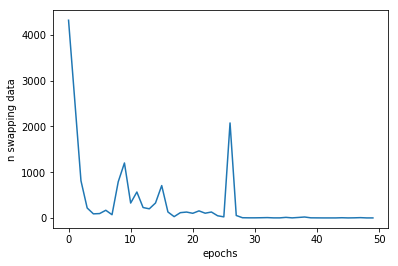

In [8]:
import matplotlib.pyplot as plt
import numpy as np

epoch = 50
fig = plt.figure()
plt.plot(np.arange(epoch), atob_s, label="A to B")
# plt.plot(np.arange(epoch), btoa_s, label="B to A", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("n swapping data")
# plt.title("compare accuracy")
# plt.legend()
plt.show()
fig.savefig("swapdata.png")

In [38]:
atob_10 = [arr[arr<10].tolist() for arr in [np.array(arr) for arr in atob]]
btoa_10 = [arr[arr<10].tolist() for arr in [np.array(arr) for arr in btoa]]
swap_10 = [a + b for a, b in zip(atob_10, btoa_10)]

In [48]:
list = [0] * 10
history = []
for swap in swap_10:
    history.append(list.copy())
    for idx in swap:
        list[idx] = 1^list[idx]
history = np.array(history).transpose()

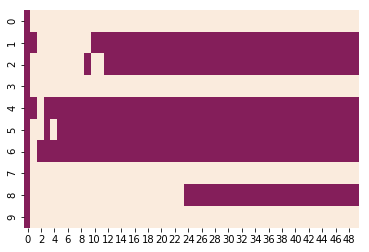

In [66]:
import numpy as np 
import seaborn as sns

sns.heatmap(data=history, vmin=-0.5, vmax=1.0, cbar=False)
plt.savefig("swap_map.png")

In [23]:
x_acc = [17.284, 10.28, 3.248, 0.868, 0.356, 0.38, 0.668, 0.28, 3.16, 4.804, 1.3, 2.264, 0.908, 0.796, 1.304, 2.828, 0.52, 0.112, 0.46, 0.512, 0.404, 0.616, 0.412, 0.516, 0.188, 0.092, 8.304, 0.212, 0.016, 0.008, 0.008, 0.016, 0.028, 0.004, 0.004, 0.048, 0.004, 0.04, 0.08, 0.008, 0.004, 0.0, 0.0, 0.0, 0.016, 0.0, 0.008, 0.024, 0.0, 0.0]
y_acc = [15.18, 12.512, 6.224, 10.456, 7.496, 8.832, 9.036, 8.74, 9.492, 11.904, 10.776, 18.356, 19.396, 14.376, 18.32, 19.676, 22.156, 24.38, 20.264, 18.184, 22.896, 22.2, 24.34, 23.696, 24.22, 21.676, 23.908, 18.508, 14.216, 14.72, 15.76, 15.984, 16.084, 17.232, 19.576, 13.468, 13.048, 23.128, 16.516, 12.332, 14.68, 15.856, 16.808, 16.172, 14.372, 16.348, 14.656, 14.936, 16.632, 16.564]
base_acc = [16.916, 17.968, 26.404, 37.068, 46.044, 47.796, 45.772, 59.0, 53.648, 60.98, 62.824, 62.072, 63.396, 65.208, 67.544, 68.816, 68.904, 70.144, 69.968, 69.156, 70.184, 72.668, 72.548, 75.412, 73.792, 73.728, 74.52, 73.996, 74.76, 74.056, 75.688, 76.584, 76.66, 75.88, 75.86, 75.484, 77.168, 77.432, 77.048, 76.912, 78.072, 77.324, 76.32, 76.744, 78.272, 78.888, 77.788, 78.432, 78.592, 79.012]

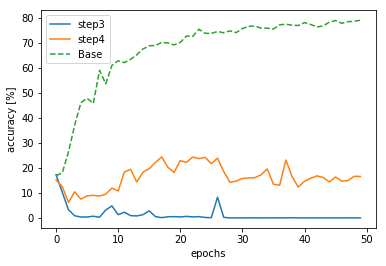

In [68]:
import matplotlib.pyplot as plt
import numpy as np

epoch = 50
fig = plt.figure()
plt.plot(np.arange(epoch), x_acc, label="step3")
plt.plot(np.arange(epoch), y_acc, label="step4")
plt.plot(np.arange(epoch), base_acc, label="Base", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy [%]")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("accuracy.png")